## Data preparation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import pickle
import torch
import torch.nn.functional as F
import tqdm
from torch import Tensor
from torch.nn import LSTM
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GATConv, SAGEConv, to_hetero
import torch_geometric.transforms as T
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import networkx as nx
import random
from collections import Counter

import tkinter as tk
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk

pd.set_option('display.max_rows', None)

In [2]:
with open('data10000.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
print(data)

HeteroData(
  reviewer={
    node_id=[9085],
    x=[10000, 305],
  },
  product={
    node_id=[63],
    x=[63, 402],
  },
  (reviewer, reviews, product)={ edge_index=[2, 10000] },
  (product, rev_reviews, reviewer)={ edge_index=[2, 10000] }
)


Split data into training, test and val sets

In [4]:
# Define your parameters in a dictionary
transform_parameters = {
    "num_val":0.1,
    "num_test":0.2,
    "is_undirected":False,
    "disjoint_train_ratio":0.3,
    "neg_sampling_ratio":1.0,
    "add_negative_train_samples":True,
    "edge_types":("reviewer", "reviews", "product"),
    "rev_edge_types":("product", "rev_reviews", "reviewer"), 
}

# Create the RandomLinkSplit transform object using the parameters
transform = T.RandomLinkSplit(
    **transform_parameters  # This unpacks the dictionary into the function arguments
)
train_data, val_data, test_data = transform(data)



In [5]:
print("Train data")
print(train_data)
print("__________________________________________\n")
print("Validation data")
print(val_data)
print("__________________________________________\n")
print("Test data")
print(test_data)

Train data
HeteroData(
  reviewer={
    node_id=[9085],
    x=[10000, 305],
  },
  product={
    node_id=[63],
    x=[63, 402],
  },
  (reviewer, reviews, product)={
    edge_index=[2, 4900],
    edge_label=[4200],
    edge_label_index=[2, 4200],
  },
  (product, rev_reviews, reviewer)={ edge_index=[2, 4900] }
)
__________________________________________

Validation data
HeteroData(
  reviewer={
    node_id=[9085],
    x=[10000, 305],
  },
  product={
    node_id=[63],
    x=[63, 402],
  },
  (reviewer, reviews, product)={
    edge_index=[2, 7000],
    edge_label=[2000],
    edge_label_index=[2, 2000],
  },
  (product, rev_reviews, reviewer)={ edge_index=[2, 7000] }
)
__________________________________________

Test data
HeteroData(
  reviewer={
    node_id=[9085],
    x=[10000, 305],
  },
  product={
    node_id=[63],
    x=[63, 402],
  },
  (reviewer, reviews, product)={
    edge_index=[2, 8000],
    edge_label=[4000],
    edge_label_index=[2, 4000],
  },
  (product, rev_reviews, rev

In [6]:
with open('train_data10000.pkl', 'wb') as file:
    pickle.dump(train_data, file)
with open('test_data10000.pkl', 'wb') as file:
    pickle.dump(test_data, file)
with open('val_data10000.pkl', 'wb') as file:
    pickle.dump(val_data, file)

In [7]:
with open('train_data10000.pkl', 'rb') as file:
    train_data = pickle.load(file)
with open('test_data10000.pkl', 'rb') as file:
    test_data = pickle.load(file)
with open('val_data10000.pkl', 'rb') as file:
    val_data = pickle.load(file)

In [11]:
# Configuration for loaders
# Train loader configuration with 20 neighbors in the first hop and 10 in the second
loader_configs = {
    "Train_Loader_Config": {
        "num_neighbors": [20, 10],  # Number of neighbors for sampling at each hop
        "batch_size": 512,          # Batch size for training
        "shuffle": True             # Shuffle the data during training
    }
}

# Define the test loader configuration
# Similar configuration as train loader but used for testing
test_loader_config = {
    "num_neighbors": [20, 10],   # Number of neighbors for sampling at each hop
    "batch_size": 512,           # Batch size for testing
    "shuffle": True              # Shuffle the data during testing
}
loader_configs["Test_Loader_Config"] = test_loader_config

# Validation loader configuration
val_loader_config = {
    "num_neighbors": [-1, -1],   # Number of neighbors for sampling at each hop
    "batch_size": 99999,         # Large batch size for validation
    "shuffle": False              # Shuffle the data during validation
}
loader_configs["Val_Loader_Config"] = val_loader_config

# Define seed edges for training
edge_label_index = train_data["reviewer", "reviews", "product"].edge_label_index
edge_label = train_data["reviewer", "reviews", "product"].edge_label

# Initialize the training data loader
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=loader_configs["Train_Loader_Config"]["num_neighbors"],
    edge_label_index=(("reviewer", "reviews", "product"), edge_label_index),
    edge_label=edge_label,
    batch_size=loader_configs["Train_Loader_Config"]["batch_size"],
    shuffle=loader_configs["Train_Loader_Config"]["shuffle"],
)

# Define seed edges for testing
edge_label_index_test = test_data["reviewer", "reviews", "product"].edge_label_index
edge_label_test = test_data["reviewer", "reviews", "product"].edge_label

# Initialize the test data loader
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=loader_configs["Test_Loader_Config"]["num_neighbors"],
    edge_label_index=(("reviewer", "reviews", "product"), edge_label_index_test),
    edge_label=edge_label_test,
    batch_size=loader_configs["Test_Loader_Config"]["batch_size"],
    shuffle=loader_configs["Test_Loader_Config"]["shuffle"],
)

# Define seed edges for validation
edge_label_index_val = val_data["reviewer", "reviews", "product"].edge_label_index
edge_label_val = val_data["reviewer", "reviews", "product"].edge_label

# Initialize the validation data loader
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=loader_configs["Val_Loader_Config"]["num_neighbors"],
    edge_label_index=(("reviewer", "reviews", "product"), edge_label_index_val),
    edge_label=edge_label_val,
    batch_size=loader_configs["Val_Loader_Config"]["batch_size"],
    shuffle=loader_configs["Val_Loader_Config"]["shuffle"],
)

# Load a sample from the validation loader
sampled_data = next(iter(val_loader))


In [54]:
print(val_data["reviewer", "reviews", "product"].edge_label_index)
print(sampled_data["reviewer", "reviews", "product"].edge_label_index)

tensor([[3282, 8707, 8616,  ..., 3121, 6535, 8548],
        [   8,   60,   59,  ...,   15,   31,   30]])
tensor([[ 621, 1656, 1634,  ...,  599, 1258, 1625],
        [   8,   60,   59,  ...,   15,   31,   30]])


In [10]:
print(sampled_data)

HeteroData(
  reviewer={
    node_id=[9085],
    x=[7679, 305],
    n_id=[7679],
  },
  product={
    node_id=[63],
    x=[63, 402],
    n_id=[63],
  },
  (reviewer, reviews, product)={
    edge_index=[2, 7000],
    edge_label=[2000],
    edge_label_index=[2, 2000],
    e_id=[7000],
    input_id=[2000],
  },
  (product, rev_reviews, reviewer)={
    edge_index=[2, 7000],
    e_id=[7000],
  }
)


## Creation of GNNs and train functions

Creation of GNN models

In [12]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, conv_type=None):
        super().__init__()
        if conv_type == 'sage':
            self.conv1 = SAGEConv(hidden_channels, hidden_channels)
            self.conv2 = SAGEConv(hidden_channels, hidden_channels)
            #self.conv3 = SAGEConv(hidden_channels, hidden_channels)  # Third layer
        elif conv_type == 'gat':
            self.conv1 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)
            self.conv2 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)
            #self.conv3 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)  # Third layer
        else:
            raise ValueError("Unknown conv_type")
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.conv2(x, edge_index))
        x = self.conv2(x, edge_index)
        #return torch.sigmoid(x) 
        return x
class Classifier(torch.nn.Module):
    def __init__(self, hidden_channels, classifier_type='mean'):
        super().__init__()
        self.classifier_type = classifier_type
        if classifier_type == 'lstm':
            self.lstm = LSTM(input_size=hidden_channels, hidden_size=hidden_channels, batch_first=True)

    def forward(self, x_reviewer: Tensor, x_product: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_reviewer = x_reviewer[edge_label_index[0]]
        edge_feat_product = x_product[edge_label_index[1]]
        edge_features = edge_feat_reviewer * edge_feat_product  # Element-wise multiplication

        if self.classifier_type == 'lstm':
            # LSTM processing
            edge_features = edge_features.unsqueeze(1)  # Add seq_len dimension
            lstm_out, _ = self.lstm(edge_features)
            lstm_out = lstm_out.squeeze(1)  # Remove seq_len dimension
            return lstm_out.mean(dim=-1)
        else:
            # Mean operation
            return edge_features.mean(dim=-1)

     
class Model(torch.nn.Module):
    def __init__(self, hidden_channels, conv_type=None, classifier_type='mean'):
        super().__init__()
        self.reviewer_emb = torch.nn.Embedding(data["reviewer"].num_nodes, hidden_channels)
        self.product_emb = torch.nn.Embedding(data["product"].num_nodes, hidden_channels)
        self.gnn = GNN(hidden_channels, conv_type=conv_type)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier(hidden_channels=hidden_channels, classifier_type=classifier_type)
        
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "reviewer": self.reviewer_emb(data["reviewer"].node_id),
          #"product": self.product_lin(data["product"].x) + self.product_emb(data["product"].node_id),
          "product": self.product_emb(data["product"].node_id),
        } 
        # x_dict holds feature matrices of all node types
        # edge_index_dict holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["reviewer"],
            x_dict["product"],
            data["reviewer", "reviews", "product"].edge_label_index,
        )
        return pred
        
# For SAGEConv
#model_sage = Model(hidden_channels=128, conv_type='sage', classifier_type='lstm')
# For GATConv
#model_gat = Model(hidden_channels=128, conv_type='gat', classifier_type='mean')

Implementation of Bayesian Personalised Ranking loss function

In [13]:
def bpr_loss(user_interacted_scores, user_non_interacted_scores):
    # BPR loss calculation
    score_diff = user_interacted_scores - user_non_interacted_scores
    loss = -torch.mean(torch.log(torch.sigmoid(score_diff)))
    return loss

Function for model training

In [14]:
def train_model(model, train_loader, test_loader, hyperparams):
    
    model_type = hyperparams['model_type']  # Extract model_type
    print(f"Training {model_type} model on device: '{hyperparams['device']}'")
    model = model.to(hyperparams['device'])
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
    
    # Define scheduler if using GATConv
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=hyperparams['lr_decay_step'], gamma=hyperparams['lr_decay_factor'])

    loss_function_name = hyperparams.get('loss_function', 'bce')  # Default to 'bce' if not provided
    if loss_function_name == 'crossentropy':
        loss_fn = F.binary_cross_entropy_with_logits
    elif loss_function_name == 'bce':
        loss_fn =  torch.nn.BCELoss()
    else:
        loss_fn = torch.nn.BCELoss()

    best_val_loss = float('inf')
    best_epoch = -1
    epochs_without_improvement = 0

    train_losses = []
    test_losses = []
    
    for epoch in range(1, hyperparams['num_epochs'] + 1):
        model.train()
        total_loss = total_examples = 0
        for sampled_data in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            sampled_data.to(hyperparams['device'])
            if loss_function_name == 'bpr':
                pred = model(sampled_data)  # Model predictions for all edges
                edge_labels = sampled_data['reviewer', 'reviews', 'product'].edge_label

                # Ensure equal sampling of positive and negative samples
                positive_indices = torch.where(edge_labels == 1)[0]
                negative_indices = torch.where(edge_labels == 0)[0]

                # Randomly select negative samples to match the number of positive samples
                # Here we need to handle the case when there are not enough negative samples
                num_samples = min(len(positive_indices), len(negative_indices))
                if num_samples > 0:
                    negative_indices = negative_indices[torch.randperm(len(negative_indices))[:num_samples]]
                    positive_indices = positive_indices[torch.randperm(len(positive_indices))[:num_samples]]

                    positive_pred = pred[positive_indices]
                    negative_pred = pred[negative_indices]

                    loss = bpr_loss(positive_pred, negative_pred)
                else:
                    continue  # Skip this batch if no positive or negative samples are present
            else:
                # Handling other types of losses
                pred = torch.sigmoid(model(sampled_data)) if loss_function_name != 'crossentropy' else model(sampled_data)
                ground_truth = sampled_data["reviewer", "reviews", "product"].edge_label
                loss = loss_fn(pred, ground_truth)
            
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
        
        avg_train_loss = total_loss / total_examples
        train_losses.append(avg_train_loss)  # Append to train losses
        
        model.eval()
        total_test_loss = total_examples = 0
        with torch.no_grad():
            for sampled_data in test_loader:
                sampled_data.to(hyperparams['device'])
                if loss_function_name == 'bpr':
                    pred = model(sampled_data)  # Model predictions for all edges
                    edge_labels = sampled_data['reviewer', 'reviews', 'product'].edge_label

                    # Ensure equal sampling of positive and negative samples
                    positive_indices = torch.where(edge_labels == 1)[0]
                    negative_indices = torch.where(edge_labels == 0)[0]

                    # Randomly select negative samples to match the number of positive samples
                    # Here we need to handle the case when there are not enough negative samples
                    num_samples = min(len(positive_indices), len(negative_indices))
                    if num_samples > 0:
                        negative_indices = negative_indices[torch.randperm(len(negative_indices))[:num_samples]]
                        positive_indices = positive_indices[torch.randperm(len(positive_indices))[:num_samples]]

                        positive_pred = pred[positive_indices]
                        negative_pred = pred[negative_indices]

                        loss = bpr_loss(positive_pred, negative_pred)
                    else:
                        continue  # Skip this batch if no positive or negative samples are present
                else:
                    # Handling other types of losses
                    pred = torch.sigmoid(model(sampled_data)) if loss_function_name != 'crossentropy' else model(sampled_data)
                    ground_truth = sampled_data["reviewer", "reviews", "product"].edge_label
                    loss = loss_fn(pred, ground_truth)
                
            
                total_test_loss += float(loss) * pred.numel()
                total_examples += pred.numel()
        avg_test_loss = total_test_loss / total_examples
        test_losses.append(avg_test_loss)  # Append to test losses
        print(f"{model_type} - Epoch: {epoch:03d}, Train Loss: {avg_train_loss:.4f} Test Loss: {avg_test_loss:.4f}")


        # Early Stopping and model checkpoint logic
        if avg_test_loss < best_val_loss:
            best_val_loss = avg_test_loss
            best_epoch = epoch
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f'best_model{model_type}2.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == hyperparams['patience']:
                print("Early stopping!")
                break
        
        scheduler.step()
        # Plotting the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.title(f"{model_type} Losses over Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()        

    print(f"{model_type} - Best Test Loss: {best_val_loss:.4f} achieved at Epoch: {best_epoch:03d}")
    model.load_state_dict(torch.load(f'best_model{model_type}2.pth'))
    
    return best_epoch, best_val_loss

## Creating evaluation functions

In [15]:
def prepare_data(sampled_data, model, device):
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        pred = model(sampled_data)

    ground_truth_labels = sampled_data["reviewer", "reviews", "product"].edge_label
    ground_truth_labels_index = sampled_data["reviewer", "reviews", "product"].edge_label_index
    probabilities = torch.sigmoid(pred)
    binary_predictions = (probabilities >= 0.5).float()

    return ground_truth_labels_index, ground_truth_labels, probabilities, binary_predictions


def get_positive_negative_indices(ground_truth_labels):
    positive_edge_indices = (ground_truth_labels == 1).nonzero(as_tuple=True)[0]
    negative_edge_indices = (ground_truth_labels == 0).nonzero(as_tuple=True)[0]
    return positive_edge_indices, negative_edge_indices


def plot_confusion_matrix_for_positive_edges(models, sampled_data, device):
    for model_name, model in models.items():
        _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
        positive_edge_indices, _ = get_positive_negative_indices(ground_truth_labels)
        
        positive_preds = binary_predictions[positive_edge_indices]
        true_positive_labels = torch.ones_like(positive_preds)
        
        cm = confusion_matrix(true_positive_labels.cpu().numpy(), positive_preds.cpu().numpy())

        # Plotting
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                    xticklabels=['Predicted 0', 'Predicted 1'], 
                    yticklabels=['Actual 1', 'Actual 1'])
        plt.ylabel('True labels')
        plt.xlabel('Predicted labels')
        plt.title(f'Confusion Matrix for Positive Edges - {model_name}')
        plt.show()


def evaluate_models_auc(models, val_loader, device):
    results = {}
    for model_name, model in models.items():
        preds, ground_truths = [], []

        for sampled_data in val_loader:
            _, ground_truth_labels, _, predictions = prepare_data(sampled_data, model, device)
            preds.append(predictions)
            ground_truths.append(ground_truth_labels)

        pred = torch.cat(preds, dim=0).detach().cpu().numpy()
        ground_truth = torch.cat(ground_truths, dim=0).detach().cpu().numpy()

        auc = roc_auc_score(ground_truth, pred)
        results[model_name] = auc
        print(f"Validation AUC for {model_name}: {auc:.4f}")
        print("-----------------------------")
    return results

def evaluate_accuracy(models, sampled_data, device):
    results = {}

    for model_name, model in models.items():
        _, ground_truth_labels, probabilities, binary_predictions = prepare_data(sampled_data, model, device)
        positive_edge_indices, negative_edge_indices = get_positive_negative_indices(ground_truth_labels)

        # Positive Edges
        positive_probs = probabilities[positive_edge_indices]
        positive_preds = binary_predictions[positive_edge_indices]
        positive_true = ground_truth_labels[positive_edge_indices]

        # Negative Edges
        negative_probs = probabilities[negative_edge_indices]
        negative_preds = binary_predictions[negative_edge_indices]
        negative_true = ground_truth_labels[negative_edge_indices]

        results[model_name] = {
            "Average probability for Positive Edges": positive_probs.mean().item(),
            "Accuracy for Positive Edges": (positive_preds == positive_true).float().mean().item(),
            "Average probability for Negative Edges": negative_probs.mean().item(),
            "Accuracy for Negative Edges": (negative_preds == negative_true).float().mean().item(),
        }

    return results


def count_predictions(models, sampled_data, device):
    results = {}

    for model_name, model in models.items():
        _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
        positive_edge_indices, negative_edge_indices = get_positive_negative_indices(ground_truth_labels)

        positive_preds = binary_predictions[positive_edge_indices]
        negative_preds = binary_predictions[negative_edge_indices]

        results[model_name] = {
            "For Positive Edges: Number of 1's predicted": positive_preds.sum().item(),
            "For Positive Edges: Number of 0's predicted": positive_preds.numel() - positive_preds.sum().item(),
            "For Negative Edges: Number of 1's predicted": negative_preds.sum().item(),
            "For Negative Edges: Number of 0's predicted": negative_preds.numel() - negative_preds.sum().item(),
        }

    return results
from sklearn.metrics import precision_score, recall_score

def evaluate_precision_recall(models, sampled_data, device):
    results = {}
    for model_name, model in models.items():
        _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
        precision = precision_score(ground_truth_labels.cpu().numpy(), binary_predictions.cpu().numpy())
        recall = recall_score(ground_truth_labels.cpu().numpy(), binary_predictions.cpu().numpy())

        results[model_name] = {
            "Precision": precision,
            "Recall": recall
        }
    return results
from sklearn.metrics import f1_score

def evaluate_f1_score(models, sampled_data, device):
    results = {}
    for model_name, model in models.items():
        _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
        f1 = f1_score(ground_truth_labels.cpu().numpy(), binary_predictions.cpu().numpy())

        results[model_name] = {
            "F1 Score": f1
        }
    return results

def top_k_accuracy(models, data_loader, k, device):
    results = {}
    for model_name, model in models.items():
        positive_correct_count = 0
        negative_correct_count = 0
        positive_total_count = 0
        negative_total_count = 0

        for sampled_data in data_loader:
            _, ground_truth_labels, probabilities, _ = prepare_data(sampled_data, model, device)
            positive_edge_indices, negative_edge_indices = get_positive_negative_indices(ground_truth_labels)

            # Sortiramo verovatnoće i uzimamo top K indeksa
            _, top_k_indices = torch.topk(probabilities, k, largest=True)

            # Proveravamo tačnost za pozitivne uzorke
            positive_correct_count += sum([1 for idx in positive_edge_indices if idx in top_k_indices])
            positive_total_count += positive_edge_indices.size(0)

            # Proveravamo tačnost za negativne uzorke
            negative_correct_count += sum([1 for idx in negative_edge_indices if idx in top_k_indices])
            negative_total_count += negative_edge_indices.size(0)

        positive_accuracy = positive_correct_count / positive_total_count if positive_total_count > 0 else 0
        negative_accuracy = negative_correct_count / negative_total_count if negative_total_count > 0 else 0
        results[model_name] = {
            "Top-K Accuracy for Positive Edges": positive_accuracy,
            "Top-K Accuracy for Negative Edges": negative_accuracy
        }

    return results


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
results_df = pd.DataFrame()
results100000_df = pd.DataFrame()


## Hyperparameters tuning

Training SAGEConv model on device: 'cpu'


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


SAGEConv - Epoch: 001, Train Loss: 0.6917 Test Loss: 0.6864


100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


SAGEConv - Epoch: 002, Train Loss: 0.6800 Test Loss: 0.6555


100%|██████████| 9/9 [00:01<00:00,  7.04it/s]


SAGEConv - Epoch: 003, Train Loss: 0.6434 Test Loss: 0.5975


100%|██████████| 9/9 [00:12<00:00,  1.34s/it]


SAGEConv - Epoch: 004, Train Loss: 0.5876 Test Loss: 0.5443


100%|██████████| 9/9 [00:02<00:00,  3.76it/s]


SAGEConv - Epoch: 005, Train Loss: 0.5387 Test Loss: 0.5094


100%|██████████| 9/9 [00:02<00:00,  4.47it/s]


SAGEConv - Epoch: 006, Train Loss: 0.5129 Test Loss: 0.4923


100%|██████████| 9/9 [00:01<00:00,  5.24it/s]


SAGEConv - Epoch: 007, Train Loss: 0.4990 Test Loss: 0.4800


100%|██████████| 9/9 [00:02<00:00,  3.79it/s]


SAGEConv - Epoch: 008, Train Loss: 0.4939 Test Loss: 0.4785


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


SAGEConv - Epoch: 009, Train Loss: 0.4896 Test Loss: 0.4717


100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


SAGEConv - Epoch: 010, Train Loss: 0.4885 Test Loss: 0.4675


100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


SAGEConv - Epoch: 011, Train Loss: 0.4833 Test Loss: 0.4627


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


SAGEConv - Epoch: 012, Train Loss: 0.4826 Test Loss: 0.4608


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


SAGEConv - Epoch: 013, Train Loss: 0.4797 Test Loss: 0.4620


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


SAGEConv - Epoch: 014, Train Loss: 0.4793 Test Loss: 0.4599


100%|██████████| 9/9 [00:01<00:00,  5.03it/s]


SAGEConv - Epoch: 015, Train Loss: 0.4789 Test Loss: 0.4646


100%|██████████| 9/9 [00:02<00:00,  3.70it/s]


SAGEConv - Epoch: 016, Train Loss: 0.4781 Test Loss: 0.4587


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


SAGEConv - Epoch: 017, Train Loss: 0.4754 Test Loss: 0.4585


100%|██████████| 9/9 [00:05<00:00,  1.56it/s]


SAGEConv - Epoch: 018, Train Loss: 0.4741 Test Loss: 0.4545


100%|██████████| 9/9 [00:02<00:00,  3.54it/s]


SAGEConv - Epoch: 019, Train Loss: 0.4703 Test Loss: 0.4551


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


SAGEConv - Epoch: 020, Train Loss: 0.4699 Test Loss: 0.4516


100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


SAGEConv - Epoch: 021, Train Loss: 0.4671 Test Loss: 0.4521


100%|██████████| 9/9 [00:01<00:00,  6.40it/s]


SAGEConv - Epoch: 022, Train Loss: 0.4673 Test Loss: 0.4486


100%|██████████| 9/9 [00:02<00:00,  3.74it/s]


SAGEConv - Epoch: 023, Train Loss: 0.4668 Test Loss: 0.4498


100%|██████████| 9/9 [00:01<00:00,  7.25it/s]


SAGEConv - Epoch: 024, Train Loss: 0.4646 Test Loss: 0.4509


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


SAGEConv - Epoch: 025, Train Loss: 0.4591 Test Loss: 0.4500


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


SAGEConv - Epoch: 026, Train Loss: 0.4622 Test Loss: 0.4462


100%|██████████| 9/9 [00:01<00:00,  6.93it/s]


SAGEConv - Epoch: 027, Train Loss: 0.4622 Test Loss: 0.4475


100%|██████████| 9/9 [00:01<00:00,  6.87it/s]


SAGEConv - Epoch: 028, Train Loss: 0.4605 Test Loss: 0.4487


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


SAGEConv - Epoch: 029, Train Loss: 0.4603 Test Loss: 0.4474


100%|██████████| 9/9 [00:01<00:00,  6.68it/s]


SAGEConv - Epoch: 030, Train Loss: 0.4625 Test Loss: 0.4444


100%|██████████| 9/9 [00:01<00:00,  7.00it/s]


SAGEConv - Epoch: 031, Train Loss: 0.4586 Test Loss: 0.4469


100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


SAGEConv - Epoch: 032, Train Loss: 0.4609 Test Loss: 0.4455


100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


SAGEConv - Epoch: 033, Train Loss: 0.4604 Test Loss: 0.4486


100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


SAGEConv - Epoch: 034, Train Loss: 0.4542 Test Loss: 0.4457


100%|██████████| 9/9 [00:01<00:00,  7.15it/s]


SAGEConv - Epoch: 035, Train Loss: 0.4589 Test Loss: 0.4447


100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


SAGEConv - Epoch: 036, Train Loss: 0.4567 Test Loss: 0.4462


100%|██████████| 9/9 [00:01<00:00,  7.05it/s]


SAGEConv - Epoch: 037, Train Loss: 0.4554 Test Loss: 0.4457


100%|██████████| 9/9 [00:01<00:00,  6.36it/s]


SAGEConv - Epoch: 038, Train Loss: 0.4521 Test Loss: 0.4440


100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


SAGEConv - Epoch: 039, Train Loss: 0.4551 Test Loss: 0.4446


100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


SAGEConv - Epoch: 040, Train Loss: 0.4570 Test Loss: 0.4441


100%|██████████| 9/9 [00:01<00:00,  7.03it/s]


SAGEConv - Epoch: 041, Train Loss: 0.4499 Test Loss: 0.4441


100%|██████████| 9/9 [00:01<00:00,  4.80it/s]


SAGEConv - Epoch: 042, Train Loss: 0.4549 Test Loss: 0.4443


100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


SAGEConv - Epoch: 043, Train Loss: 0.4539 Test Loss: 0.4406


100%|██████████| 9/9 [00:01<00:00,  7.16it/s]


SAGEConv - Epoch: 044, Train Loss: 0.4542 Test Loss: 0.4412


100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


SAGEConv - Epoch: 045, Train Loss: 0.4536 Test Loss: 0.4412


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


SAGEConv - Epoch: 046, Train Loss: 0.4545 Test Loss: 0.4432


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


SAGEConv - Epoch: 047, Train Loss: 0.4540 Test Loss: 0.4428


100%|██████████| 9/9 [00:02<00:00,  4.38it/s]


SAGEConv - Epoch: 048, Train Loss: 0.4523 Test Loss: 0.4424


100%|██████████| 9/9 [00:01<00:00,  6.84it/s]


SAGEConv - Epoch: 049, Train Loss: 0.4497 Test Loss: 0.4405


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


SAGEConv - Epoch: 050, Train Loss: 0.4513 Test Loss: 0.4438


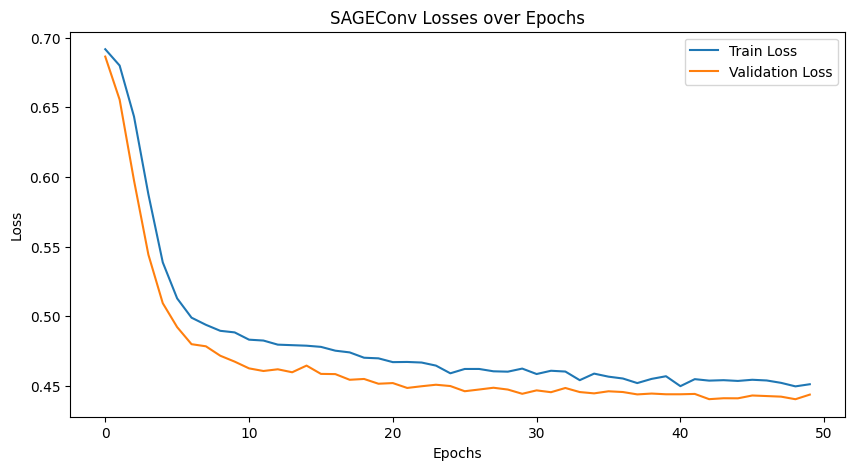

SAGEConv - Best Test Loss: 0.4405 achieved at Epoch: 049
Validation AUC for SAGEConv: 0.8425
-----------------------------
Training GATConv model on device: 'cpu'


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


GATConv - Epoch: 001, Train Loss: 0.6925 Test Loss: 0.6902


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


GATConv - Epoch: 002, Train Loss: 0.6874 Test Loss: 0.6799


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


GATConv - Epoch: 003, Train Loss: 0.6752 Test Loss: 0.6506


100%|██████████| 9/9 [00:01<00:00,  4.61it/s]


GATConv - Epoch: 004, Train Loss: 0.6559 Test Loss: 0.6204


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


GATConv - Epoch: 005, Train Loss: 0.6418 Test Loss: 0.6015


100%|██████████| 9/9 [00:01<00:00,  4.55it/s]


GATConv - Epoch: 006, Train Loss: 0.6309 Test Loss: 0.5888


100%|██████████| 9/9 [00:02<00:00,  3.00it/s]


GATConv - Epoch: 007, Train Loss: 0.6235 Test Loss: 0.5808


100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


GATConv - Epoch: 008, Train Loss: 0.6166 Test Loss: 0.5728


100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


GATConv - Epoch: 009, Train Loss: 0.6048 Test Loss: 0.5581


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


GATConv - Epoch: 010, Train Loss: 0.5868 Test Loss: 0.5305


100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


GATConv - Epoch: 011, Train Loss: 0.5658 Test Loss: 0.5117


100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


GATConv - Epoch: 012, Train Loss: 0.5474 Test Loss: 0.5020


100%|██████████| 9/9 [00:02<00:00,  3.42it/s]


GATConv - Epoch: 013, Train Loss: 0.5340 Test Loss: 0.4930


100%|██████████| 9/9 [00:01<00:00,  5.44it/s]


GATConv - Epoch: 014, Train Loss: 0.5242 Test Loss: 0.4892


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


GATConv - Epoch: 015, Train Loss: 0.5159 Test Loss: 0.4944


100%|██████████| 9/9 [00:01<00:00,  5.42it/s]


GATConv - Epoch: 016, Train Loss: 0.5094 Test Loss: 0.4926


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


GATConv - Epoch: 017, Train Loss: 0.5039 Test Loss: 0.4825


100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


GATConv - Epoch: 018, Train Loss: 0.5008 Test Loss: 0.4767


100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


GATConv - Epoch: 019, Train Loss: 0.4982 Test Loss: 0.4782


100%|██████████| 9/9 [00:02<00:00,  3.74it/s]


GATConv - Epoch: 020, Train Loss: 0.4971 Test Loss: 0.4757


100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


GATConv - Epoch: 021, Train Loss: 0.4960 Test Loss: 0.4713


100%|██████████| 9/9 [00:02<00:00,  3.80it/s]


GATConv - Epoch: 022, Train Loss: 0.4945 Test Loss: 0.4784


100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


GATConv - Epoch: 023, Train Loss: 0.4939 Test Loss: 0.4812


100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


GATConv - Epoch: 024, Train Loss: 0.4931 Test Loss: 0.4766


100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


GATConv - Epoch: 025, Train Loss: 0.4926 Test Loss: 0.4750


100%|██████████| 9/9 [00:01<00:00,  5.21it/s]


GATConv - Epoch: 026, Train Loss: 0.4929 Test Loss: 0.4691


100%|██████████| 9/9 [00:03<00:00,  2.42it/s]


GATConv - Epoch: 027, Train Loss: 0.4919 Test Loss: 0.4728


100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


GATConv - Epoch: 028, Train Loss: 0.4921 Test Loss: 0.4701


100%|██████████| 9/9 [00:02<00:00,  3.59it/s]


GATConv - Epoch: 029, Train Loss: 0.4911 Test Loss: 0.4733


100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


GATConv - Epoch: 030, Train Loss: 0.4909 Test Loss: 0.4699


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


GATConv - Epoch: 031, Train Loss: 0.4911 Test Loss: 0.4722


100%|██████████| 9/9 [00:02<00:00,  3.75it/s]


GATConv - Epoch: 032, Train Loss: 0.4908 Test Loss: 0.4744


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


GATConv - Epoch: 033, Train Loss: 0.4902 Test Loss: 0.4757


100%|██████████| 9/9 [00:01<00:00,  5.46it/s]


GATConv - Epoch: 034, Train Loss: 0.4902 Test Loss: 0.4750


100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


GATConv - Epoch: 035, Train Loss: 0.4893 Test Loss: 0.4761


100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


GATConv - Epoch: 036, Train Loss: 0.4890 Test Loss: 0.4767


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


GATConv - Epoch: 037, Train Loss: 0.4886 Test Loss: 0.4744


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


GATConv - Epoch: 038, Train Loss: 0.4889 Test Loss: 0.4773


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


GATConv - Epoch: 039, Train Loss: 0.4893 Test Loss: 0.4787


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


GATConv - Epoch: 040, Train Loss: 0.4886 Test Loss: 0.4781


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


GATConv - Epoch: 041, Train Loss: 0.4882 Test Loss: 0.4764


100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


GATConv - Epoch: 042, Train Loss: 0.4882 Test Loss: 0.4757


100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


GATConv - Epoch: 043, Train Loss: 0.4881 Test Loss: 0.4777


100%|██████████| 9/9 [00:02<00:00,  3.42it/s]


GATConv - Epoch: 044, Train Loss: 0.4881 Test Loss: 0.4789


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


GATConv - Epoch: 045, Train Loss: 0.4884 Test Loss: 0.4801


100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


GATConv - Epoch: 046, Train Loss: 0.4891 Test Loss: 0.4741
Early stopping!


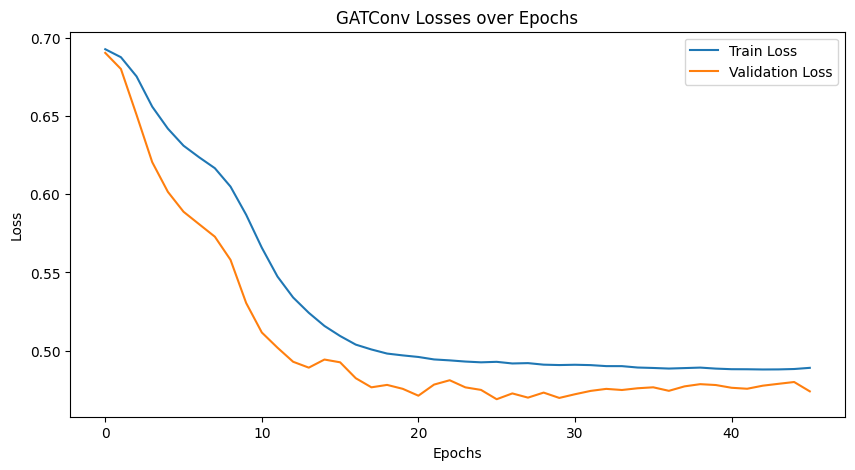

GATConv - Best Test Loss: 0.4691 achieved at Epoch: 026
Validation AUC for GATConv: 0.8410
-----------------------------
Training SAGEConv model on device: 'cpu'


100%|██████████| 9/9 [00:01<00:00,  4.72it/s]


SAGEConv - Epoch: 001, Train Loss: 0.6921 Test Loss: 0.6879


100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


SAGEConv - Epoch: 002, Train Loss: 0.6828 Test Loss: 0.6639


100%|██████████| 9/9 [00:01<00:00,  6.25it/s]


SAGEConv - Epoch: 003, Train Loss: 0.6526 Test Loss: 0.6141


100%|██████████| 9/9 [00:01<00:00,  4.98it/s]


SAGEConv - Epoch: 004, Train Loss: 0.6053 Test Loss: 0.5594


100%|██████████| 9/9 [00:01<00:00,  6.45it/s]


SAGEConv - Epoch: 005, Train Loss: 0.5543 Test Loss: 0.5169


100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


SAGEConv - Epoch: 006, Train Loss: 0.5229 Test Loss: 0.4997


100%|██████████| 9/9 [00:01<00:00,  4.52it/s]


SAGEConv - Epoch: 007, Train Loss: 0.5065 Test Loss: 0.4882


100%|██████████| 9/9 [00:01<00:00,  6.78it/s]


SAGEConv - Epoch: 008, Train Loss: 0.4998 Test Loss: 0.4828


100%|██████████| 9/9 [00:01<00:00,  6.90it/s]


SAGEConv - Epoch: 009, Train Loss: 0.4952 Test Loss: 0.4797


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


SAGEConv - Epoch: 010, Train Loss: 0.4931 Test Loss: 0.4754


100%|██████████| 9/9 [00:01<00:00,  4.95it/s]


SAGEConv - Epoch: 011, Train Loss: 0.4910 Test Loss: 0.4736


100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


SAGEConv - Epoch: 012, Train Loss: 0.4885 Test Loss: 0.4721


100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


SAGEConv - Epoch: 013, Train Loss: 0.4867 Test Loss: 0.4699


100%|██████████| 9/9 [00:01<00:00,  6.35it/s]


SAGEConv - Epoch: 014, Train Loss: 0.4852 Test Loss: 0.4671


100%|██████████| 9/9 [00:01<00:00,  7.06it/s]


SAGEConv - Epoch: 015, Train Loss: 0.4814 Test Loss: 0.4702


100%|██████████| 9/9 [00:01<00:00,  4.93it/s]


SAGEConv - Epoch: 016, Train Loss: 0.4823 Test Loss: 0.4656


100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


SAGEConv - Epoch: 017, Train Loss: 0.4795 Test Loss: 0.4629


100%|██████████| 9/9 [00:01<00:00,  4.86it/s]


SAGEConv - Epoch: 018, Train Loss: 0.4750 Test Loss: 0.4640


100%|██████████| 9/9 [00:01<00:00,  5.19it/s]


SAGEConv - Epoch: 019, Train Loss: 0.4732 Test Loss: 0.4590


100%|██████████| 9/9 [00:01<00:00,  6.46it/s]


SAGEConv - Epoch: 020, Train Loss: 0.4708 Test Loss: 0.4580


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


SAGEConv - Epoch: 021, Train Loss: 0.4726 Test Loss: 0.4560


100%|██████████| 9/9 [00:01<00:00,  4.51it/s]


SAGEConv - Epoch: 022, Train Loss: 0.4665 Test Loss: 0.4558


100%|██████████| 9/9 [00:01<00:00,  4.87it/s]


SAGEConv - Epoch: 023, Train Loss: 0.4658 Test Loss: 0.4550


100%|██████████| 9/9 [00:01<00:00,  6.35it/s]


SAGEConv - Epoch: 024, Train Loss: 0.4636 Test Loss: 0.4498


100%|██████████| 9/9 [00:01<00:00,  5.04it/s]


SAGEConv - Epoch: 025, Train Loss: 0.4616 Test Loss: 0.4508


100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


SAGEConv - Epoch: 026, Train Loss: 0.4589 Test Loss: 0.4527


100%|██████████| 9/9 [00:01<00:00,  5.19it/s]


SAGEConv - Epoch: 027, Train Loss: 0.4584 Test Loss: 0.4489


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


SAGEConv - Epoch: 028, Train Loss: 0.4592 Test Loss: 0.4503


100%|██████████| 9/9 [00:01<00:00,  6.36it/s]


SAGEConv - Epoch: 029, Train Loss: 0.4546 Test Loss: 0.4472


100%|██████████| 9/9 [00:01<00:00,  7.06it/s]


SAGEConv - Epoch: 030, Train Loss: 0.4574 Test Loss: 0.4491


100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


SAGEConv - Epoch: 031, Train Loss: 0.4526 Test Loss: 0.4467


100%|██████████| 9/9 [00:01<00:00,  4.98it/s]


SAGEConv - Epoch: 032, Train Loss: 0.4533 Test Loss: 0.4478


100%|██████████| 9/9 [00:01<00:00,  6.77it/s]


SAGEConv - Epoch: 033, Train Loss: 0.4516 Test Loss: 0.4424


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


SAGEConv - Epoch: 034, Train Loss: 0.4532 Test Loss: 0.4474


100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


SAGEConv - Epoch: 035, Train Loss: 0.4532 Test Loss: 0.4446


100%|██████████| 9/9 [00:01<00:00,  6.31it/s]


SAGEConv - Epoch: 036, Train Loss: 0.4524 Test Loss: 0.4479


100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


SAGEConv - Epoch: 037, Train Loss: 0.4569 Test Loss: 0.4447


100%|██████████| 9/9 [00:01<00:00,  7.05it/s]


SAGEConv - Epoch: 038, Train Loss: 0.4511 Test Loss: 0.4446


100%|██████████| 9/9 [00:01<00:00,  6.68it/s]


SAGEConv - Epoch: 039, Train Loss: 0.4486 Test Loss: 0.4478


100%|██████████| 9/9 [00:01<00:00,  6.86it/s]


SAGEConv - Epoch: 040, Train Loss: 0.4513 Test Loss: 0.4433


100%|██████████| 9/9 [00:01<00:00,  7.01it/s]


SAGEConv - Epoch: 041, Train Loss: 0.4522 Test Loss: 0.4435


100%|██████████| 9/9 [00:01<00:00,  5.40it/s]


SAGEConv - Epoch: 042, Train Loss: 0.4504 Test Loss: 0.4453


100%|██████████| 9/9 [00:01<00:00,  6.67it/s]


SAGEConv - Epoch: 043, Train Loss: 0.4490 Test Loss: 0.4434


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


SAGEConv - Epoch: 044, Train Loss: 0.4471 Test Loss: 0.4444


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


SAGEConv - Epoch: 045, Train Loss: 0.4507 Test Loss: 0.4414


100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


SAGEConv - Epoch: 046, Train Loss: 0.4483 Test Loss: 0.4416


100%|██████████| 9/9 [00:01<00:00,  6.77it/s]


SAGEConv - Epoch: 047, Train Loss: 0.4495 Test Loss: 0.4408


100%|██████████| 9/9 [00:02<00:00,  4.49it/s]


SAGEConv - Epoch: 048, Train Loss: 0.4447 Test Loss: 0.4401


100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


SAGEConv - Epoch: 049, Train Loss: 0.4455 Test Loss: 0.4427


100%|██████████| 9/9 [00:01<00:00,  7.14it/s]


SAGEConv - Epoch: 050, Train Loss: 0.4488 Test Loss: 0.4404


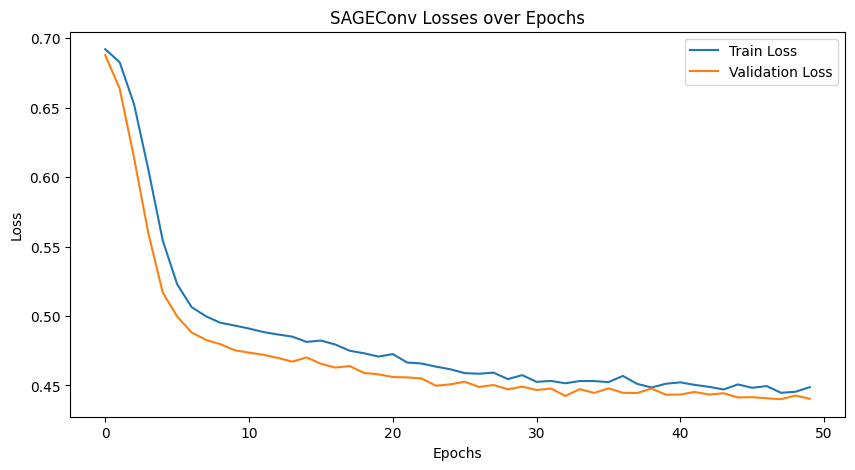

SAGEConv - Best Test Loss: 0.4401 achieved at Epoch: 048
Validation AUC for SAGEConv: 0.8520
-----------------------------
Training GATConv model on device: 'cpu'


100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


GATConv - Epoch: 001, Train Loss: 0.6920 Test Loss: 0.6867


100%|██████████| 9/9 [00:02<00:00,  3.75it/s]


GATConv - Epoch: 002, Train Loss: 0.6854 Test Loss: 0.6664


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


GATConv - Epoch: 003, Train Loss: 0.6705 Test Loss: 0.6368


100%|██████████| 9/9 [00:01<00:00,  4.53it/s]


GATConv - Epoch: 004, Train Loss: 0.6511 Test Loss: 0.6113


100%|██████████| 9/9 [00:02<00:00,  3.75it/s]


GATConv - Epoch: 005, Train Loss: 0.6388 Test Loss: 0.5985


100%|██████████| 9/9 [00:01<00:00,  5.48it/s]


GATConv - Epoch: 006, Train Loss: 0.6304 Test Loss: 0.5882


100%|██████████| 9/9 [00:02<00:00,  3.74it/s]


GATConv - Epoch: 007, Train Loss: 0.6249 Test Loss: 0.5816


100%|██████████| 9/9 [00:01<00:00,  4.88it/s]


GATConv - Epoch: 008, Train Loss: 0.6193 Test Loss: 0.5722


100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


GATConv - Epoch: 009, Train Loss: 0.6097 Test Loss: 0.5572


100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


GATConv - Epoch: 010, Train Loss: 0.5930 Test Loss: 0.5380


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


GATConv - Epoch: 011, Train Loss: 0.5738 Test Loss: 0.5201


100%|██████████| 9/9 [00:01<00:00,  5.31it/s]


GATConv - Epoch: 012, Train Loss: 0.5589 Test Loss: 0.5133


100%|██████████| 9/9 [00:01<00:00,  5.35it/s]


GATConv - Epoch: 013, Train Loss: 0.5480 Test Loss: 0.5076


100%|██████████| 9/9 [00:02<00:00,  3.73it/s]


GATConv - Epoch: 014, Train Loss: 0.5403 Test Loss: 0.5037


100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


GATConv - Epoch: 015, Train Loss: 0.5329 Test Loss: 0.5034


100%|██████████| 9/9 [00:02<00:00,  4.42it/s]


GATConv - Epoch: 016, Train Loss: 0.5252 Test Loss: 0.4975


100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


GATConv - Epoch: 017, Train Loss: 0.5192 Test Loss: 0.4871


100%|██████████| 9/9 [00:02<00:00,  3.41it/s]


GATConv - Epoch: 018, Train Loss: 0.5125 Test Loss: 0.4906


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


GATConv - Epoch: 019, Train Loss: 0.5086 Test Loss: 0.4888


100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


GATConv - Epoch: 020, Train Loss: 0.5044 Test Loss: 0.4887


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


GATConv - Epoch: 021, Train Loss: 0.5009 Test Loss: 0.4855


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


GATConv - Epoch: 022, Train Loss: 0.4998 Test Loss: 0.4870


100%|██████████| 9/9 [00:01<00:00,  5.32it/s]


GATConv - Epoch: 023, Train Loss: 0.4982 Test Loss: 0.4864


100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


GATConv - Epoch: 024, Train Loss: 0.4982 Test Loss: 0.4846


100%|██████████| 9/9 [00:01<00:00,  5.21it/s]


GATConv - Epoch: 025, Train Loss: 0.4972 Test Loss: 0.4799


100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


GATConv - Epoch: 026, Train Loss: 0.4972 Test Loss: 0.4807


100%|██████████| 9/9 [00:01<00:00,  5.27it/s]


GATConv - Epoch: 027, Train Loss: 0.4963 Test Loss: 0.4799


100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


GATConv - Epoch: 028, Train Loss: 0.4955 Test Loss: 0.4782


100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


GATConv - Epoch: 029, Train Loss: 0.4960 Test Loss: 0.4811


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


GATConv - Epoch: 030, Train Loss: 0.4958 Test Loss: 0.4849


100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


GATConv - Epoch: 031, Train Loss: 0.4958 Test Loss: 0.4839


100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


GATConv - Epoch: 032, Train Loss: 0.4951 Test Loss: 0.4803


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


GATConv - Epoch: 033, Train Loss: 0.4940 Test Loss: 0.4805


100%|██████████| 9/9 [00:01<00:00,  5.46it/s]


GATConv - Epoch: 034, Train Loss: 0.4928 Test Loss: 0.4822


100%|██████████| 9/9 [00:01<00:00,  5.45it/s]


GATConv - Epoch: 035, Train Loss: 0.4939 Test Loss: 0.4835


100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


GATConv - Epoch: 036, Train Loss: 0.4924 Test Loss: 0.4828


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


GATConv - Epoch: 037, Train Loss: 0.4935 Test Loss: 0.4748


100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


GATConv - Epoch: 038, Train Loss: 0.4921 Test Loss: 0.4801


100%|██████████| 9/9 [00:01<00:00,  4.89it/s]


GATConv - Epoch: 039, Train Loss: 0.4928 Test Loss: 0.4789


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


GATConv - Epoch: 040, Train Loss: 0.4922 Test Loss: 0.4791


100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


GATConv - Epoch: 041, Train Loss: 0.4916 Test Loss: 0.4774


100%|██████████| 9/9 [00:01<00:00,  5.40it/s]


GATConv - Epoch: 042, Train Loss: 0.4909 Test Loss: 0.4797


100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


GATConv - Epoch: 043, Train Loss: 0.4913 Test Loss: 0.4801


100%|██████████| 9/9 [00:02<00:00,  3.70it/s]


GATConv - Epoch: 044, Train Loss: 0.4908 Test Loss: 0.4794


100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


GATConv - Epoch: 045, Train Loss: 0.4904 Test Loss: 0.4826


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


GATConv - Epoch: 046, Train Loss: 0.4918 Test Loss: 0.4837


100%|██████████| 9/9 [00:01<00:00,  4.93it/s]


GATConv - Epoch: 047, Train Loss: 0.4903 Test Loss: 0.4811


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


GATConv - Epoch: 048, Train Loss: 0.4899 Test Loss: 0.4794


100%|██████████| 9/9 [00:01<00:00,  4.96it/s]


GATConv - Epoch: 049, Train Loss: 0.4901 Test Loss: 0.4845


100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


GATConv - Epoch: 050, Train Loss: 0.4901 Test Loss: 0.4842


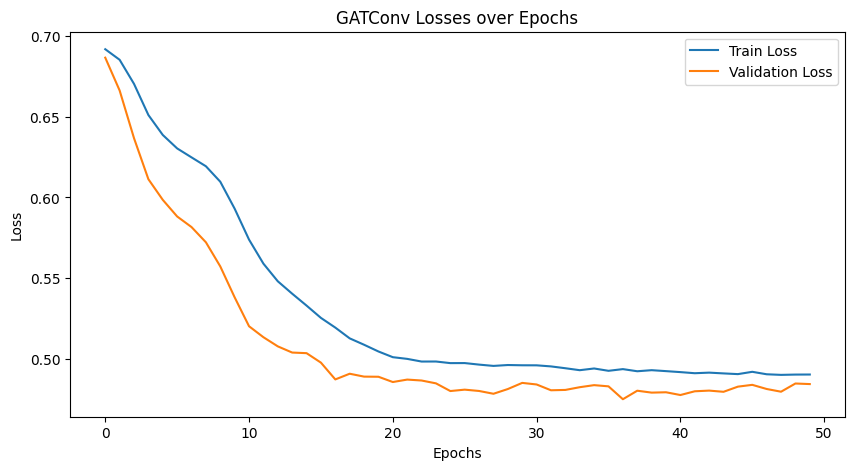

GATConv - Best Test Loss: 0.4748 achieved at Epoch: 037
Validation AUC for GATConv: 0.8690
-----------------------------
Training SAGEConv model on device: 'cpu'


100%|██████████| 9/9 [00:01<00:00,  5.20it/s]


SAGEConv - Epoch: 001, Train Loss: 0.6896 Test Loss: 0.6767


100%|██████████| 9/9 [00:01<00:00,  6.54it/s]


SAGEConv - Epoch: 002, Train Loss: 0.6648 Test Loss: 0.6141


100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


SAGEConv - Epoch: 003, Train Loss: 0.5984 Test Loss: 0.5111


100%|██████████| 9/9 [00:01<00:00,  4.84it/s]


SAGEConv - Epoch: 004, Train Loss: 0.5083 Test Loss: 0.4321


100%|██████████| 9/9 [00:01<00:00,  7.06it/s]


SAGEConv - Epoch: 005, Train Loss: 0.4321 Test Loss: 0.3754


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


SAGEConv - Epoch: 006, Train Loss: 0.3829 Test Loss: 0.3476


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


SAGEConv - Epoch: 007, Train Loss: 0.3620 Test Loss: 0.3344


100%|██████████| 9/9 [00:01<00:00,  4.95it/s]


SAGEConv - Epoch: 008, Train Loss: 0.3522 Test Loss: 0.3266


100%|██████████| 9/9 [00:01<00:00,  6.32it/s]


SAGEConv - Epoch: 009, Train Loss: 0.3461 Test Loss: 0.3223


100%|██████████| 9/9 [00:01<00:00,  6.89it/s]


SAGEConv - Epoch: 010, Train Loss: 0.3467 Test Loss: 0.3189


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


SAGEConv - Epoch: 011, Train Loss: 0.3395 Test Loss: 0.3147


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


SAGEConv - Epoch: 012, Train Loss: 0.3373 Test Loss: 0.3111


100%|██████████| 9/9 [00:01<00:00,  5.32it/s]


SAGEConv - Epoch: 013, Train Loss: 0.3340 Test Loss: 0.3093


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


SAGEConv - Epoch: 014, Train Loss: 0.3307 Test Loss: 0.3088


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


SAGEConv - Epoch: 015, Train Loss: 0.3277 Test Loss: 0.3029


100%|██████████| 9/9 [00:01<00:00,  6.59it/s]


SAGEConv - Epoch: 016, Train Loss: 0.3314 Test Loss: 0.3083


100%|██████████| 9/9 [00:02<00:00,  4.34it/s]


SAGEConv - Epoch: 017, Train Loss: 0.3233 Test Loss: 0.3031


100%|██████████| 9/9 [00:01<00:00,  5.23it/s]


SAGEConv - Epoch: 018, Train Loss: 0.3239 Test Loss: 0.3054


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


SAGEConv - Epoch: 019, Train Loss: 0.3162 Test Loss: 0.3022


100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


SAGEConv - Epoch: 020, Train Loss: 0.3217 Test Loss: 0.3016


100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


SAGEConv - Epoch: 021, Train Loss: 0.3135 Test Loss: 0.2990


100%|██████████| 9/9 [00:01<00:00,  7.11it/s]


SAGEConv - Epoch: 022, Train Loss: 0.3140 Test Loss: 0.2946


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


SAGEConv - Epoch: 023, Train Loss: 0.3125 Test Loss: 0.3011


100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


SAGEConv - Epoch: 024, Train Loss: 0.3145 Test Loss: 0.2950


100%|██████████| 9/9 [00:01<00:00,  6.54it/s]


SAGEConv - Epoch: 025, Train Loss: 0.3069 Test Loss: 0.2974


100%|██████████| 9/9 [00:01<00:00,  6.27it/s]


SAGEConv - Epoch: 026, Train Loss: 0.3102 Test Loss: 0.2952


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


SAGEConv - Epoch: 027, Train Loss: 0.3067 Test Loss: 0.2965


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


SAGEConv - Epoch: 028, Train Loss: 0.3063 Test Loss: 0.2932


100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


SAGEConv - Epoch: 029, Train Loss: 0.3083 Test Loss: 0.2959


100%|██████████| 9/9 [00:01<00:00,  4.92it/s]


SAGEConv - Epoch: 030, Train Loss: 0.3070 Test Loss: 0.2923


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


SAGEConv - Epoch: 031, Train Loss: 0.3035 Test Loss: 0.2940


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


SAGEConv - Epoch: 032, Train Loss: 0.3043 Test Loss: 0.2927


100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


SAGEConv - Epoch: 033, Train Loss: 0.2948 Test Loss: 0.2906


100%|██████████| 9/9 [00:01<00:00,  5.14it/s]


SAGEConv - Epoch: 034, Train Loss: 0.2983 Test Loss: 0.2896


100%|██████████| 9/9 [00:01<00:00,  5.37it/s]


SAGEConv - Epoch: 035, Train Loss: 0.2964 Test Loss: 0.2923


100%|██████████| 9/9 [00:01<00:00,  5.40it/s]


SAGEConv - Epoch: 036, Train Loss: 0.2964 Test Loss: 0.2917


100%|██████████| 9/9 [00:01<00:00,  5.37it/s]


SAGEConv - Epoch: 037, Train Loss: 0.2913 Test Loss: 0.2899


100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


SAGEConv - Epoch: 038, Train Loss: 0.2955 Test Loss: 0.2855


100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


SAGEConv - Epoch: 039, Train Loss: 0.2982 Test Loss: 0.2859


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


SAGEConv - Epoch: 040, Train Loss: 0.2946 Test Loss: 0.2870


100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


SAGEConv - Epoch: 041, Train Loss: 0.2930 Test Loss: 0.2864


100%|██████████| 9/9 [00:01<00:00,  6.49it/s]


SAGEConv - Epoch: 042, Train Loss: 0.2888 Test Loss: 0.2864


100%|██████████| 9/9 [00:01<00:00,  4.65it/s]


SAGEConv - Epoch: 043, Train Loss: 0.2895 Test Loss: 0.2877


100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


SAGEConv - Epoch: 044, Train Loss: 0.2866 Test Loss: 0.2858


100%|██████████| 9/9 [00:02<00:00,  3.70it/s]


SAGEConv - Epoch: 045, Train Loss: 0.2920 Test Loss: 0.2859


100%|██████████| 9/9 [00:01<00:00,  6.49it/s]


SAGEConv - Epoch: 046, Train Loss: 0.2908 Test Loss: 0.2881


100%|██████████| 9/9 [00:01<00:00,  6.38it/s]


SAGEConv - Epoch: 047, Train Loss: 0.2909 Test Loss: 0.2850


100%|██████████| 9/9 [00:02<00:00,  4.35it/s]


SAGEConv - Epoch: 048, Train Loss: 0.2867 Test Loss: 0.2873


100%|██████████| 9/9 [00:01<00:00,  5.46it/s]


SAGEConv - Epoch: 049, Train Loss: 0.2856 Test Loss: 0.2815


100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


SAGEConv - Epoch: 050, Train Loss: 0.2853 Test Loss: 0.2875


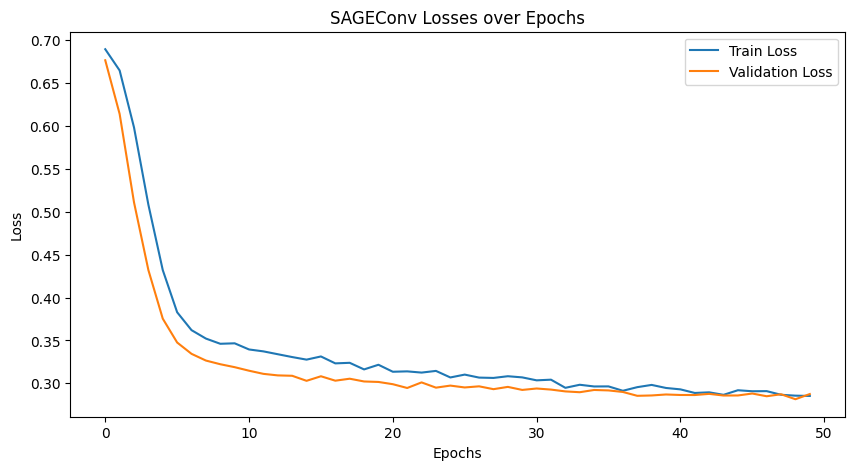

SAGEConv - Best Test Loss: 0.2815 achieved at Epoch: 049
Validation AUC for SAGEConv: 0.8395
-----------------------------
Training GATConv model on device: 'cpu'


100%|██████████| 9/9 [00:01<00:00,  5.19it/s]


GATConv - Epoch: 001, Train Loss: 0.6920 Test Loss: 0.6877


100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


GATConv - Epoch: 002, Train Loss: 0.6831 Test Loss: 0.6686


100%|██████████| 9/9 [00:02<00:00,  4.50it/s]


GATConv - Epoch: 003, Train Loss: 0.6571 Test Loss: 0.6115


100%|██████████| 9/9 [00:02<00:00,  4.46it/s]


GATConv - Epoch: 004, Train Loss: 0.6204 Test Loss: 0.5495


100%|██████████| 9/9 [00:01<00:00,  6.51it/s]


GATConv - Epoch: 005, Train Loss: 0.5936 Test Loss: 0.5099


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


GATConv - Epoch: 006, Train Loss: 0.5742 Test Loss: 0.4924


100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


GATConv - Epoch: 007, Train Loss: 0.5617 Test Loss: 0.4786


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


GATConv - Epoch: 008, Train Loss: 0.5510 Test Loss: 0.4663


100%|██████████| 9/9 [00:01<00:00,  4.66it/s]


GATConv - Epoch: 009, Train Loss: 0.5336 Test Loss: 0.4438


100%|██████████| 9/9 [00:02<00:00,  4.38it/s]


GATConv - Epoch: 010, Train Loss: 0.5036 Test Loss: 0.4122


100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


GATConv - Epoch: 011, Train Loss: 0.4675 Test Loss: 0.3847


100%|██████████| 9/9 [00:01<00:00,  6.30it/s]


GATConv - Epoch: 012, Train Loss: 0.4353 Test Loss: 0.3636


100%|██████████| 9/9 [00:02<00:00,  4.46it/s]


GATConv - Epoch: 013, Train Loss: 0.4126 Test Loss: 0.3517


100%|██████████| 9/9 [00:01<00:00,  6.39it/s]


GATConv - Epoch: 014, Train Loss: 0.3885 Test Loss: 0.3422


100%|██████████| 9/9 [00:01<00:00,  4.79it/s]


GATConv - Epoch: 015, Train Loss: 0.3772 Test Loss: 0.3346


100%|██████████| 9/9 [00:01<00:00,  5.44it/s]


GATConv - Epoch: 016, Train Loss: 0.3668 Test Loss: 0.3298


100%|██████████| 9/9 [00:01<00:00,  5.00it/s]


GATConv - Epoch: 017, Train Loss: 0.3617 Test Loss: 0.3240


100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


GATConv - Epoch: 018, Train Loss: 0.3563 Test Loss: 0.3220


100%|██████████| 9/9 [00:01<00:00,  6.15it/s]


GATConv - Epoch: 019, Train Loss: 0.3566 Test Loss: 0.3209


100%|██████████| 9/9 [00:02<00:00,  4.45it/s]


GATConv - Epoch: 020, Train Loss: 0.3558 Test Loss: 0.3235


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


GATConv - Epoch: 021, Train Loss: 0.3551 Test Loss: 0.3149


100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


GATConv - Epoch: 022, Train Loss: 0.3571 Test Loss: 0.3207


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


GATConv - Epoch: 023, Train Loss: 0.3561 Test Loss: 0.3317


100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


GATConv - Epoch: 024, Train Loss: 0.3514 Test Loss: 0.3332


100%|██████████| 9/9 [00:02<00:00,  4.44it/s]


GATConv - Epoch: 025, Train Loss: 0.3571 Test Loss: 0.3261


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


GATConv - Epoch: 026, Train Loss: 0.3524 Test Loss: 0.3209


100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


GATConv - Epoch: 027, Train Loss: 0.3504 Test Loss: 0.3190


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


GATConv - Epoch: 028, Train Loss: 0.3514 Test Loss: 0.3235


100%|██████████| 9/9 [00:01<00:00,  4.94it/s]


GATConv - Epoch: 029, Train Loss: 0.3495 Test Loss: 0.3252


100%|██████████| 9/9 [00:01<00:00,  6.64it/s]


GATConv - Epoch: 030, Train Loss: 0.3495 Test Loss: 0.3413


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


GATConv - Epoch: 031, Train Loss: 0.3495 Test Loss: 0.3326


100%|██████████| 9/9 [00:01<00:00,  6.47it/s]


GATConv - Epoch: 032, Train Loss: 0.3492 Test Loss: 0.3367


100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


GATConv - Epoch: 033, Train Loss: 0.3473 Test Loss: 0.3366


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


GATConv - Epoch: 034, Train Loss: 0.3453 Test Loss: 0.3431


100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


GATConv - Epoch: 035, Train Loss: 0.3480 Test Loss: 0.3358


100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


GATConv - Epoch: 036, Train Loss: 0.3498 Test Loss: 0.3381


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


GATConv - Epoch: 037, Train Loss: 0.3449 Test Loss: 0.3249


100%|██████████| 9/9 [00:01<00:00,  6.64it/s]


GATConv - Epoch: 038, Train Loss: 0.3462 Test Loss: 0.3190


100%|██████████| 9/9 [00:01<00:00,  4.91it/s]


GATConv - Epoch: 039, Train Loss: 0.3488 Test Loss: 0.3184


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


GATConv - Epoch: 040, Train Loss: 0.3487 Test Loss: 0.3281


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


GATConv - Epoch: 041, Train Loss: 0.3435 Test Loss: 0.3268
Early stopping!


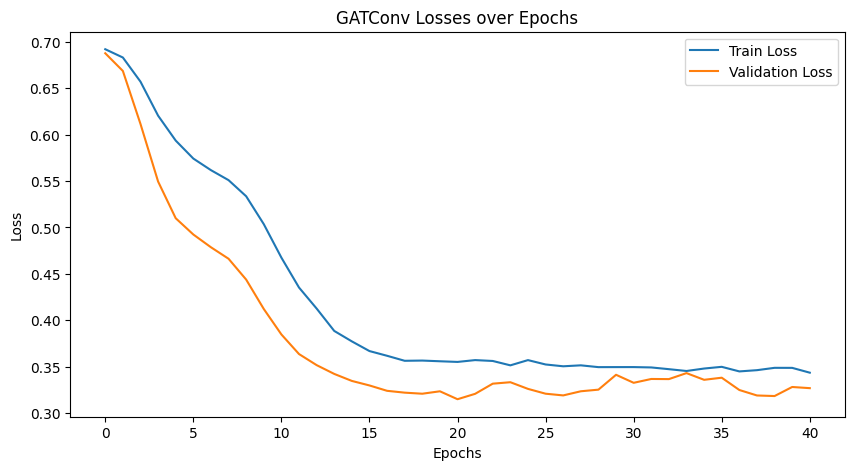

GATConv - Best Test Loss: 0.3149 achieved at Epoch: 021
Validation AUC for GATConv: 0.8505
-----------------------------
Training SAGEConv model on device: 'cpu'


100%|██████████| 9/9 [00:01<00:00,  8.97it/s]


SAGEConv - Epoch: 001, Train Loss: 0.6862 Test Loss: 0.6660


100%|██████████| 9/9 [00:01<00:00,  4.88it/s]


SAGEConv - Epoch: 002, Train Loss: 0.6563 Test Loss: 0.5994


100%|██████████| 9/9 [00:01<00:00,  6.90it/s]


SAGEConv - Epoch: 003, Train Loss: 0.5890 Test Loss: 0.4912


100%|██████████| 9/9 [00:01<00:00,  4.80it/s]


SAGEConv - Epoch: 004, Train Loss: 0.5036 Test Loss: 0.4015


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


SAGEConv - Epoch: 005, Train Loss: 0.4420 Test Loss: 0.3631


100%|██████████| 9/9 [00:01<00:00,  8.25it/s]


SAGEConv - Epoch: 006, Train Loss: 0.4079 Test Loss: 0.3429


100%|██████████| 9/9 [00:01<00:00,  7.41it/s]


SAGEConv - Epoch: 007, Train Loss: 0.3816 Test Loss: 0.3268


100%|██████████| 9/9 [00:01<00:00,  8.76it/s]


SAGEConv - Epoch: 008, Train Loss: 0.3605 Test Loss: 0.3050


100%|██████████| 9/9 [00:01<00:00,  5.27it/s]


SAGEConv - Epoch: 009, Train Loss: 0.3452 Test Loss: 0.2971


100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


SAGEConv - Epoch: 010, Train Loss: 0.3363 Test Loss: 0.2882


100%|██████████| 9/9 [00:01<00:00,  7.84it/s]


SAGEConv - Epoch: 011, Train Loss: 0.3259 Test Loss: 0.2826


100%|██████████| 9/9 [00:01<00:00,  8.88it/s]


SAGEConv - Epoch: 012, Train Loss: 0.3198 Test Loss: 0.2702


100%|██████████| 9/9 [00:01<00:00,  5.11it/s]


SAGEConv - Epoch: 013, Train Loss: 0.3073 Test Loss: 0.2713


100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


SAGEConv - Epoch: 014, Train Loss: 0.3058 Test Loss: 0.2695


100%|██████████| 9/9 [00:01<00:00,  7.78it/s]


SAGEConv - Epoch: 015, Train Loss: 0.3011 Test Loss: 0.2620


100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


SAGEConv - Epoch: 016, Train Loss: 0.2975 Test Loss: 0.2626


100%|██████████| 9/9 [00:01<00:00,  8.91it/s]


SAGEConv - Epoch: 017, Train Loss: 0.2943 Test Loss: 0.2497


100%|██████████| 9/9 [00:00<00:00,  9.04it/s]


SAGEConv - Epoch: 018, Train Loss: 0.2824 Test Loss: 0.2502


100%|██████████| 9/9 [00:01<00:00,  7.56it/s]


SAGEConv - Epoch: 019, Train Loss: 0.2873 Test Loss: 0.2468


100%|██████████| 9/9 [00:01<00:00,  5.48it/s]


SAGEConv - Epoch: 020, Train Loss: 0.2797 Test Loss: 0.2384


100%|██████████| 9/9 [00:01<00:00,  9.00it/s]


SAGEConv - Epoch: 021, Train Loss: 0.2801 Test Loss: 0.2419


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


SAGEConv - Epoch: 022, Train Loss: 0.2677 Test Loss: 0.2382


100%|██████████| 9/9 [00:01<00:00,  6.68it/s]


SAGEConv - Epoch: 023, Train Loss: 0.2652 Test Loss: 0.2351


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


SAGEConv - Epoch: 024, Train Loss: 0.2644 Test Loss: 0.2330


100%|██████████| 9/9 [00:01<00:00,  6.41it/s]


SAGEConv - Epoch: 025, Train Loss: 0.2706 Test Loss: 0.2319


100%|██████████| 9/9 [00:01<00:00,  9.00it/s]


SAGEConv - Epoch: 026, Train Loss: 0.2568 Test Loss: 0.2275


100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


SAGEConv - Epoch: 027, Train Loss: 0.2571 Test Loss: 0.2184


100%|██████████| 9/9 [00:01<00:00,  8.44it/s]


SAGEConv - Epoch: 028, Train Loss: 0.2537 Test Loss: 0.2207


100%|██████████| 9/9 [00:00<00:00,  9.28it/s]


SAGEConv - Epoch: 029, Train Loss: 0.2484 Test Loss: 0.2165


100%|██████████| 9/9 [00:00<00:00,  9.14it/s]


SAGEConv - Epoch: 030, Train Loss: 0.2475 Test Loss: 0.2148


100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


SAGEConv - Epoch: 031, Train Loss: 0.2416 Test Loss: 0.2137


100%|██████████| 9/9 [00:01<00:00,  7.30it/s]


SAGEConv - Epoch: 032, Train Loss: 0.2394 Test Loss: 0.2166


100%|██████████| 9/9 [00:00<00:00,  9.24it/s]


SAGEConv - Epoch: 033, Train Loss: 0.2464 Test Loss: 0.2065


100%|██████████| 9/9 [00:01<00:00,  5.36it/s]


SAGEConv - Epoch: 034, Train Loss: 0.2409 Test Loss: 0.2100


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


SAGEConv - Epoch: 035, Train Loss: 0.2374 Test Loss: 0.2096


100%|██████████| 9/9 [00:01<00:00,  8.12it/s]


SAGEConv - Epoch: 036, Train Loss: 0.2402 Test Loss: 0.2125


100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


SAGEConv - Epoch: 037, Train Loss: 0.2407 Test Loss: 0.2046


100%|██████████| 9/9 [00:01<00:00,  4.98it/s]


SAGEConv - Epoch: 038, Train Loss: 0.2356 Test Loss: 0.2057


100%|██████████| 9/9 [00:01<00:00,  7.68it/s]


SAGEConv - Epoch: 039, Train Loss: 0.2301 Test Loss: 0.2024


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


SAGEConv - Epoch: 040, Train Loss: 0.2268 Test Loss: 0.2094


100%|██████████| 9/9 [00:01<00:00,  8.82it/s]


SAGEConv - Epoch: 041, Train Loss: 0.2270 Test Loss: 0.2035


100%|██████████| 9/9 [00:01<00:00,  8.13it/s]


SAGEConv - Epoch: 042, Train Loss: 0.2339 Test Loss: 0.2007


100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


SAGEConv - Epoch: 043, Train Loss: 0.2302 Test Loss: 0.2028


100%|██████████| 9/9 [00:01<00:00,  5.31it/s]


SAGEConv - Epoch: 044, Train Loss: 0.2253 Test Loss: 0.2010


100%|██████████| 9/9 [00:01<00:00,  8.45it/s]


SAGEConv - Epoch: 045, Train Loss: 0.2299 Test Loss: 0.2063


100%|██████████| 9/9 [00:00<00:00,  9.26it/s]


SAGEConv - Epoch: 046, Train Loss: 0.2234 Test Loss: 0.2078


100%|██████████| 9/9 [00:00<00:00,  9.11it/s]


SAGEConv - Epoch: 047, Train Loss: 0.2249 Test Loss: 0.2012


100%|██████████| 9/9 [00:01<00:00,  5.31it/s]


SAGEConv - Epoch: 048, Train Loss: 0.2254 Test Loss: 0.1987


100%|██████████| 9/9 [00:01<00:00,  8.77it/s]


SAGEConv - Epoch: 049, Train Loss: 0.2191 Test Loss: 0.2071


100%|██████████| 9/9 [00:00<00:00,  9.02it/s]


SAGEConv - Epoch: 050, Train Loss: 0.2198 Test Loss: 0.2133


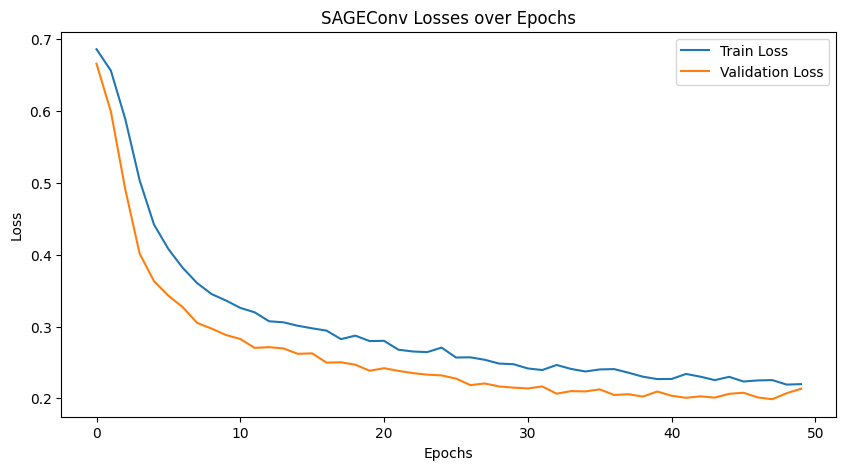

SAGEConv - Best Test Loss: 0.1987 achieved at Epoch: 048
Validation AUC for SAGEConv: 0.8670
-----------------------------
Training GATConv model on device: 'cpu'


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


GATConv - Epoch: 001, Train Loss: 0.6892 Test Loss: 0.6787


100%|██████████| 9/9 [00:01<00:00,  6.87it/s]


GATConv - Epoch: 002, Train Loss: 0.6708 Test Loss: 0.6495


100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


GATConv - Epoch: 003, Train Loss: 0.6372 Test Loss: 0.6006


100%|██████████| 9/9 [00:01<00:00,  4.52it/s]


GATConv - Epoch: 004, Train Loss: 0.6057 Test Loss: 0.5646


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


GATConv - Epoch: 005, Train Loss: 0.5889 Test Loss: 0.5332


100%|██████████| 9/9 [00:01<00:00,  6.43it/s]


GATConv - Epoch: 006, Train Loss: 0.5784 Test Loss: 0.5224


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


GATConv - Epoch: 007, Train Loss: 0.5670 Test Loss: 0.5114


100%|██████████| 9/9 [00:01<00:00,  7.09it/s]


GATConv - Epoch: 008, Train Loss: 0.5626 Test Loss: 0.4999


100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


GATConv - Epoch: 009, Train Loss: 0.5545 Test Loss: 0.4924


100%|██████████| 9/9 [00:01<00:00,  6.18it/s]


GATConv - Epoch: 010, Train Loss: 0.5446 Test Loss: 0.4859


100%|██████████| 9/9 [00:01<00:00,  7.09it/s]


GATConv - Epoch: 011, Train Loss: 0.5368 Test Loss: 0.4718


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


GATConv - Epoch: 012, Train Loss: 0.5222 Test Loss: 0.4545


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


GATConv - Epoch: 013, Train Loss: 0.5034 Test Loss: 0.4330


100%|██████████| 9/9 [00:01<00:00,  7.00it/s]


GATConv - Epoch: 014, Train Loss: 0.4888 Test Loss: 0.4188


100%|██████████| 9/9 [00:02<00:00,  4.49it/s]


GATConv - Epoch: 015, Train Loss: 0.4703 Test Loss: 0.3992


100%|██████████| 9/9 [00:01<00:00,  6.40it/s]


GATConv - Epoch: 016, Train Loss: 0.4541 Test Loss: 0.3832


100%|██████████| 9/9 [00:01<00:00,  4.91it/s]


GATConv - Epoch: 017, Train Loss: 0.4400 Test Loss: 0.3658


100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


GATConv - Epoch: 018, Train Loss: 0.4295 Test Loss: 0.3585


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


GATConv - Epoch: 019, Train Loss: 0.4153 Test Loss: 0.3500


100%|██████████| 9/9 [00:02<00:00,  4.48it/s]


GATConv - Epoch: 020, Train Loss: 0.4271 Test Loss: 0.3501


100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


GATConv - Epoch: 021, Train Loss: 0.3987 Test Loss: 0.3400


100%|██████████| 9/9 [00:01<00:00,  6.05it/s]


GATConv - Epoch: 022, Train Loss: 0.3972 Test Loss: 0.3332


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


GATConv - Epoch: 023, Train Loss: 0.3848 Test Loss: 0.3286


100%|██████████| 9/9 [00:01<00:00,  6.82it/s]


GATConv - Epoch: 024, Train Loss: 0.3761 Test Loss: 0.3312


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


GATConv - Epoch: 025, Train Loss: 0.3702 Test Loss: 0.3235


100%|██████████| 9/9 [00:01<00:00,  6.79it/s]


GATConv - Epoch: 026, Train Loss: 0.3646 Test Loss: 0.3257


100%|██████████| 9/9 [00:01<00:00,  7.17it/s]


GATConv - Epoch: 027, Train Loss: 0.3611 Test Loss: 0.3241


100%|██████████| 9/9 [00:01<00:00,  4.68it/s]


GATConv - Epoch: 028, Train Loss: 0.3525 Test Loss: 0.3162


100%|██████████| 9/9 [00:01<00:00,  6.82it/s]


GATConv - Epoch: 029, Train Loss: 0.3493 Test Loss: 0.3133


100%|██████████| 9/9 [00:01<00:00,  6.57it/s]


GATConv - Epoch: 030, Train Loss: 0.3487 Test Loss: 0.3075


100%|██████████| 9/9 [00:01<00:00,  4.59it/s]


GATConv - Epoch: 031, Train Loss: 0.3395 Test Loss: 0.3186


100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


GATConv - Epoch: 032, Train Loss: 0.3404 Test Loss: 0.3132


100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


GATConv - Epoch: 033, Train Loss: 0.3335 Test Loss: 0.3097


100%|██████████| 9/9 [00:02<00:00,  4.47it/s]


GATConv - Epoch: 034, Train Loss: 0.3297 Test Loss: 0.2987


100%|██████████| 9/9 [00:01<00:00,  6.80it/s]


GATConv - Epoch: 035, Train Loss: 0.3264 Test Loss: 0.3065


100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


GATConv - Epoch: 036, Train Loss: 0.3280 Test Loss: 0.3014


100%|██████████| 9/9 [00:02<00:00,  4.43it/s]


GATConv - Epoch: 037, Train Loss: 0.3226 Test Loss: 0.3005


100%|██████████| 9/9 [00:01<00:00,  6.87it/s]


GATConv - Epoch: 038, Train Loss: 0.3214 Test Loss: 0.3087


100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


GATConv - Epoch: 039, Train Loss: 0.3173 Test Loss: 0.3104


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


GATConv - Epoch: 040, Train Loss: 0.3179 Test Loss: 0.3046


100%|██████████| 9/9 [00:01<00:00,  6.85it/s]


GATConv - Epoch: 041, Train Loss: 0.3157 Test Loss: 0.3075


100%|██████████| 9/9 [00:01<00:00,  6.73it/s]


GATConv - Epoch: 042, Train Loss: 0.3133 Test Loss: 0.3051


100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


GATConv - Epoch: 043, Train Loss: 0.3145 Test Loss: 0.3002


100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


GATConv - Epoch: 044, Train Loss: 0.3134 Test Loss: 0.3031


100%|██████████| 9/9 [00:01<00:00,  6.99it/s]


GATConv - Epoch: 045, Train Loss: 0.3126 Test Loss: 0.2955


100%|██████████| 9/9 [00:01<00:00,  6.94it/s]


GATConv - Epoch: 046, Train Loss: 0.3100 Test Loss: 0.3042


100%|██████████| 9/9 [00:01<00:00,  4.82it/s]


GATConv - Epoch: 047, Train Loss: 0.3120 Test Loss: 0.3092


100%|██████████| 9/9 [00:01<00:00,  6.92it/s]


GATConv - Epoch: 048, Train Loss: 0.3114 Test Loss: 0.3032


100%|██████████| 9/9 [00:01<00:00,  7.11it/s]


GATConv - Epoch: 049, Train Loss: 0.3077 Test Loss: 0.2927


100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


GATConv - Epoch: 050, Train Loss: 0.3074 Test Loss: 0.2992


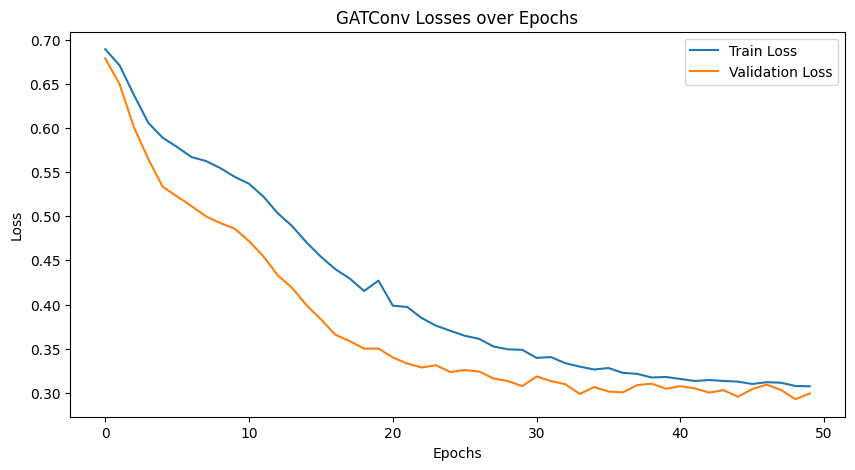

GATConv - Best Test Loss: 0.2927 achieved at Epoch: 049
Validation AUC for GATConv: 0.8530
-----------------------------
Training SAGEConv model on device: 'cpu'


100%|██████████| 9/9 [00:01<00:00,  8.29it/s]


SAGEConv - Epoch: 001, Train Loss: 0.6863 Test Loss: 0.6654


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


SAGEConv - Epoch: 002, Train Loss: 0.6573 Test Loss: 0.6036


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


SAGEConv - Epoch: 003, Train Loss: 0.5928 Test Loss: 0.5052


100%|██████████| 9/9 [00:01<00:00,  8.97it/s]


SAGEConv - Epoch: 004, Train Loss: 0.5053 Test Loss: 0.4160


100%|██████████| 9/9 [00:01<00:00,  8.03it/s]


SAGEConv - Epoch: 005, Train Loss: 0.4356 Test Loss: 0.3699


100%|██████████| 9/9 [00:01<00:00,  6.86it/s]


SAGEConv - Epoch: 006, Train Loss: 0.3958 Test Loss: 0.3408


100%|██████████| 9/9 [00:01<00:00,  7.68it/s]


SAGEConv - Epoch: 007, Train Loss: 0.3712 Test Loss: 0.3181


100%|██████████| 9/9 [00:01<00:00,  8.99it/s]


SAGEConv - Epoch: 008, Train Loss: 0.3467 Test Loss: 0.2954


100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


SAGEConv - Epoch: 009, Train Loss: 0.3373 Test Loss: 0.2851


100%|██████████| 9/9 [00:01<00:00,  7.32it/s]


SAGEConv - Epoch: 010, Train Loss: 0.3235 Test Loss: 0.2846


100%|██████████| 9/9 [00:01<00:00,  7.53it/s]


SAGEConv - Epoch: 011, Train Loss: 0.3169 Test Loss: 0.2758


100%|██████████| 9/9 [00:01<00:00,  8.71it/s]


SAGEConv - Epoch: 012, Train Loss: 0.3060 Test Loss: 0.2639


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


SAGEConv - Epoch: 013, Train Loss: 0.3029 Test Loss: 0.2630


100%|██████████| 9/9 [00:01<00:00,  8.88it/s]


SAGEConv - Epoch: 014, Train Loss: 0.3017 Test Loss: 0.2573


100%|██████████| 9/9 [00:01<00:00,  6.14it/s]


SAGEConv - Epoch: 015, Train Loss: 0.2933 Test Loss: 0.2544


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


SAGEConv - Epoch: 016, Train Loss: 0.2900 Test Loss: 0.2516


100%|██████████| 9/9 [00:01<00:00,  8.75it/s]


SAGEConv - Epoch: 017, Train Loss: 0.2839 Test Loss: 0.2431


100%|██████████| 9/9 [00:01<00:00,  6.59it/s]


SAGEConv - Epoch: 018, Train Loss: 0.2871 Test Loss: 0.2440


100%|██████████| 9/9 [00:01<00:00,  5.23it/s]


SAGEConv - Epoch: 019, Train Loss: 0.2811 Test Loss: 0.2422


100%|██████████| 9/9 [00:01<00:00,  7.97it/s]


SAGEConv - Epoch: 020, Train Loss: 0.2770 Test Loss: 0.2411


100%|██████████| 9/9 [00:01<00:00,  8.08it/s]


SAGEConv - Epoch: 021, Train Loss: 0.2737 Test Loss: 0.2430


100%|██████████| 9/9 [00:01<00:00,  8.97it/s]


SAGEConv - Epoch: 022, Train Loss: 0.2679 Test Loss: 0.2358


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


SAGEConv - Epoch: 023, Train Loss: 0.2673 Test Loss: 0.2345


100%|██████████| 9/9 [00:01<00:00,  7.23it/s]


SAGEConv - Epoch: 024, Train Loss: 0.2643 Test Loss: 0.2332


100%|██████████| 9/9 [00:01<00:00,  7.51it/s]


SAGEConv - Epoch: 025, Train Loss: 0.2603 Test Loss: 0.2321


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


SAGEConv - Epoch: 026, Train Loss: 0.2594 Test Loss: 0.2285


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


SAGEConv - Epoch: 027, Train Loss: 0.2550 Test Loss: 0.2216


100%|██████████| 9/9 [00:00<00:00,  9.06it/s]


SAGEConv - Epoch: 028, Train Loss: 0.2494 Test Loss: 0.2236


100%|██████████| 9/9 [00:01<00:00,  6.74it/s]


SAGEConv - Epoch: 029, Train Loss: 0.2489 Test Loss: 0.2148


100%|██████████| 9/9 [00:00<00:00,  9.01it/s]


SAGEConv - Epoch: 030, Train Loss: 0.2478 Test Loss: 0.2088


100%|██████████| 9/9 [00:01<00:00,  7.22it/s]


SAGEConv - Epoch: 031, Train Loss: 0.2394 Test Loss: 0.2136


100%|██████████| 9/9 [00:02<00:00,  3.72it/s]


SAGEConv - Epoch: 032, Train Loss: 0.2399 Test Loss: 0.2093


100%|██████████| 9/9 [00:01<00:00,  8.82it/s]


SAGEConv - Epoch: 033, Train Loss: 0.2420 Test Loss: 0.2133


100%|██████████| 9/9 [00:01<00:00,  8.20it/s]


SAGEConv - Epoch: 034, Train Loss: 0.2403 Test Loss: 0.2097


100%|██████████| 9/9 [00:01<00:00,  7.43it/s]


SAGEConv - Epoch: 035, Train Loss: 0.2393 Test Loss: 0.2063


100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


SAGEConv - Epoch: 036, Train Loss: 0.2407 Test Loss: 0.2089


100%|██████████| 9/9 [00:01<00:00,  8.50it/s]


SAGEConv - Epoch: 037, Train Loss: 0.2315 Test Loss: 0.2087


100%|██████████| 9/9 [00:01<00:00,  8.63it/s]


SAGEConv - Epoch: 038, Train Loss: 0.2303 Test Loss: 0.2050


100%|██████████| 9/9 [00:01<00:00,  6.73it/s]


SAGEConv - Epoch: 039, Train Loss: 0.2344 Test Loss: 0.2050


100%|██████████| 9/9 [00:01<00:00,  7.87it/s]


SAGEConv - Epoch: 040, Train Loss: 0.2294 Test Loss: 0.2048


100%|██████████| 9/9 [00:00<00:00,  9.03it/s]


SAGEConv - Epoch: 041, Train Loss: 0.2268 Test Loss: 0.2117


100%|██████████| 9/9 [00:00<00:00,  9.15it/s]


SAGEConv - Epoch: 042, Train Loss: 0.2339 Test Loss: 0.2055


100%|██████████| 9/9 [00:01<00:00,  4.65it/s]


SAGEConv - Epoch: 043, Train Loss: 0.2289 Test Loss: 0.2057


100%|██████████| 9/9 [00:00<00:00,  9.16it/s]


SAGEConv - Epoch: 044, Train Loss: 0.2248 Test Loss: 0.2057


100%|██████████| 9/9 [00:00<00:00,  9.19it/s]


SAGEConv - Epoch: 045, Train Loss: 0.2220 Test Loss: 0.2058


100%|██████████| 9/9 [00:00<00:00,  9.04it/s]


SAGEConv - Epoch: 046, Train Loss: 0.2270 Test Loss: 0.2039


100%|██████████| 9/9 [00:01<00:00,  4.74it/s]


SAGEConv - Epoch: 047, Train Loss: 0.2242 Test Loss: 0.2034


100%|██████████| 9/9 [00:01<00:00,  8.80it/s]


SAGEConv - Epoch: 048, Train Loss: 0.2223 Test Loss: 0.2113


100%|██████████| 9/9 [00:01<00:00,  8.45it/s]


SAGEConv - Epoch: 049, Train Loss: 0.2229 Test Loss: 0.2060


100%|██████████| 9/9 [00:00<00:00,  9.27it/s]


SAGEConv - Epoch: 050, Train Loss: 0.2178 Test Loss: 0.2075


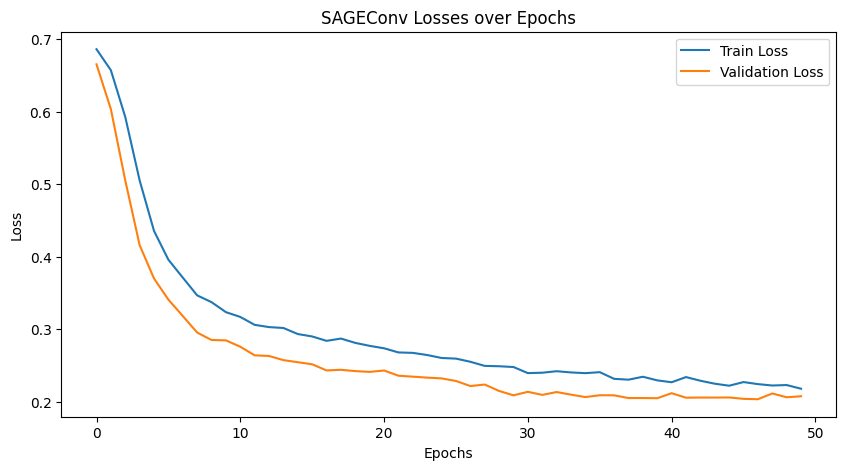

SAGEConv - Best Test Loss: 0.2034 achieved at Epoch: 047
Validation AUC for SAGEConv: 0.8775
-----------------------------
Training GATConv model on device: 'cpu'


100%|██████████| 9/9 [00:01<00:00,  6.83it/s]


GATConv - Epoch: 001, Train Loss: 0.6874 Test Loss: 0.6724


100%|██████████| 9/9 [00:01<00:00,  6.69it/s]


GATConv - Epoch: 002, Train Loss: 0.6670 Test Loss: 0.6429


100%|██████████| 9/9 [00:03<00:00,  3.00it/s]


GATConv - Epoch: 003, Train Loss: 0.6361 Test Loss: 0.5858


100%|██████████| 9/9 [00:01<00:00,  7.03it/s]


GATConv - Epoch: 004, Train Loss: 0.6082 Test Loss: 0.5560


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


GATConv - Epoch: 005, Train Loss: 0.5905 Test Loss: 0.5280


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


GATConv - Epoch: 006, Train Loss: 0.5769 Test Loss: 0.5057


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


GATConv - Epoch: 007, Train Loss: 0.5679 Test Loss: 0.4966


100%|██████████| 9/9 [00:02<00:00,  3.08it/s]


GATConv - Epoch: 008, Train Loss: 0.5599 Test Loss: 0.4855


100%|██████████| 9/9 [00:01<00:00,  6.60it/s]


GATConv - Epoch: 009, Train Loss: 0.5501 Test Loss: 0.4739


100%|██████████| 9/9 [00:02<00:00,  3.72it/s]


GATConv - Epoch: 010, Train Loss: 0.5398 Test Loss: 0.4614


100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


GATConv - Epoch: 011, Train Loss: 0.5247 Test Loss: 0.4433


100%|██████████| 9/9 [00:01<00:00,  6.30it/s]


GATConv - Epoch: 012, Train Loss: 0.5065 Test Loss: 0.4232


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


GATConv - Epoch: 013, Train Loss: 0.4822 Test Loss: 0.3995


100%|██████████| 9/9 [00:01<00:00,  4.77it/s]


GATConv - Epoch: 014, Train Loss: 0.4571 Test Loss: 0.3783


100%|██████████| 9/9 [00:02<00:00,  3.39it/s]


GATConv - Epoch: 015, Train Loss: 0.4343 Test Loss: 0.3611


100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


GATConv - Epoch: 016, Train Loss: 0.4148 Test Loss: 0.3428


100%|██████████| 9/9 [00:01<00:00,  4.98it/s]


GATConv - Epoch: 017, Train Loss: 0.3998 Test Loss: 0.3399


100%|██████████| 9/9 [00:01<00:00,  6.27it/s]


GATConv - Epoch: 018, Train Loss: 0.3907 Test Loss: 0.3369


100%|██████████| 9/9 [00:01<00:00,  6.41it/s]


GATConv - Epoch: 019, Train Loss: 0.3886 Test Loss: 0.3467


100%|██████████| 9/9 [00:01<00:00,  4.94it/s]


GATConv - Epoch: 020, Train Loss: 0.3789 Test Loss: 0.3340


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


GATConv - Epoch: 021, Train Loss: 0.3699 Test Loss: 0.3348


100%|██████████| 9/9 [00:01<00:00,  7.00it/s]


GATConv - Epoch: 022, Train Loss: 0.3606 Test Loss: 0.3510


100%|██████████| 9/9 [00:02<00:00,  4.37it/s]


GATConv - Epoch: 023, Train Loss: 0.3563 Test Loss: 0.3415


100%|██████████| 9/9 [00:01<00:00,  6.62it/s]


GATConv - Epoch: 024, Train Loss: 0.3486 Test Loss: 0.3139


100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


GATConv - Epoch: 025, Train Loss: 0.3453 Test Loss: 0.3295


100%|██████████| 9/9 [00:02<00:00,  4.39it/s]


GATConv - Epoch: 026, Train Loss: 0.3412 Test Loss: 0.3318


100%|██████████| 9/9 [00:01<00:00,  6.52it/s]


GATConv - Epoch: 027, Train Loss: 0.3375 Test Loss: 0.3266


100%|██████████| 9/9 [00:01<00:00,  6.74it/s]


GATConv - Epoch: 028, Train Loss: 0.3347 Test Loss: 0.3283


100%|██████████| 9/9 [00:02<00:00,  4.37it/s]


GATConv - Epoch: 029, Train Loss: 0.3308 Test Loss: 0.3326


100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


GATConv - Epoch: 030, Train Loss: 0.3312 Test Loss: 0.3285


100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


GATConv - Epoch: 031, Train Loss: 0.3288 Test Loss: 0.3257


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


GATConv - Epoch: 032, Train Loss: 0.3285 Test Loss: 0.3260


100%|██████████| 9/9 [00:01<00:00,  5.06it/s]


GATConv - Epoch: 033, Train Loss: 0.3277 Test Loss: 0.3338


100%|██████████| 9/9 [00:01<00:00,  4.70it/s]


GATConv - Epoch: 034, Train Loss: 0.3260 Test Loss: 0.3278


100%|██████████| 9/9 [00:01<00:00,  6.76it/s]


GATConv - Epoch: 035, Train Loss: 0.3272 Test Loss: 0.3420


100%|██████████| 9/9 [00:01<00:00,  4.78it/s]


GATConv - Epoch: 036, Train Loss: 0.3245 Test Loss: 0.3163


100%|██████████| 9/9 [00:01<00:00,  7.00it/s]


GATConv - Epoch: 037, Train Loss: 0.3238 Test Loss: 0.3127


100%|██████████| 9/9 [00:01<00:00,  6.02it/s]


GATConv - Epoch: 038, Train Loss: 0.3233 Test Loss: 0.3101


100%|██████████| 9/9 [00:01<00:00,  4.80it/s]


GATConv - Epoch: 039, Train Loss: 0.3222 Test Loss: 0.3189


100%|██████████| 9/9 [00:01<00:00,  7.04it/s]


GATConv - Epoch: 040, Train Loss: 0.3215 Test Loss: 0.3179


100%|██████████| 9/9 [00:01<00:00,  6.97it/s]


GATConv - Epoch: 041, Train Loss: 0.3221 Test Loss: 0.3217


100%|██████████| 9/9 [00:01<00:00,  4.94it/s]


GATConv - Epoch: 042, Train Loss: 0.3184 Test Loss: 0.3127


100%|██████████| 9/9 [00:01<00:00,  6.89it/s]


GATConv - Epoch: 043, Train Loss: 0.3196 Test Loss: 0.3229


100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


GATConv - Epoch: 044, Train Loss: 0.3234 Test Loss: 0.3302


100%|██████████| 9/9 [00:01<00:00,  6.31it/s]


GATConv - Epoch: 045, Train Loss: 0.3198 Test Loss: 0.3256


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


GATConv - Epoch: 046, Train Loss: 0.3159 Test Loss: 0.3185


100%|██████████| 9/9 [00:01<00:00,  5.06it/s]


GATConv - Epoch: 047, Train Loss: 0.3179 Test Loss: 0.3188


100%|██████████| 9/9 [00:01<00:00,  6.33it/s]


GATConv - Epoch: 048, Train Loss: 0.3171 Test Loss: 0.3097


100%|██████████| 9/9 [00:01<00:00,  6.70it/s]


GATConv - Epoch: 049, Train Loss: 0.3141 Test Loss: 0.3133


100%|██████████| 9/9 [00:01<00:00,  4.85it/s]


GATConv - Epoch: 050, Train Loss: 0.3158 Test Loss: 0.3208


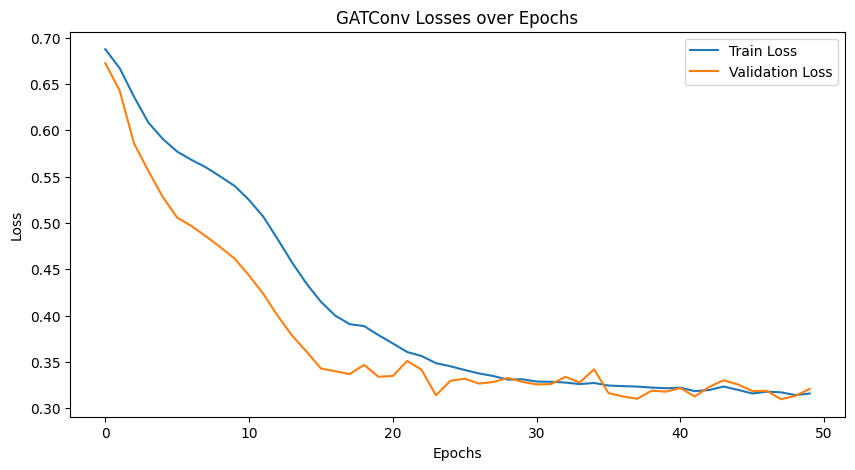

GATConv - Best Test Loss: 0.3097 achieved at Epoch: 048
Validation AUC for GATConv: 0.8380
-----------------------------
Training SAGEConv model on device: 'cpu'


100%|██████████| 9/9 [00:01<00:00,  8.87it/s]


SAGEConv - Epoch: 001, Train Loss: 0.6793 Test Loss: 0.6376


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


SAGEConv - Epoch: 002, Train Loss: 0.6165 Test Loss: 0.5100


100%|██████████| 9/9 [00:02<00:00,  4.46it/s]


SAGEConv - Epoch: 003, Train Loss: 0.4906 Test Loss: 0.3252


100%|██████████| 9/9 [00:01<00:00,  8.67it/s]


SAGEConv - Epoch: 004, Train Loss: 0.3459 Test Loss: 0.1996


100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


SAGEConv - Epoch: 005, Train Loss: 0.2582 Test Loss: 0.1730


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


SAGEConv - Epoch: 006, Train Loss: 0.2093 Test Loss: 0.1689


100%|██████████| 9/9 [00:01<00:00,  6.73it/s]


SAGEConv - Epoch: 007, Train Loss: 0.1880 Test Loss: 0.1463


100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


SAGEConv - Epoch: 008, Train Loss: 0.1691 Test Loss: 0.1329


100%|██████████| 9/9 [00:01<00:00,  6.66it/s]


SAGEConv - Epoch: 009, Train Loss: 0.1578 Test Loss: 0.1175


100%|██████████| 9/9 [00:02<00:00,  3.74it/s]


SAGEConv - Epoch: 010, Train Loss: 0.1541 Test Loss: 0.1133


100%|██████████| 9/9 [00:01<00:00,  7.11it/s]


SAGEConv - Epoch: 011, Train Loss: 0.1469 Test Loss: 0.1143


100%|██████████| 9/9 [00:01<00:00,  7.55it/s]


SAGEConv - Epoch: 012, Train Loss: 0.1368 Test Loss: 0.1153


100%|██████████| 9/9 [00:01<00:00,  7.75it/s]


SAGEConv - Epoch: 013, Train Loss: 0.1380 Test Loss: 0.1165


100%|██████████| 9/9 [00:01<00:00,  8.34it/s]


SAGEConv - Epoch: 014, Train Loss: 0.1295 Test Loss: 0.1114


100%|██████████| 9/9 [00:01<00:00,  7.27it/s]


SAGEConv - Epoch: 015, Train Loss: 0.1305 Test Loss: 0.0992


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


SAGEConv - Epoch: 016, Train Loss: 0.1433 Test Loss: 0.0977


100%|██████████| 9/9 [00:01<00:00,  7.52it/s]


SAGEConv - Epoch: 017, Train Loss: 0.1345 Test Loss: 0.0977


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


SAGEConv - Epoch: 018, Train Loss: 0.1202 Test Loss: 0.1084


100%|██████████| 9/9 [00:01<00:00,  7.60it/s]


SAGEConv - Epoch: 019, Train Loss: 0.1269 Test Loss: 0.1052


100%|██████████| 9/9 [00:01<00:00,  4.69it/s]


SAGEConv - Epoch: 020, Train Loss: 0.1112 Test Loss: 0.0934


100%|██████████| 9/9 [00:01<00:00,  6.99it/s]


SAGEConv - Epoch: 021, Train Loss: 0.1271 Test Loss: 0.1043


100%|██████████| 9/9 [00:01<00:00,  8.64it/s]


SAGEConv - Epoch: 022, Train Loss: 0.1253 Test Loss: 0.0972


100%|██████████| 9/9 [00:01<00:00,  4.63it/s]


SAGEConv - Epoch: 023, Train Loss: 0.1339 Test Loss: 0.1115


100%|██████████| 9/9 [00:01<00:00,  8.60it/s]


SAGEConv - Epoch: 024, Train Loss: 0.1177 Test Loss: 0.0831


100%|██████████| 9/9 [00:01<00:00,  8.29it/s]


SAGEConv - Epoch: 025, Train Loss: 0.1154 Test Loss: 0.0967


100%|██████████| 9/9 [00:01<00:00,  8.92it/s]


SAGEConv - Epoch: 026, Train Loss: 0.1150 Test Loss: 0.0876


100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


SAGEConv - Epoch: 027, Train Loss: 0.1035 Test Loss: 0.0990


100%|██████████| 9/9 [00:00<00:00,  9.10it/s]


SAGEConv - Epoch: 028, Train Loss: 0.1159 Test Loss: 0.0914


100%|██████████| 9/9 [00:01<00:00,  8.92it/s]


SAGEConv - Epoch: 029, Train Loss: 0.1036 Test Loss: 0.0810


100%|██████████| 9/9 [00:01<00:00,  7.59it/s]


SAGEConv - Epoch: 030, Train Loss: 0.0990 Test Loss: 0.1048


100%|██████████| 9/9 [00:01<00:00,  6.73it/s]


SAGEConv - Epoch: 031, Train Loss: 0.1101 Test Loss: 0.0858


100%|██████████| 9/9 [00:01<00:00,  8.81it/s]


SAGEConv - Epoch: 032, Train Loss: 0.1013 Test Loss: 0.0918


100%|██████████| 9/9 [00:01<00:00,  6.52it/s]


SAGEConv - Epoch: 033, Train Loss: 0.0997 Test Loss: 0.0845


100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


SAGEConv - Epoch: 034, Train Loss: 0.0987 Test Loss: 0.0956


100%|██████████| 9/9 [00:01<00:00,  8.83it/s]


SAGEConv - Epoch: 035, Train Loss: 0.0988 Test Loss: 0.0806


100%|██████████| 9/9 [00:01<00:00,  7.22it/s]


SAGEConv - Epoch: 036, Train Loss: 0.1087 Test Loss: 0.0838


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


SAGEConv - Epoch: 037, Train Loss: 0.1065 Test Loss: 0.0907


100%|██████████| 9/9 [00:01<00:00,  8.66it/s]


SAGEConv - Epoch: 038, Train Loss: 0.1024 Test Loss: 0.0923


100%|██████████| 9/9 [00:01<00:00,  8.26it/s]


SAGEConv - Epoch: 039, Train Loss: 0.1003 Test Loss: 0.0785


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


SAGEConv - Epoch: 040, Train Loss: 0.0996 Test Loss: 0.0794


100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


SAGEConv - Epoch: 041, Train Loss: 0.1081 Test Loss: 0.0723


100%|██████████| 9/9 [00:01<00:00,  7.36it/s]


SAGEConv - Epoch: 042, Train Loss: 0.0872 Test Loss: 0.0783


100%|██████████| 9/9 [00:01<00:00,  4.78it/s]


SAGEConv - Epoch: 043, Train Loss: 0.0934 Test Loss: 0.0721


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


SAGEConv - Epoch: 044, Train Loss: 0.0974 Test Loss: 0.0764


100%|██████████| 9/9 [00:02<00:00,  3.54it/s]


SAGEConv - Epoch: 045, Train Loss: 0.0944 Test Loss: 0.0658


100%|██████████| 9/9 [00:01<00:00,  8.22it/s]


SAGEConv - Epoch: 046, Train Loss: 0.0983 Test Loss: 0.0700


100%|██████████| 9/9 [00:01<00:00,  8.94it/s]


SAGEConv - Epoch: 047, Train Loss: 0.0856 Test Loss: 0.0784


100%|██████████| 9/9 [00:01<00:00,  7.40it/s]


SAGEConv - Epoch: 048, Train Loss: 0.0871 Test Loss: 0.0868


100%|██████████| 9/9 [00:01<00:00,  6.63it/s]


SAGEConv - Epoch: 049, Train Loss: 0.1056 Test Loss: 0.0770


100%|██████████| 9/9 [00:00<00:00,  9.05it/s]


SAGEConv - Epoch: 050, Train Loss: 0.0971 Test Loss: 0.0688


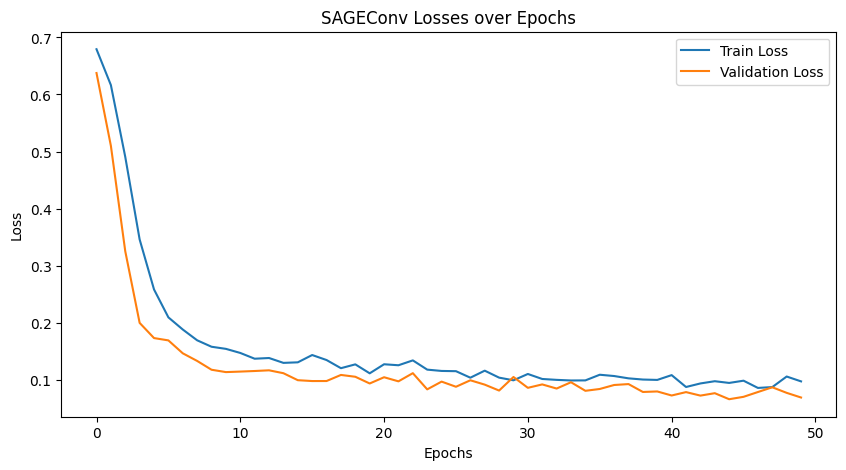

SAGEConv - Best Test Loss: 0.0658 achieved at Epoch: 045
Validation AUC for SAGEConv: 0.7560
-----------------------------
Training GATConv model on device: 'cpu'


100%|██████████| 9/9 [00:01<00:00,  5.04it/s]


GATConv - Epoch: 001, Train Loss: 0.6859 Test Loss: 0.6676


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


GATConv - Epoch: 002, Train Loss: 0.6542 Test Loss: 0.5951


100%|██████████| 9/9 [00:01<00:00,  6.54it/s]


GATConv - Epoch: 003, Train Loss: 0.5907 Test Loss: 0.4836


100%|██████████| 9/9 [00:01<00:00,  4.69it/s]


GATConv - Epoch: 004, Train Loss: 0.5256 Test Loss: 0.3840


100%|██████████| 9/9 [00:01<00:00,  6.52it/s]


GATConv - Epoch: 005, Train Loss: 0.4834 Test Loss: 0.3222


100%|██████████| 9/9 [00:01<00:00,  6.11it/s]


GATConv - Epoch: 006, Train Loss: 0.4623 Test Loss: 0.2956


100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


GATConv - Epoch: 007, Train Loss: 0.4398 Test Loss: 0.2878


100%|██████████| 9/9 [00:01<00:00,  6.87it/s]


GATConv - Epoch: 008, Train Loss: 0.4355 Test Loss: 0.2677


100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


GATConv - Epoch: 009, Train Loss: 0.4255 Test Loss: 0.2627


100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


GATConv - Epoch: 010, Train Loss: 0.4097 Test Loss: 0.2543


100%|██████████| 9/9 [00:01<00:00,  6.94it/s]


GATConv - Epoch: 011, Train Loss: 0.3829 Test Loss: 0.2436


100%|██████████| 9/9 [00:01<00:00,  4.67it/s]


GATConv - Epoch: 012, Train Loss: 0.3660 Test Loss: 0.2385


100%|██████████| 9/9 [00:01<00:00,  6.94it/s]


GATConv - Epoch: 013, Train Loss: 0.3463 Test Loss: 0.2160


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


GATConv - Epoch: 014, Train Loss: 0.3201 Test Loss: 0.2046


100%|██████████| 9/9 [00:02<00:00,  4.49it/s]


GATConv - Epoch: 015, Train Loss: 0.2949 Test Loss: 0.1856


100%|██████████| 9/9 [00:01<00:00,  6.80it/s]


GATConv - Epoch: 016, Train Loss: 0.2716 Test Loss: 0.1921


100%|██████████| 9/9 [00:01<00:00,  6.92it/s]


GATConv - Epoch: 017, Train Loss: 0.2602 Test Loss: 0.1647


100%|██████████| 9/9 [00:02<00:00,  3.58it/s]


GATConv - Epoch: 018, Train Loss: 0.2407 Test Loss: 0.1802


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


GATConv - Epoch: 019, Train Loss: 0.2258 Test Loss: 0.1707


100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


GATConv - Epoch: 020, Train Loss: 0.2159 Test Loss: 0.1627


100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


GATConv - Epoch: 021, Train Loss: 0.2076 Test Loss: 0.1696


100%|██████████| 9/9 [00:01<00:00,  6.89it/s]


GATConv - Epoch: 022, Train Loss: 0.1974 Test Loss: 0.1532


100%|██████████| 9/9 [00:02<00:00,  4.39it/s]


GATConv - Epoch: 023, Train Loss: 0.1936 Test Loss: 0.1515


100%|██████████| 9/9 [00:01<00:00,  6.85it/s]


GATConv - Epoch: 024, Train Loss: 0.1878 Test Loss: 0.1535


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


GATConv - Epoch: 025, Train Loss: 0.1982 Test Loss: 0.1596


100%|██████████| 9/9 [00:01<00:00,  5.04it/s]


GATConv - Epoch: 026, Train Loss: 0.1815 Test Loss: 0.1444


100%|██████████| 9/9 [00:01<00:00,  6.55it/s]


GATConv - Epoch: 027, Train Loss: 0.1932 Test Loss: 0.1431


100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


GATConv - Epoch: 028, Train Loss: 0.1815 Test Loss: 0.1412


100%|██████████| 9/9 [00:01<00:00,  5.01it/s]


GATConv - Epoch: 029, Train Loss: 0.1780 Test Loss: 0.1564


100%|██████████| 9/9 [00:01<00:00,  6.90it/s]


GATConv - Epoch: 030, Train Loss: 0.1780 Test Loss: 0.1351


100%|██████████| 9/9 [00:01<00:00,  6.18it/s]


GATConv - Epoch: 031, Train Loss: 0.1683 Test Loss: 0.1446


100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


GATConv - Epoch: 032, Train Loss: 0.1600 Test Loss: 0.1450


100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


GATConv - Epoch: 033, Train Loss: 0.1667 Test Loss: 0.1405


100%|██████████| 9/9 [00:02<00:00,  4.42it/s]


GATConv - Epoch: 034, Train Loss: 0.1570 Test Loss: 0.1496


100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


GATConv - Epoch: 035, Train Loss: 0.1622 Test Loss: 0.1420


100%|██████████| 9/9 [00:01<00:00,  6.90it/s]


GATConv - Epoch: 036, Train Loss: 0.1704 Test Loss: 0.1268


100%|██████████| 9/9 [00:02<00:00,  4.42it/s]


GATConv - Epoch: 037, Train Loss: 0.1536 Test Loss: 0.1452


100%|██████████| 9/9 [00:01<00:00,  7.03it/s]


GATConv - Epoch: 038, Train Loss: 0.1598 Test Loss: 0.1334


100%|██████████| 9/9 [00:01<00:00,  6.51it/s]


GATConv - Epoch: 039, Train Loss: 0.1606 Test Loss: 0.1409


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


GATConv - Epoch: 040, Train Loss: 0.1496 Test Loss: 0.1437


100%|██████████| 9/9 [00:01<00:00,  6.79it/s]


GATConv - Epoch: 041, Train Loss: 0.1647 Test Loss: 0.1369


100%|██████████| 9/9 [00:01<00:00,  6.60it/s]


GATConv - Epoch: 042, Train Loss: 0.1444 Test Loss: 0.1407


100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


GATConv - Epoch: 043, Train Loss: 0.1527 Test Loss: 0.1320


100%|██████████| 9/9 [00:01<00:00,  6.84it/s]


GATConv - Epoch: 044, Train Loss: 0.1482 Test Loss: 0.1427


100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


GATConv - Epoch: 045, Train Loss: 0.1547 Test Loss: 0.1450


100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


GATConv - Epoch: 046, Train Loss: 0.1534 Test Loss: 0.1316


100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


GATConv - Epoch: 047, Train Loss: 0.1473 Test Loss: 0.1410


100%|██████████| 9/9 [00:01<00:00,  6.67it/s]


GATConv - Epoch: 048, Train Loss: 0.1520 Test Loss: 0.1423


100%|██████████| 9/9 [00:01<00:00,  6.93it/s]


GATConv - Epoch: 049, Train Loss: 0.1551 Test Loss: 0.1583


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


GATConv - Epoch: 050, Train Loss: 0.1441 Test Loss: 0.1332


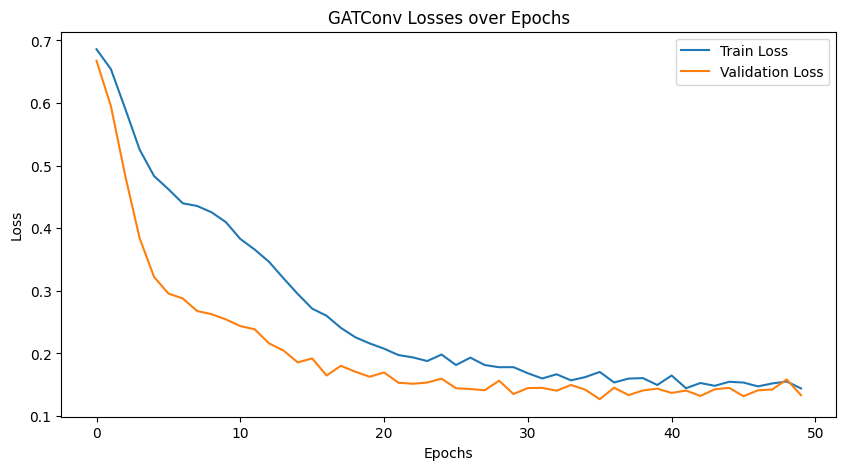

GATConv - Best Test Loss: 0.1268 achieved at Epoch: 036
Validation AUC for GATConv: 0.8635
-----------------------------


Model Loss Function Classifier Type  Best Epoch  Best Validation Loss  \
0  SAGEConv  crossentropy            lstm          48              0.443137   
1  SAGEConv           bce            lstm          34              0.438106   
2  SAGEConv           bpr            lstm          46              0.269840   
3  SAGEConv  crossentropy            mean          49              0.212940   
4  SAGEConv           bce            mean          50              0.204995   
5  SAGEConv           bpr            mean          46              0.075549   
6  SAGEConv  crossentropy            lstm          49              0.440512   
7   GATConv  crossentropy            lstm          26              0.469064   
8  SAGEConv           bce            lstm          48              0.440084   
9   GATConv           bce            lstm          37              0.474780   

   Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
0          0.8340                        0.749                        0.919   
1          0.8545                        0.783                        0.926   
2          0.8485                        0.773                        0.924   
3          0.8665                        0.817                        0.916   
4          0.8750                        0.836                        0.914   
5          0.7135                        0.436                        0.991   
6          0.8425                        0.758                        0.927   
7          0.8410                        0.776                        0.906   
8          0.8520                        0.775                        0.929   
9          0.8690                        0.859                        0.879   

   Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
0   0.902410   0.749  0.818579                                     749.0   
1   0.913652   0.783  0.843296                                     783.0   
2   0.910483   0.773  0.836128                                     773.0   
3   0.906770   0.817  0.859548                                     817.0   
4   0.906725   0.836  0.869927                                     836.0   
5   0.979775   0.436  0.603460                                     436.0   
6   0.912154   0.758  0.827963                                     758.0   
7   0.891954   0.776  0.829947                                     776.0   
8   0.916076   0.775  0.839653                                     775.0   
9   0.876531   0.859  0.867677                                     859.0   

   For Positive Edges Number of 0 predicted  \
0                                     251.0   
1                                     217.0   
2                                     227.0   
3                                     183.0   
4                                     164.0   
5                                     564.0   
6                                     242.0   
7                                     224.0   
8                                     225.0   
9                                     141.0   

   For Negative Edges Number of 1 predicted  \
0                                      81.0   
1                                      74.0   
2                                      76.0   
3                                      84.0   
4                                      86.0   
5                                       9.0   
6                                      73.0   
7                                      94.0   
8                                      71.0   
9                                     121.0   

   For Negative Edges Number of 0 predicted  
0                                     919.0  
1                                     926.0  
2                                     924.0  
3                                     916.0  
4                                     914.0  
5                                     991.0  
6                                     927.0  
7                        

In [20]:
# Define hyperparameter combinations
loss_functions = ['crossentropy', 'bce', 'bpr']
classifier_types = ['lstm','mean']

# Common hyperparameters
common_hyperparams = {
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "learning_rate": 0.001,
    "num_epochs": 50,
    "patience": 20,
    "lr_decay_factor": 0.5,
}

for classifier_type, loss_function in itertools.product(classifier_types, loss_functions):
    for model_type in ['SAGEConv', 'GATConv']:
        # Determine the conv_type and update hyperparameters based on the model_type
        hyperparams = common_hyperparams.copy()
        hyperparams["loss_function"] = loss_function
        hyperparams["classifier_type"] = classifier_type
        hyperparams["model_type"] = model_type

        if model_type == 'SAGEConv':
            conv_type = 'sage'
            hyperparams["lr_decay_step"] = 30
        elif model_type == 'GATConv':
            conv_type = 'gat'
            hyperparams["lr_decay_step"] = 50

        # Create and train the model
        model = Model(hidden_channels=64, conv_type=conv_type, classifier_type=hyperparams["classifier_type"])
        best_epoch, best_val_loss = train_model(model, train_loader, test_loader, hyperparams)

        # Evaluate the model
        auc_score = evaluate_models_auc({model_type: model}, val_loader, device)
        evaluation_results = evaluate_accuracy({model_type: model}, sampled_data, device)
        prediction_counts = count_predictions({model_type: model}, sampled_data, device)
        precision_recall_results = evaluate_precision_recall({model_type: model}, sampled_data, device)
        f1_score_results = evaluate_f1_score({model_type: model}, sampled_data, device)

        # Store the results in the DataFrame
        model_results = {
            "Model": model_type,
            "Loss Function": loss_function,
            "Classifier Type": classifier_type,
            "Best Epoch": best_epoch,
            "Best Validation Loss": best_val_loss,
            "Validation AUC": auc_score[model_type],
            "Accuracy for Positive Edges": evaluation_results[model_type]["Accuracy for Positive Edges"],
            "Accuracy for Negative Edges": evaluation_results[model_type]["Accuracy for Negative Edges"],
            "Precision": precision_recall_results[model_type]["Precision"],
            "Recall": precision_recall_results[model_type]["Recall"],
            "F1 Score": f1_score_results[model_type]["F1 Score"],
        }

        for metric_name, metric_value in prediction_counts[model_type].items():
            model_results[metric_name.replace(':', '').replace("'s", "")] = metric_value

        # Convert the dictionary to a DataFrame and append it to the results DataFrame
        model_results_df = pd.DataFrame([model_results])
        results_df = pd.concat([results_df, model_results_df], ignore_index=True)

results_df.head(10)


Saving of results for various combinations of hyperparameters for dataset of 100k instances

In [23]:
results_df.head(18)

Model Loss Function Classifier Type  Best Epoch  Best Validation Loss  \
0   SAGEConv  crossentropy            lstm          48              0.443137   
1   SAGEConv           bce            lstm          34              0.438106   
2   SAGEConv           bpr            lstm          46              0.269840   
3   SAGEConv  crossentropy            mean          49              0.212940   
4   SAGEConv           bce            mean          50              0.204995   
5   SAGEConv           bpr            mean          46              0.075549   
6   SAGEConv  crossentropy            lstm          49              0.440512   
7    GATConv  crossentropy            lstm          26              0.469064   
8   SAGEConv           bce            lstm          48              0.440084   
9    GATConv           bce            lstm          37              0.474780   
10  SAGEConv           bpr            lstm          49              0.281486   
11   GATConv           bpr            lstm          21              0.314928   
12  SAGEConv  crossentropy            mean          48              0.198742   
13   GATConv  crossentropy            mean          49              0.292709   
14  SAGEConv           bce            mean          47              0.203365   
15   GATConv           bce            mean          48              0.309687   
16  SAGEConv           bpr            mean          45              0.065802   
17   GATConv           bpr            mean          36              0.126821   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
0           0.8340                        0.749                        0.919   
1           0.8545                        0.783                        0.926   
2           0.8485                        0.773                        0.924   
3           0.8665                        0.817                        0.916   
4           0.8750                        0.836                        0.914   
5           0.7135                        0.436                        0.991   
6           0.8425                        0.758                        0.927   
7           0.8410                        0.776                        0.906   
8           0.8520                        0.775                        0.929   
9           0.8690                        0.859                        0.879   
10          0.8395                        0.748                        0.931   
11          0.8505                        0.836                        0.865   
12          0.8670                        0.821                        0.913   
13          0.8530                        0.808                        0.898   
14          0.8775                        0.843                        0.912   
15          0.8380                        0.784                        0.892   
16          0.7560                        0.528                        0.984   
17          0.8635                        0.881                        0.846   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
0    0.902410   0.749  0.818579                                     749.0   
1    0.913652   0.783  0.843296                                     783.0   
2    0.910483   0.773  0.836128                                     773.0   
3    0.906770   0.817  0.859548                                     817.0   
4    0.906725   0.836  0.869927                                     836.0   
5    0.979775   0.436  0.603460                                     436.0   
6    0.912154   0.758  0.827963                                     758.0   
7    0.891954   0.776  0.829947                                     776.0   
8    0.916076   0.775  0.839653                                     775.0   
9    0.876531   0.859  0.867677                                     859.0   
10   0.915545   0.748  0.823335                                     748.0   
11   0.860968   0.836  0.848300          

In [27]:
results_df=results_df.iloc[6:]
sorted_results_df = results_df.sort_values(by='Validation AUC', ascending=False)
sorted_results_df.head(12)

Model Loss Function Classifier Type  Best Epoch  Best Validation Loss  \
14  SAGEConv           bce            mean          47              0.203365   
9    GATConv           bce            lstm          37              0.474780   
12  SAGEConv  crossentropy            mean          48              0.198742   
17   GATConv           bpr            mean          36              0.126821   
13   GATConv  crossentropy            mean          49              0.292709   
8   SAGEConv           bce            lstm          48              0.440084   
11   GATConv           bpr            lstm          21              0.314928   
6   SAGEConv  crossentropy            lstm          49              0.440512   
7    GATConv  crossentropy            lstm          26              0.469064   
10  SAGEConv           bpr            lstm          49              0.281486   
15   GATConv           bce            mean          48              0.309687   
16  SAGEConv           bpr            mean          45              0.065802   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
14          0.8775                        0.843                        0.912   
9           0.8690                        0.859                        0.879   
12          0.8670                        0.821                        0.913   
17          0.8635                        0.881                        0.846   
13          0.8530                        0.808                        0.898   
8           0.8520                        0.775                        0.929   
11          0.8505                        0.836                        0.865   
6           0.8425                        0.758                        0.927   
7           0.8410                        0.776                        0.906   
10          0.8395                        0.748                        0.931   
15          0.8380                        0.784                        0.892   
16          0.7560                        0.528                        0.984   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
14   0.905478   0.843  0.873123                                     843.0   
9    0.876531   0.859  0.867677                                     859.0   
12   0.904185   0.821  0.860587                                     821.0   
17   0.851208   0.881  0.865848                                     881.0   
13   0.887912   0.808  0.846073                                     808.0   
8    0.916076   0.775  0.839653                                     775.0   
11   0.860968   0.836  0.848300                                     836.0   
6    0.912154   0.758  0.827963                                     758.0   
7    0.891954   0.776  0.829947                                     776.0   
10   0.915545   0.748  0.823335                                     748.0   
15   0.878924   0.784  0.828753                                     784.0   
16   0.970588   0.528  0.683938                                     528.0   

    For Positive Edges Number of 0 predicted  \
14                                     157.0   
9                                      141.0   
12                                     179.0   
17                                     119.0   
13                                     192.0   
8                                      225.0   
11                                     164.0   
6                                      242.0   
7                                      224.0   
10                                     252.0   
15                                     216.0   
16                                     472.0   

    For Negative Edges Number of 1 predicted  \
14                                      88.0   
9                                      121.0   
12                                      87.0   
17                                     154.0   
13                                     102.0   
8         

In [413]:
results100000_df=results_df.copy(deep=True)

In [ ]:
results100000_df = results100000_df.sort_values(by='Validation AUC', ascending=False)
results100000_df.head(12)

In [18]:
results100000_df.to_csv('resultsHyper100000.csv', index=False)  


In [19]:
results100000_df = pd.read_csv('resultsHyper100000.csv')
results100000_df.head(12)

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
0   SAGEConv            lstm           bpr          50              0.244171   
1   SAGEConv            lstm           bce         103              0.418516   
2   SAGEConv            lstm  crossentropy          70              0.417983   
3   SAGEConv            mean           bpr          97              0.030421   
4   SAGEConv            mean  crossentropy          20              0.129686   
5   SAGEConv            mean           bce          24              0.130804   
6    GATConv            lstm  crossentropy          25              0.495159   
7    GATConv            mean  crossentropy          96              0.323124   
8    GATConv            lstm           bpr          37              0.353741   
9    GATConv            mean           bce         110              0.322787   
10   GATConv            lstm           bce          71              0.483676   
11   GATConv            mean           bpr         104              0.165012   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
0          0.82415                       0.8035                       0.8436   
1          0.82090                       0.8121                       0.8343   
2          0.81675                       0.8139                       0.8182   
3          0.81080                       0.7475                       0.8763   
4          0.80270                       0.7774                       0.8264   
5          0.79855                       0.7820                       0.8155   
6          0.78525                       0.9051                       0.6708   
7          0.78425                       0.7679                       0.7944   
8          0.77830                       0.8742                       0.6823   
9          0.76800                       0.7528                       0.7975   
10         0.76380                       0.7457                       0.7846   
11         0.64005                       0.9908                       0.2850   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
0    0.837066  0.8035  0.819940                                    8035.0   
1    0.830538  0.8121  0.821215                                    8121.0   
2    0.817415  0.8139  0.815654                                    8139.0   
3    0.858012  0.7475  0.798953                                    7475.0   
4    0.817455  0.7774  0.796925                                    7774.0   
5    0.809105  0.7820  0.795322                                    7820.0   
6    0.733290  0.9051  0.810187                                    9051.0   
7    0.788803  0.7679  0.778211                                    7679.0   
8    0.733451  0.8742  0.797664                                    8742.0   
9    0.788025  0.7528  0.770010                                    7528.0   
10   0.775882  0.7457  0.760492                                    7457.0   
11   0.580842  0.9908  0.732353                                    9908.0   

    For Positive Edges Number of 0 predicted  \
0                                     1965.0   
1                                     1879.0   
2                                     1861.0   
3                                     2525.0   
4                                     2226.0   
5                                     2180.0   
6                                      949.0   
7                                     2321.0   
8                                     1258.0   
9                                     2472.0   
10                                    2543.0   
11                                      92.0   

    For Negative Edges Number of 1 predicted  \
0                                     1564.0   
1                                     1657.0   
2                                     1818.0   
3                                     1237.0   
4                                     1736.0   
5         

Work with 10k instances

In [173]:
results_df=results_df.iloc[:12]
results_df.head(12)

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
0   SAGEConv            mean           bce         101              0.183205   
1    GATConv            mean           bce          28              0.330976   
2   SAGEConv            lstm           bce          53              0.201073   
3    GATConv            lstm           bce          56              0.320359   
4   SAGEConv            mean  crossentropy          70              0.192621   
5    GATConv            mean  crossentropy          33              0.308855   
6   SAGEConv            lstm  crossentropy         101              0.180258   
7    GATConv            lstm  crossentropy          59              0.310715   
8   SAGEConv            mean           bpr          58              0.189143   
9    GATConv            mean           bpr          37              0.298253   
10  SAGEConv            lstm           bpr          56              0.194844   
11   GATConv            lstm           bpr          34              0.336984   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
0           0.8590                        0.828                        0.893   
1           0.8075                        0.816                        0.837   
2           0.8595                        0.832                        0.887   
3           0.8365                        0.801                        0.855   
4           0.8490                        0.811                        0.884   
5           0.8290                        0.808                        0.858   
6           0.8500                        0.795                        0.895   
7           0.8310                        0.796                        0.879   
8           0.8610                        0.831                        0.900   
9           0.8235                        0.813                        0.837   
10          0.8640                        0.837                        0.895   
11          0.8290                        0.755                        0.875   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
0    0.885561   0.828  0.855814                                     828.0   
1    0.833504   0.816  0.824659                                     816.0   
2    0.880423   0.832  0.855527                                     832.0   
3    0.846723   0.801  0.823227                                     801.0   
4    0.874865   0.811  0.841723                                     811.0   
5    0.850526   0.808  0.828718                                     808.0   
6    0.883333   0.795  0.836842                                     795.0   
7    0.868048   0.796  0.830464                                     796.0   
8    0.892589   0.831  0.860694                                     831.0   
9    0.832992   0.813  0.822874                                     813.0   
10   0.888535   0.837  0.861998                                     837.0   
11   0.857955   0.755  0.803191                                     755.0   

    For Positive Edges Number of 0 predicted  \
0                                      172.0   
1                                      184.0   
2                                      168.0   
3                                      199.0   
4                                      189.0   
5                                      192.0   
6                                      205.0   
7                                      204.0   
8                                      169.0   
9                                      187.0   
10                                     163.0   
11                                     245.0   

    For Negative Edges Number of 1 predicted  \
0                                      107.0   
1                                      163.0   
2                                      113.0   
3                                      145.0   
4                                      116.0   
5         

In [28]:
# Kreiranje dva odvojena DataFrame-a na osnovu loss funkcija
mean_df = results_df[results_df['Classifier Type'] == 'mean']
lstm_df = results_df[results_df['Classifier Type'] == 'lstm']
bce_df = results_df[results_df['Loss Function'] == 'bce']
crossentropy_df = results_df[results_df['Loss Function'] == 'crossentropy']
bpr_df = results_df[results_df['Loss Function'] == 'bpr']

In [29]:
mean_df.head(6)

Model Loss Function Classifier Type  Best Epoch  Best Validation Loss  \
12  SAGEConv  crossentropy            mean          48              0.198742   
13   GATConv  crossentropy            mean          49              0.292709   
14  SAGEConv           bce            mean          47              0.203365   
15   GATConv           bce            mean          48              0.309687   
16  SAGEConv           bpr            mean          45              0.065802   
17   GATConv           bpr            mean          36              0.126821   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
12          0.8670                        0.821                        0.913   
13          0.8530                        0.808                        0.898   
14          0.8775                        0.843                        0.912   
15          0.8380                        0.784                        0.892   
16          0.7560                        0.528                        0.984   
17          0.8635                        0.881                        0.846   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
12   0.904185   0.821  0.860587                                     821.0   
13   0.887912   0.808  0.846073                                     808.0   
14   0.905478   0.843  0.873123                                     843.0   
15   0.878924   0.784  0.828753                                     784.0   
16   0.970588   0.528  0.683938                                     528.0   
17   0.851208   0.881  0.865848                                     881.0   

    For Positive Edges Number of 0 predicted  \
12                                     179.0   
13                                     192.0   
14                                     157.0   
15                                     216.0   
16                                     472.0   
17                                     119.0   

    For Negative Edges Number of 1 predicted  \
12                                      87.0   
13                                     102.0   
14                                      88.0   
15                                     108.0   
16                                      16.0   
17                                     154.0   

    For Negative Edges Number of 0 predicted  
12                                     913.0  
13                                     898.0  
14                                     912.0  
15                                     892.0  
16                                     984.0  
17                                     846.0

In [30]:
lstm_df.head(6)

Model Loss Function Classifier Type  Best Epoch  Best Validation Loss  \
6   SAGEConv  crossentropy            lstm          49              0.440512   
7    GATConv  crossentropy            lstm          26              0.469064   
8   SAGEConv           bce            lstm          48              0.440084   
9    GATConv           bce            lstm          37              0.474780   
10  SAGEConv           bpr            lstm          49              0.281486   
11   GATConv           bpr            lstm          21              0.314928   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
6           0.8425                        0.758                        0.927   
7           0.8410                        0.776                        0.906   
8           0.8520                        0.775                        0.929   
9           0.8690                        0.859                        0.879   
10          0.8395                        0.748                        0.931   
11          0.8505                        0.836                        0.865   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
6    0.912154   0.758  0.827963                                     758.0   
7    0.891954   0.776  0.829947                                     776.0   
8    0.916076   0.775  0.839653                                     775.0   
9    0.876531   0.859  0.867677                                     859.0   
10   0.915545   0.748  0.823335                                     748.0   
11   0.860968   0.836  0.848300                                     836.0   

    For Positive Edges Number of 0 predicted  \
6                                      242.0   
7                                      224.0   
8                                      225.0   
9                                      141.0   
10                                     252.0   
11                                     164.0   

    For Negative Edges Number of 1 predicted  \
6                                       73.0   
7                                       94.0   
8                                       71.0   
9                                      121.0   
10                                      69.0   
11                                     135.0   

    For Negative Edges Number of 0 predicted  
6                                      927.0  
7                                      906.0  
8                                      929.0  
9                                      879.0  
10                                     931.0  
11                                     865.0

In [31]:
bce_df.head()

Model Loss Function Classifier Type  Best Epoch  Best Validation Loss  \
8   SAGEConv           bce            lstm          48              0.440084   
9    GATConv           bce            lstm          37              0.474780   
14  SAGEConv           bce            mean          47              0.203365   
15   GATConv           bce            mean          48              0.309687   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
8           0.8520                        0.775                        0.929   
9           0.8690                        0.859                        0.879   
14          0.8775                        0.843                        0.912   
15          0.8380                        0.784                        0.892   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
8    0.916076   0.775  0.839653                                     775.0   
9    0.876531   0.859  0.867677                                     859.0   
14   0.905478   0.843  0.873123                                     843.0   
15   0.878924   0.784  0.828753                                     784.0   

    For Positive Edges Number of 0 predicted  \
8                                      225.0   
9                                      141.0   
14                                     157.0   
15                                     216.0   

    For Negative Edges Number of 1 predicted  \
8                                       71.0   
9                                      121.0   
14                                      88.0   
15                                     108.0   

    For Negative Edges Number of 0 predicted  
8                                      929.0  
9                                      879.0  
14                                     912.0  
15                                     892.0

In [32]:
crossentropy_df.head()

Model Loss Function Classifier Type  Best Epoch  Best Validation Loss  \
6   SAGEConv  crossentropy            lstm          49              0.440512   
7    GATConv  crossentropy            lstm          26              0.469064   
12  SAGEConv  crossentropy            mean          48              0.198742   
13   GATConv  crossentropy            mean          49              0.292709   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
6           0.8425                        0.758                        0.927   
7           0.8410                        0.776                        0.906   
12          0.8670                        0.821                        0.913   
13          0.8530                        0.808                        0.898   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
6    0.912154   0.758  0.827963                                     758.0   
7    0.891954   0.776  0.829947                                     776.0   
12   0.904185   0.821  0.860587                                     821.0   
13   0.887912   0.808  0.846073                                     808.0   

    For Positive Edges Number of 0 predicted  \
6                                      242.0   
7                                      224.0   
12                                     179.0   
13                                     192.0   

    For Negative Edges Number of 1 predicted  \
6                                       73.0   
7                                       94.0   
12                                      87.0   
13                                     102.0   

    For Negative Edges Number of 0 predicted  
6                                      927.0  
7                                      906.0  
12                                     913.0  
13                                     898.0

In [33]:
bpr_df.head()

Model Loss Function Classifier Type  Best Epoch  Best Validation Loss  \
10  SAGEConv           bpr            lstm          49              0.281486   
11   GATConv           bpr            lstm          21              0.314928   
16  SAGEConv           bpr            mean          45              0.065802   
17   GATConv           bpr            mean          36              0.126821   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
10          0.8395                        0.748                        0.931   
11          0.8505                        0.836                        0.865   
16          0.7560                        0.528                        0.984   
17          0.8635                        0.881                        0.846   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
10   0.915545   0.748  0.823335                                     748.0   
11   0.860968   0.836  0.848300                                     836.0   
16   0.970588   0.528  0.683938                                     528.0   
17   0.851208   0.881  0.865848                                     881.0   

    For Positive Edges Number of 0 predicted  \
10                                     252.0   
11                                     164.0   
16                                     472.0   
17                                     119.0   

    For Negative Edges Number of 1 predicted  \
10                                      69.0   
11                                     135.0   
16                                      16.0   
17                                     154.0   

    For Negative Edges Number of 0 predicted  
10                                     931.0  
11                                     865.0  
16                                     984.0  
17                                     846.0

In [152]:
sorted_results_df = results_df.sort_values(by='Validation AUC', ascending=False)
sorted_results_df.head(12)

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
10  SAGEConv            lstm           bpr          56              0.194844   
8   SAGEConv            mean           bpr          58              0.189143   
2   SAGEConv            lstm           bce          53              0.201073   
0   SAGEConv            mean           bce         101              0.183205   
6   SAGEConv            lstm  crossentropy         101              0.180258   
4   SAGEConv            mean  crossentropy          70              0.192621   
3    GATConv            lstm           bce          56              0.320359   
7    GATConv            lstm  crossentropy          59              0.310715   
5    GATConv            mean  crossentropy          33              0.308855   
11   GATConv            lstm           bpr          34              0.336984   
9    GATConv            mean           bpr          37              0.298253   
1    GATConv            mean           bce          28              0.330976   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
10          0.8640                        0.837                        0.895   
8           0.8610                        0.831                        0.900   
2           0.8595                        0.832                        0.887   
0           0.8590                        0.828                        0.893   
6           0.8500                        0.795                        0.895   
4           0.8490                        0.811                        0.884   
3           0.8365                        0.801                        0.855   
7           0.8310                        0.796                        0.879   
5           0.8290                        0.808                        0.858   
11          0.8290                        0.755                        0.875   
9           0.8235                        0.813                        0.837   
1           0.8075                        0.816                        0.837   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
10   0.888535   0.837  0.861998                                     837.0   
8    0.892589   0.831  0.860694                                     831.0   
2    0.880423   0.832  0.855527                                     832.0   
0    0.885561   0.828  0.855814                                     828.0   
6    0.883333   0.795  0.836842                                     795.0   
4    0.874865   0.811  0.841723                                     811.0   
3    0.846723   0.801  0.823227                                     801.0   
7    0.868048   0.796  0.830464                                     796.0   
5    0.850526   0.808  0.828718                                     808.0   
11   0.857955   0.755  0.803191                                     755.0   
9    0.832992   0.813  0.822874                                     813.0   
1    0.833504   0.816  0.824659                                     816.0   

    For Positive Edges Number of 0 predicted  \
10                                     163.0   
8                                      169.0   
2                                      168.0   
0                                      172.0   
6                                      205.0   
4                                      189.0   
3                                      199.0   
7                                      204.0   
5                                      192.0   
11                                     245.0   
9                                      187.0   
1                                      184.0   

    For Negative Edges Number of 1 predicted  \
10                                     105.0   
8                                      100.0   
2                                      113.0   
0                                      107.0   
6                                      105.0   
4         

## Training with best combinations of hyperparameters

Training SAGEConv model on device: 'cpu'


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


SAGEConv - Epoch: 001, Train Loss: 0.6820 Test Loss: 0.6566


100%|██████████| 9/9 [00:01<00:00,  5.41it/s]


SAGEConv - Epoch: 002, Train Loss: 0.6439 Test Loss: 0.5812


100%|██████████| 9/9 [00:02<00:00,  3.27it/s]


SAGEConv - Epoch: 003, Train Loss: 0.5651 Test Loss: 0.4679


100%|██████████| 9/9 [00:01<00:00,  7.28it/s]


SAGEConv - Epoch: 004, Train Loss: 0.4616 Test Loss: 0.3759


100%|██████████| 9/9 [00:01<00:00,  4.86it/s]


SAGEConv - Epoch: 005, Train Loss: 0.3902 Test Loss: 0.3390


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


SAGEConv - Epoch: 006, Train Loss: 0.3522 Test Loss: 0.3222


100%|██████████| 9/9 [00:01<00:00,  7.92it/s]


SAGEConv - Epoch: 007, Train Loss: 0.3339 Test Loss: 0.3051


100%|██████████| 9/9 [00:01<00:00,  4.89it/s]


SAGEConv - Epoch: 008, Train Loss: 0.3138 Test Loss: 0.2975


100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


SAGEConv - Epoch: 009, Train Loss: 0.3080 Test Loss: 0.2870


100%|██████████| 9/9 [00:01<00:00,  7.17it/s]


SAGEConv - Epoch: 010, Train Loss: 0.2971 Test Loss: 0.2860


100%|██████████| 9/9 [00:01<00:00,  6.38it/s]


SAGEConv - Epoch: 011, Train Loss: 0.2940 Test Loss: 0.2820


100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


SAGEConv - Epoch: 012, Train Loss: 0.2884 Test Loss: 0.2759


100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


SAGEConv - Epoch: 013, Train Loss: 0.2833 Test Loss: 0.2784


100%|██████████| 9/9 [00:01<00:00,  7.89it/s]


SAGEConv - Epoch: 014, Train Loss: 0.2809 Test Loss: 0.2692


100%|██████████| 9/9 [00:01<00:00,  5.41it/s]


SAGEConv - Epoch: 015, Train Loss: 0.2818 Test Loss: 0.2642


100%|██████████| 9/9 [00:01<00:00,  7.27it/s]


SAGEConv - Epoch: 016, Train Loss: 0.2784 Test Loss: 0.2662


100%|██████████| 9/9 [00:01<00:00,  8.38it/s]


SAGEConv - Epoch: 017, Train Loss: 0.2727 Test Loss: 0.2703


100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


SAGEConv - Epoch: 018, Train Loss: 0.2731 Test Loss: 0.2617


100%|██████████| 9/9 [00:01<00:00,  8.14it/s]


SAGEConv - Epoch: 019, Train Loss: 0.2666 Test Loss: 0.2661


100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


SAGEConv - Epoch: 020, Train Loss: 0.2618 Test Loss: 0.2564


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


SAGEConv - Epoch: 021, Train Loss: 0.2626 Test Loss: 0.2529


100%|██████████| 9/9 [00:01<00:00,  7.44it/s]


SAGEConv - Epoch: 022, Train Loss: 0.2596 Test Loss: 0.2609


100%|██████████| 9/9 [00:01<00:00,  8.31it/s]


SAGEConv - Epoch: 023, Train Loss: 0.2534 Test Loss: 0.2511


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


SAGEConv - Epoch: 024, Train Loss: 0.2511 Test Loss: 0.2517


100%|██████████| 9/9 [00:01<00:00,  7.35it/s]


SAGEConv - Epoch: 025, Train Loss: 0.2478 Test Loss: 0.2582


100%|██████████| 9/9 [00:01<00:00,  7.77it/s]


SAGEConv - Epoch: 026, Train Loss: 0.2528 Test Loss: 0.2525


100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


SAGEConv - Epoch: 027, Train Loss: 0.2494 Test Loss: 0.2511


100%|██████████| 9/9 [00:01<00:00,  7.27it/s]


SAGEConv - Epoch: 028, Train Loss: 0.2394 Test Loss: 0.2499


100%|██████████| 9/9 [00:01<00:00,  7.58it/s]


SAGEConv - Epoch: 029, Train Loss: 0.2385 Test Loss: 0.2490


100%|██████████| 9/9 [00:01<00:00,  5.24it/s]


SAGEConv - Epoch: 030, Train Loss: 0.2353 Test Loss: 0.2493


100%|██████████| 9/9 [00:01<00:00,  5.35it/s]


SAGEConv - Epoch: 031, Train Loss: 0.2346 Test Loss: 0.2430


100%|██████████| 9/9 [00:01<00:00,  5.29it/s]


SAGEConv - Epoch: 032, Train Loss: 0.2355 Test Loss: 0.2400


100%|██████████| 9/9 [00:02<00:00,  4.35it/s]


SAGEConv - Epoch: 033, Train Loss: 0.2274 Test Loss: 0.2392


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


SAGEConv - Epoch: 034, Train Loss: 0.2270 Test Loss: 0.2420


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


SAGEConv - Epoch: 035, Train Loss: 0.2189 Test Loss: 0.2420


100%|██████████| 9/9 [00:01<00:00,  8.39it/s]


SAGEConv - Epoch: 036, Train Loss: 0.2189 Test Loss: 0.2418


100%|██████████| 9/9 [00:01<00:00,  7.36it/s]


SAGEConv - Epoch: 037, Train Loss: 0.2224 Test Loss: 0.2373


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


SAGEConv - Epoch: 038, Train Loss: 0.2184 Test Loss: 0.2546


100%|██████████| 9/9 [00:01<00:00,  7.10it/s]


SAGEConv - Epoch: 039, Train Loss: 0.2093 Test Loss: 0.2359


100%|██████████| 9/9 [00:01<00:00,  7.36it/s]


SAGEConv - Epoch: 040, Train Loss: 0.2138 Test Loss: 0.2334


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


SAGEConv - Epoch: 041, Train Loss: 0.2063 Test Loss: 0.2247


100%|██████████| 9/9 [00:01<00:00,  7.35it/s]


SAGEConv - Epoch: 042, Train Loss: 0.2142 Test Loss: 0.2357


100%|██████████| 9/9 [00:01<00:00,  7.82it/s]


SAGEConv - Epoch: 043, Train Loss: 0.2039 Test Loss: 0.2378


100%|██████████| 9/9 [00:01<00:00,  5.25it/s]


SAGEConv - Epoch: 044, Train Loss: 0.2011 Test Loss: 0.2305


100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


SAGEConv - Epoch: 045, Train Loss: 0.2011 Test Loss: 0.2292


100%|██████████| 9/9 [00:01<00:00,  7.09it/s]


SAGEConv - Epoch: 046, Train Loss: 0.1978 Test Loss: 0.2322


100%|██████████| 9/9 [00:01<00:00,  5.28it/s]


SAGEConv - Epoch: 047, Train Loss: 0.1933 Test Loss: 0.2280


100%|██████████| 9/9 [00:01<00:00,  6.69it/s]


SAGEConv - Epoch: 048, Train Loss: 0.1917 Test Loss: 0.2157


100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


SAGEConv - Epoch: 049, Train Loss: 0.1997 Test Loss: 0.2353


100%|██████████| 9/9 [00:01<00:00,  5.42it/s]


SAGEConv - Epoch: 050, Train Loss: 0.1941 Test Loss: 0.2352


100%|██████████| 9/9 [00:01<00:00,  7.33it/s]


SAGEConv - Epoch: 051, Train Loss: 0.1872 Test Loss: 0.2308


100%|██████████| 9/9 [00:01<00:00,  6.50it/s]


SAGEConv - Epoch: 052, Train Loss: 0.1873 Test Loss: 0.2304


100%|██████████| 9/9 [00:01<00:00,  4.98it/s]


SAGEConv - Epoch: 053, Train Loss: 0.1819 Test Loss: 0.2285


100%|██████████| 9/9 [00:01<00:00,  8.09it/s]


SAGEConv - Epoch: 054, Train Loss: 0.1905 Test Loss: 0.2297


100%|██████████| 9/9 [00:01<00:00,  7.34it/s]


SAGEConv - Epoch: 055, Train Loss: 0.1929 Test Loss: 0.2231


100%|██████████| 9/9 [00:01<00:00,  5.23it/s]


SAGEConv - Epoch: 056, Train Loss: 0.1857 Test Loss: 0.2320


100%|██████████| 9/9 [00:01<00:00,  7.09it/s]


SAGEConv - Epoch: 057, Train Loss: 0.1825 Test Loss: 0.2258


100%|██████████| 9/9 [00:01<00:00,  7.91it/s]


SAGEConv - Epoch: 058, Train Loss: 0.1814 Test Loss: 0.2384


100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


SAGEConv - Epoch: 059, Train Loss: 0.1816 Test Loss: 0.2269


100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


SAGEConv - Epoch: 060, Train Loss: 0.1851 Test Loss: 0.2305


100%|██████████| 9/9 [00:01<00:00,  6.39it/s]


SAGEConv - Epoch: 061, Train Loss: 0.1798 Test Loss: 0.2304


100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


SAGEConv - Epoch: 062, Train Loss: 0.1889 Test Loss: 0.2325


100%|██████████| 9/9 [00:01<00:00,  7.90it/s]


SAGEConv - Epoch: 063, Train Loss: 0.1837 Test Loss: 0.2281


100%|██████████| 9/9 [00:01<00:00,  7.56it/s]


SAGEConv - Epoch: 064, Train Loss: 0.1825 Test Loss: 0.2245


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


SAGEConv - Epoch: 065, Train Loss: 0.1865 Test Loss: 0.2403


100%|██████████| 9/9 [00:01<00:00,  7.05it/s]


SAGEConv - Epoch: 066, Train Loss: 0.1796 Test Loss: 0.2421


100%|██████████| 9/9 [00:01<00:00,  7.05it/s]


SAGEConv - Epoch: 067, Train Loss: 0.1773 Test Loss: 0.2243


100%|██████████| 9/9 [00:02<00:00,  4.41it/s]


SAGEConv - Epoch: 068, Train Loss: 0.1888 Test Loss: 0.2257
Early stopping!


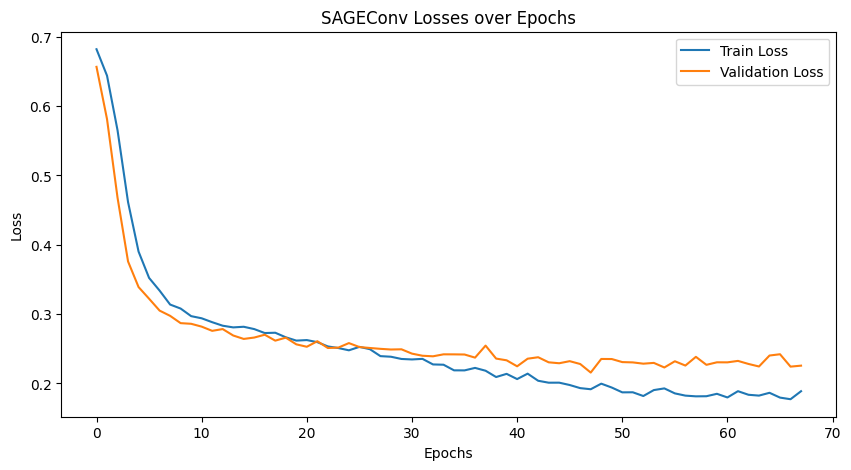

SAGEConv - Best Test Loss: 0.2157 achieved at Epoch: 048
The best model was from epoch 48 with a validation loss of 0.2157


In [56]:
hyperparams_sage = {
    "model_type": 'SAGEConv',  # Include model_type here
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "learning_rate": 0.001,
    "num_epochs": 150,
    "patience": 20,
    "lr_decay_step": 50,
    "lr_decay_factor": 0.5,
    "loss_function": 'bce',
    "classifier_type": 'mean'
}
model_sage = Model(hidden_channels=64, conv_type='sage', classifier_type=hyperparams_sage["classifier_type"])
best_epoch_sage, best_val_loss_sage = train_model(model_sage, train_loader, test_loader, hyperparams_sage)
print(f"The best model was from epoch {best_epoch_sage} with a validation loss of {best_val_loss_sage:.4f}")


Training GATConv model on device: 'cpu'


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:02<00:00,  3.30it/s]


GATConv - Epoch: 001, Train Loss: 0.6929 Test Loss: 0.6908


100%|██████████| 9/9 [00:02<00:00,  3.22it/s]


GATConv - Epoch: 002, Train Loss: 0.6886 Test Loss: 0.6763


100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


GATConv - Epoch: 003, Train Loss: 0.6726 Test Loss: 0.6422


100%|██████████| 9/9 [00:03<00:00,  2.55it/s]


GATConv - Epoch: 004, Train Loss: 0.6508 Test Loss: 0.6144


100%|██████████| 9/9 [00:01<00:00,  4.71it/s]


GATConv - Epoch: 005, Train Loss: 0.6360 Test Loss: 0.6011


100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


GATConv - Epoch: 006, Train Loss: 0.6268 Test Loss: 0.5912


100%|██████████| 9/9 [00:02<00:00,  3.27it/s]


GATConv - Epoch: 007, Train Loss: 0.6205 Test Loss: 0.5848


100%|██████████| 9/9 [00:02<00:00,  3.72it/s]


GATConv - Epoch: 008, Train Loss: 0.6144 Test Loss: 0.5809


100%|██████████| 9/9 [00:01<00:00,  5.28it/s]


GATConv - Epoch: 009, Train Loss: 0.6057 Test Loss: 0.5737


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


GATConv - Epoch: 010, Train Loss: 0.5912 Test Loss: 0.5625


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


GATConv - Epoch: 011, Train Loss: 0.5702 Test Loss: 0.5453


100%|██████████| 9/9 [00:01<00:00,  6.39it/s]


GATConv - Epoch: 012, Train Loss: 0.5458 Test Loss: 0.5254


100%|██████████| 9/9 [00:01<00:00,  4.79it/s]


GATConv - Epoch: 013, Train Loss: 0.5236 Test Loss: 0.5171


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


GATConv - Epoch: 014, Train Loss: 0.5106 Test Loss: 0.5153


100%|██████████| 9/9 [00:01<00:00,  4.78it/s]


GATConv - Epoch: 015, Train Loss: 0.5042 Test Loss: 0.5116


100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


GATConv - Epoch: 016, Train Loss: 0.4968 Test Loss: 0.5094


100%|██████████| 9/9 [00:01<00:00,  6.55it/s]


GATConv - Epoch: 017, Train Loss: 0.4924 Test Loss: 0.5074


100%|██████████| 9/9 [00:01<00:00,  4.80it/s]


GATConv - Epoch: 018, Train Loss: 0.4885 Test Loss: 0.5072


100%|██████████| 9/9 [00:01<00:00,  6.45it/s]


GATConv - Epoch: 019, Train Loss: 0.4852 Test Loss: 0.5070


100%|██████████| 9/9 [00:01<00:00,  5.01it/s]


GATConv - Epoch: 020, Train Loss: 0.4831 Test Loss: 0.5055


100%|██████████| 9/9 [00:01<00:00,  5.37it/s]


GATConv - Epoch: 021, Train Loss: 0.4824 Test Loss: 0.5054


100%|██████████| 9/9 [00:01<00:00,  6.39it/s]


GATConv - Epoch: 022, Train Loss: 0.4811 Test Loss: 0.5050


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


GATConv - Epoch: 023, Train Loss: 0.4802 Test Loss: 0.5055


100%|██████████| 9/9 [00:01<00:00,  4.83it/s]


GATConv - Epoch: 024, Train Loss: 0.4798 Test Loss: 0.5049


100%|██████████| 9/9 [00:01<00:00,  4.69it/s]


GATConv - Epoch: 025, Train Loss: 0.4807 Test Loss: 0.5043


100%|██████████| 9/9 [00:01<00:00,  5.42it/s]


GATConv - Epoch: 026, Train Loss: 0.4801 Test Loss: 0.5043


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


GATConv - Epoch: 027, Train Loss: 0.4794 Test Loss: 0.5044


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


GATConv - Epoch: 028, Train Loss: 0.4788 Test Loss: 0.5044


100%|██████████| 9/9 [00:01<00:00,  5.33it/s]


GATConv - Epoch: 029, Train Loss: 0.4792 Test Loss: 0.5048


100%|██████████| 9/9 [00:01<00:00,  5.28it/s]


GATConv - Epoch: 030, Train Loss: 0.4788 Test Loss: 0.5048


100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


GATConv - Epoch: 031, Train Loss: 0.4792 Test Loss: 0.5047


100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


GATConv - Epoch: 032, Train Loss: 0.4785 Test Loss: 0.5055


100%|██████████| 9/9 [00:01<00:00,  4.78it/s]


GATConv - Epoch: 033, Train Loss: 0.4790 Test Loss: 0.5053


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


GATConv - Epoch: 034, Train Loss: 0.4789 Test Loss: 0.5055


100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


GATConv - Epoch: 035, Train Loss: 0.4786 Test Loss: 0.5056


100%|██████████| 9/9 [00:01<00:00,  5.23it/s]


GATConv - Epoch: 036, Train Loss: 0.4790 Test Loss: 0.5051


100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


GATConv - Epoch: 037, Train Loss: 0.4792 Test Loss: 0.5043


100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


GATConv - Epoch: 038, Train Loss: 0.4783 Test Loss: 0.5043


100%|██████████| 9/9 [00:02<00:00,  3.74it/s]


GATConv - Epoch: 039, Train Loss: 0.4782 Test Loss: 0.5043


100%|██████████| 9/9 [00:01<00:00,  4.74it/s]


GATConv - Epoch: 040, Train Loss: 0.4789 Test Loss: 0.5032


100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


GATConv - Epoch: 041, Train Loss: 0.4784 Test Loss: 0.5037


100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


GATConv - Epoch: 042, Train Loss: 0.4785 Test Loss: 0.5031


100%|██████████| 9/9 [00:03<00:00,  2.60it/s]


GATConv - Epoch: 043, Train Loss: 0.4784 Test Loss: 0.5037


100%|██████████| 9/9 [00:01<00:00,  5.02it/s]


GATConv - Epoch: 044, Train Loss: 0.4784 Test Loss: 0.5039


100%|██████████| 9/9 [00:01<00:00,  5.31it/s]


GATConv - Epoch: 045, Train Loss: 0.4786 Test Loss: 0.5037


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


GATConv - Epoch: 046, Train Loss: 0.4786 Test Loss: 0.5033


100%|██████████| 9/9 [00:03<00:00,  2.42it/s]


GATConv - Epoch: 047, Train Loss: 0.4784 Test Loss: 0.5039


100%|██████████| 9/9 [00:01<00:00,  5.45it/s]


GATConv - Epoch: 048, Train Loss: 0.4783 Test Loss: 0.5037


100%|██████████| 9/9 [00:01<00:00,  4.73it/s]


GATConv - Epoch: 049, Train Loss: 0.4779 Test Loss: 0.5035


100%|██████████| 9/9 [00:02<00:00,  3.33it/s]


GATConv - Epoch: 050, Train Loss: 0.4785 Test Loss: 0.5053


100%|██████████| 9/9 [00:02<00:00,  3.19it/s]


GATConv - Epoch: 051, Train Loss: 0.4782 Test Loss: 0.5052


100%|██████████| 9/9 [00:03<00:00,  2.92it/s]


GATConv - Epoch: 052, Train Loss: 0.4784 Test Loss: 0.5049


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


GATConv - Epoch: 053, Train Loss: 0.4783 Test Loss: 0.5055


100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


GATConv - Epoch: 054, Train Loss: 0.4800 Test Loss: 0.5037


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


GATConv - Epoch: 055, Train Loss: 0.4785 Test Loss: 0.5055


100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


GATConv - Epoch: 056, Train Loss: 0.4803 Test Loss: 0.5045


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


GATConv - Epoch: 057, Train Loss: 0.4787 Test Loss: 0.5050


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


GATConv - Epoch: 058, Train Loss: 0.4784 Test Loss: 0.5040


100%|██████████| 9/9 [00:02<00:00,  4.47it/s]


GATConv - Epoch: 059, Train Loss: 0.4781 Test Loss: 0.5045


100%|██████████| 9/9 [00:01<00:00,  4.52it/s]


GATConv - Epoch: 060, Train Loss: 0.4781 Test Loss: 0.5054


100%|██████████| 9/9 [00:02<00:00,  3.14it/s]


GATConv - Epoch: 061, Train Loss: 0.4782 Test Loss: 0.5050


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


GATConv - Epoch: 062, Train Loss: 0.4788 Test Loss: 0.5041
Early stopping!


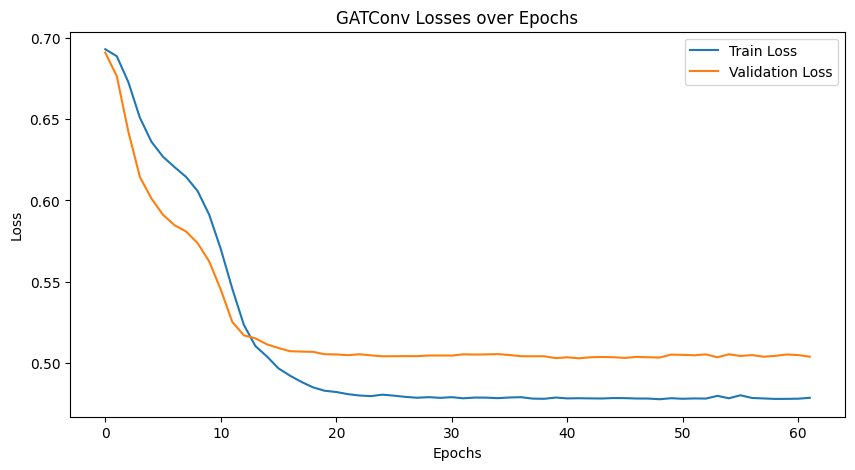

GATConv - Best Test Loss: 0.5031 achieved at Epoch: 042
The best model was from epoch 42 with a validation loss of 0.5031


In [88]:
hyperparams_gat = {
    "model_type": 'GATConv',  # Include model_type here
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "learning_rate": 0.001,
    "num_epochs": 150,
    "patience": 20,
    "lr_decay_step": 30,
    "lr_decay_factor": 0.5,
    "loss_function": 'crossentropy',
    "classifier_type": 'lstm'

}

model_gat = Model(hidden_channels=64, conv_type='gat', classifier_type=hyperparams_gat["classifier_type"])
best_epoch_gat, best_val_loss_gat = train_model(model_gat, train_loader, test_loader, hyperparams_gat)
print(f"The best model was from epoch {best_epoch_gat} with a validation loss of {best_val_loss_gat:.4f}")


### Evaluation and validation of the results

In [89]:
# Sample usage
models = {
    "SAGEConv": model_sage,
    "GATConv": model_gat
}
auc_scores = evaluate_models_auc(models, val_loader, device)


evaluation_results = evaluate_accuracy(models, sampled_data, device)

for model_name, metrics in evaluation_results.items():
    print(f"Evaluation Results for {model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("-----------------------------")


prediction_counts = count_predictions(models, sampled_data, device)

for model_name, metrics in prediction_counts.items():
    print(f"Prediction Counts for {model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("-----------------------------")
precision_recall_results = evaluate_precision_recall(models, sampled_data, device)

for model_name, metrics in precision_recall_results.items():
    print(f"Model: {model_name}, Precision: {metrics['Precision']}, Recall: {metrics['Recall']}")

f1_score_results = evaluate_f1_score(models, sampled_data, device)

for model_name, metrics in f1_score_results.items():
    print(f"Model: {model_name}, F1 Score: {metrics['F1 Score']}")

Validation AUC for SAGEConv: 0.8660
-----------------------------
Validation AUC for GATConv: 0.8480
-----------------------------
Evaluation Results for SAGEConv:
Average probability for Positive Edges: 0.7944562435150146
Accuracy for Positive Edges: 0.8330000042915344
Average probability for Negative Edges: 0.11962730437517166
Accuracy for Negative Edges: 0.8989999890327454
-----------------------------
Evaluation Results for GATConv:
Average probability for Positive Edges: 0.6067284941673279
Accuracy for Positive Edges: 0.8090000152587891
Average probability for Negative Edges: 0.35858288407325745
Accuracy for Negative Edges: 0.8870000243186951
-----------------------------
Prediction Counts for SAGEConv:
For Positive Edges: Number of 1's predicted: 833.0
For Positive Edges: Number of 0's predicted: 167.0
For Negative Edges: Number of 1's predicted: 101.0
For Negative Edges: Number of 0's predicted: 899.0
-----------------------------
Prediction Counts for GATConv:
For Positive Edge

In [60]:
# Prepare the data for the SAGE model
ground_truth_labels_index, ground_truth_labels, probabilities, binary_predictions = prepare_data(sampled_data, model_sage, device)

# Get the indices of positive and negative edges
positive_edge_indices, negative_edge_indices = get_positive_negative_indices(ground_truth_labels)
print(ground_truth_labels_index)
print(ground_truth_labels)
print(probabilities)
print(binary_predictions)

tensor([[ 621, 1656, 1634,  ...,  599, 1258, 1625],
        [   8,   60,   59,  ...,   15,   31,   30]])
tensor([1., 1., 1.,  ..., 0., 0., 0.])
tensor([9.8524e-01, 7.6489e-01, 7.3812e-01,  ..., 1.3621e-11, 5.9355e-01,
        4.2604e-02])
tensor([1., 1., 1.,  ..., 0., 1., 0.])


Visualization of results

In [61]:
data = []
for i in range(ground_truth_labels_index.size(1)):
    src_sampled, dst_sampled = sampled_data["reviewer", "reviews", "product"].edge_label_index[:, i]
    src_val_data, dst_val_data = val_data["reviewer", "reviews", "product"].edge_label_index[:, i]

    true_label = "Positive" if ground_truth_labels[i] == 1 else "Negative"
    probability =probabilities[i]
    prediction = "Positive" if binary_predictions[i] == 1 else "Negative"

    data.append({
        "Masked From": src_sampled.item(),  # Converting tensor to scalar
        "Masked To": dst_sampled.item(),    
        "Node From": src_val_data.item(), 
        "Node To": dst_val_data.item(),    
        "Probability": round(probability.item(), 5),          
        "True Label": true_label,
        "Prediction": prediction
    })

df_predictions = pd.DataFrame(data)
df_predictions.head(20)

Masked From  Masked To  Node From  Node To  Probability True Label  \
0           621          8       3282        8      0.98524   Positive   
1          1656         60       8707       60      0.76489   Positive   
2          1634         59       8616       59      0.73812   Positive   
3          1324         33       6978       33      0.87818   Positive   
4           159          8        827        8      0.99015   Positive   
5          1729         62       9030       62      0.98231   Positive   
6          1304         33       6808       33      0.93123   Positive   
7          1615         55       8509       55      0.93243   Positive   
8           123          8        641        8      0.99736   Positive   
9           620          8       3270        8      0.97051   Positive   
10          163          8        856        8      0.98301   Positive   
11          588          8       3016        8      0.98763   Positive   
12          582          8       3000        8      0.99211   Positive   
13          686          8       3589        8      0.98721   Positive   
14          693          8       3621        8      0.99604   Positive   
15          795          9       4125        9      0.87579   Positive   
16         1566         51       8293       51      0.04164   Positive   
17         1068         22       5461       22      0.38148   Positive   
18         1486         41       7809       41      0.12264   Positive   
19          691          8       3612        8      0.99550   Positive   

   Prediction  
0    Positive  
1    Positive  
2    Positive  
3    Positive  
4    Positive  
5    Positive  
6    Positive  
7    Positive  
8    Positive  
9    Positive  
10   Positive  
11   Positive  
12   Positive  
13   Positive  
14   Positive  
15   Positive  
16   Negative  
17   Negative  
18   Negative  
19   Positive

In [27]:
# Count the number of rows where True Label is positive and prediction is positive
true_positive_count = df_predictions[(df_predictions['True Label'] == 'Positive') & (df_predictions['Prediction'] == 'Positive')].shape[0]

# Count the number of rows where True Label is negative and prediction is negative
true_negative_count = df_predictions[(df_predictions['True Label'] == 'Negative') & (df_predictions['Prediction'] == 'Negative')].shape[0]

# Display the counts
print("True Positive Count:", true_positive_count)
print("True Negative Count:", true_negative_count)


True Positive Count: 844
True Negative Count: 911


In [ ]:
df_predictionss=pd.DataFrame()
# Create a new column to represent the combination of True Label and Prediction
df_predictionss['True_Prediction_Combo'] = df_predictions['True Label'] + '_' + df_predictions['Prediction']
user_combo_counts = df_predictionss.groupby('Node From')['True_Prediction_Combo'].nunique().reset_index()
user_combo_counts.columns = ['User', 'Common Combos']

user_combo_counts.head(10)


In [348]:
# Calculate the total number of common combinations across all users
total_common_combos = user_combo_counts['Common Combos'].sum()
print("Total Common Combinations:", total_common_combos)


Total Common Combinations: 1957


In [62]:
positive_predictions = df_predictions[df_predictions['Prediction'] == "Positive"]
product_recommendations_count = positive_predictions['Node To'].value_counts()
popularity_df = pd.DataFrame({'Product ID P': product_recommendations_count.index, 'Count_positive': product_recommendations_count.values})

negative_predictions = df_predictions[df_predictions['Prediction'] == "Negative"]
negative_node_to_popularity = negative_predictions['Node To'].value_counts()
negative_popularity_df = pd.DataFrame({'Product ID N': negative_node_to_popularity.index, 'Count_Negative': negative_node_to_popularity.values})

popularity_df = pd.concat([popularity_df, negative_popularity_df], axis=1)

popularity_df.head(10)

Product ID P  Count_positive  Product ID N  Count_Negative
0           8.0           388.0            45              31
1          33.0           117.0            47              30
2          20.0            71.0            39              30
3          62.0            41.0            25              26
4          61.0            31.0            24              26
5          12.0            31.0            46              25
6           1.0            27.0            50              25
7          60.0            27.0            32              24
8           9.0            25.0            22              24
9          55.0            22.0            19              24

Bad predictions

In [35]:
bad_predictions = df_predictions[df_predictions['True Label'] != df_predictions['Prediction']]
bad_predictions.head(300)

Masked From  Masked To  Node From  Node To  Probability True Label  \
10           1472         39       7680       39      0.28253   Positive   
25           1498         42       7909       42      0.08423   Positive   
27           1450         37       7543       37      0.10155   Positive   
32           1387         34       7232       34      0.11196   Positive   
35           1506         42       7944       42      0.23429   Positive   
...           ...        ...        ...      ...          ...        ...   
1955          545         32       2821       32      0.50172   Negative   
1956         1439          1       7486        1      0.76443   Negative   
1961         1192         12       6227       12      0.58273   Negative   
1978         1226          8       6360        8      0.95069   Negative   
1986         1817          4       9606        4      0.56114   Negative   

     Prediction  
10     Negative  
25     Negative  
27     Negative  
32     Negative  
35     Negative  
...         ...  
1955   Positive  
1956   Positive  
1961   Positive  
1978   Positive  
1986   Positive  

[272 rows x 7 columns]

In [36]:
# Count the occurrences of each product in bad_predictions
product_counts = bad_predictions['Node To'].value_counts()
bad_predictions_count_df = pd.DataFrame({'Product': product_counts.index, 'Occurrences': product_counts.values})
bad_predictions_count_df = bad_predictions_count_df.sort_values(by='Occurrences', ascending=False)

bad_predictions_count_df.head(10)


Product  Occurrences
0       39           16
1       33           14
2       61           12
3       44           11
4       36           11
5       31           10
6       42           10
7        8           10
8       35           10
9       30            9

In [63]:
# Count the number of positive and negative connections for each user
user_counts = df_predictions.groupby(['Node From', 'True Label'])['True Label'].count().unstack(fill_value=0)
user_counts['Total Count'] = user_counts['Positive'] + user_counts['Negative']

# Sort users by total count in descending order
most_popular_users = user_counts.sort_values(by='Total Count', ascending=False).reset_index()
most_popular_users.columns = ['User', 'Positive True Count', 'Negative True Count', 'Total Count']

popular_user_ids = most_popular_users['User'].tolist()
popular_user_predictions = df_predictions[df_predictions['Node From'].isin(popular_user_ids)]
popular_user_prediction_counts = popular_user_predictions.groupby(['Node From', 'Prediction'])['Prediction'].count().unstack(fill_value=0)
popular_user_prediction_counts.index.name = 'User'

# Merge the popular user prediction counts with the most_popular_users DataFrame
most_popular_users = pd.merge(most_popular_users, popular_user_prediction_counts, left_on='User', right_index=True, how='left')
most_popular_users.rename(columns={'Negative': 'Negative Predictions', 'Positive': 'Positive Predictions'}, inplace=True)
most_popular_users.fillna(0, inplace=True)

# Calculate the total count of positive predictions across all users
total_positive_predictions = most_popular_users['Positive Predictions'].sum()
total_negative_predictions = most_popular_users['Negative Predictions'].sum()

# Display the total counts
print("Total Positive Predictions:", total_positive_predictions)
print("Total Negative Predictions:", total_negative_predictions)

most_popular_users.head(10)


Total Positive Predictions: 934
Total Negative Predictions: 1066


User  Positive True Count  Negative True Count  Total Count  \
0  3334                    2                    1            3   
1  3628                    3                    0            3   
2  5786                    2                    1            3   
3  3236                    3                    0            3   
4  5803                    2                    1            3   
5  3948                    0                    3            3   
6     5                    2                    1            3   
7  1954                    3                    0            3   
8  8432                    1                    2            3   
9  2749                    2                    1            3   

   Negative Predictions  Positive Predictions  
0                     2                     1  
1                     3                     0  
2                     2                     1  
3                     3                     0  
4                     2                     1  
5                     0                     3  
6                     2                     1  
7                     3                     0  
8                     0                     3  
9                     1                     2

In [22]:
user_id =7  

# Extract the relevant data for the user
user_data = sampled_data["reviewer", "reviews", "product"]
user_mask = user_data.edge_index[0] == user_id

# Get the product IDs that the user has interacted with
user_interacted_products = user_data.edge_index[1][user_mask].tolist()

print(f"User {user_id} has interacted with the following products:")
for product_id in user_interacted_products:
    print(f"Product ID: {product_id}")


User 7 has interacted with the following products:
Product ID: 1


In [42]:
f1_score_results = evaluate_f1_score(models, sampled_data, device)

# Ispis rezultata
for model_name, metrics in f1_score_results.items():
    print(f"Model: {model_name}, F1 Score: {metrics['F1 Score']}")

Model: SAGEConv, F1 Score: 0.8623481781376517
Model: GATConv, F1 Score: 0.8629592850049653


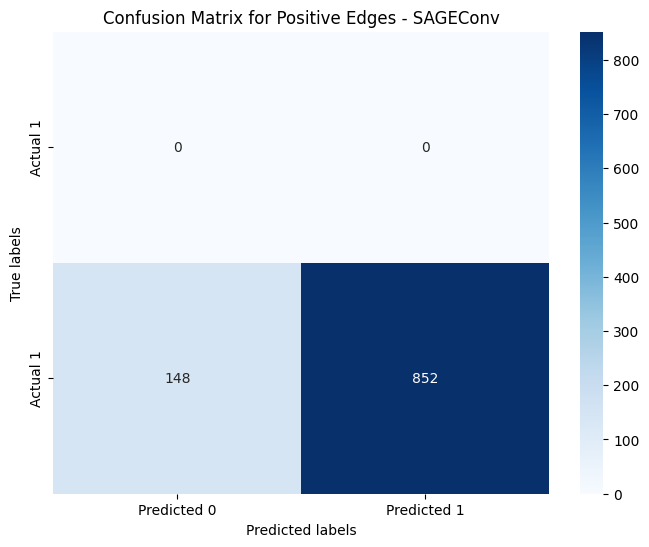

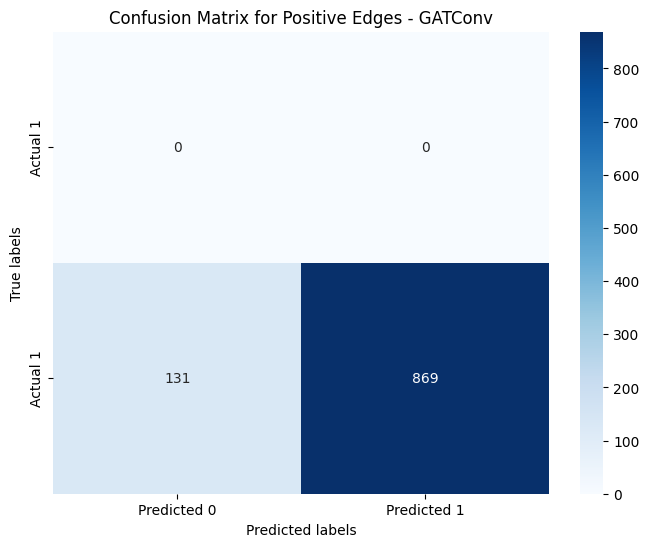

In [43]:
plot_confusion_matrix_for_positive_edges(models, sampled_data, device)

## Preparing validation functions for GUI

In [17]:
def hetero_to_networkx(data):
    G = nx.MultiDiGraph()

    # Adding nodes to the graph
    for node_type in data.node_types:
        ids = data[node_type].node_id
        G.add_nodes_from([(node_type + "_" + str(i.item()), {"type": node_type}) for i in ids])

    # Adding edges to the graph
    for (src_type, edge_type, dst_type), edge_index in data.edge_index_dict.items():
        edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
        G.add_edges_from([(src_type + "_" + str(src), dst_type + "_" + str(dst), {"type": edge_type}) for src, dst in edges])

    return G

def plot_reduced_graph(G, num_edges=600, save_path=None):
    """
    Plot a reduced graph focusing on a specific number of connections (edges).
    
    Args:
    - G (networkx.Graph): The input graph.
    - num_edges (int, optional): The number of edges to include in the visualization. Defaults to 200.
    
    Returns:
    None
    """
    
    plt.figure(figsize=(15, 15))
    
    # Convert edges to a list and then select a sample
    edges_list = list(G.edges())
    edges_sample = random.sample(edges_list, min(num_edges, len(edges_list)))
    nodes_in_sample = set([u for u, v in edges_sample] + [v for u, v in edges_sample])

    # Subset of the graph for visualization
    G_sample = G.subgraph(nodes_in_sample)
    pos = nx.spring_layout(G_sample, k=0.5)

    color_map = {
        'reviewer': 'green',
        'product': 'blue'
    }

    # Draw nodes
    for node_type, color in color_map.items():
        nx.draw_networkx_nodes(G_sample, pos, 
                               nodelist=[n for n, d in G_sample.nodes(data=True) if d['type'] == node_type],
                               node_size=100,
                               node_color=color,
                               label=node_type)

    # Draw only the sampled edges
    nx.draw_networkx_edges(G_sample, pos, 
                           edgelist=edges_sample,
                           width=1.5, alpha=0.6)

    plt.legend()
    plt.axis("off")
    if save_path:
        plt.savefig(save_path, dpi=100)
    else:
        plt.show()

# Example usage:
# plot_reduced_graph(G, num_edges=200)  # For 200 connections


In [18]:
G_val = hetero_to_networkx(sampled_data)
print(G_val)

MultiDiGraph with 9148 nodes and 14000 edges


Real Validation Data:


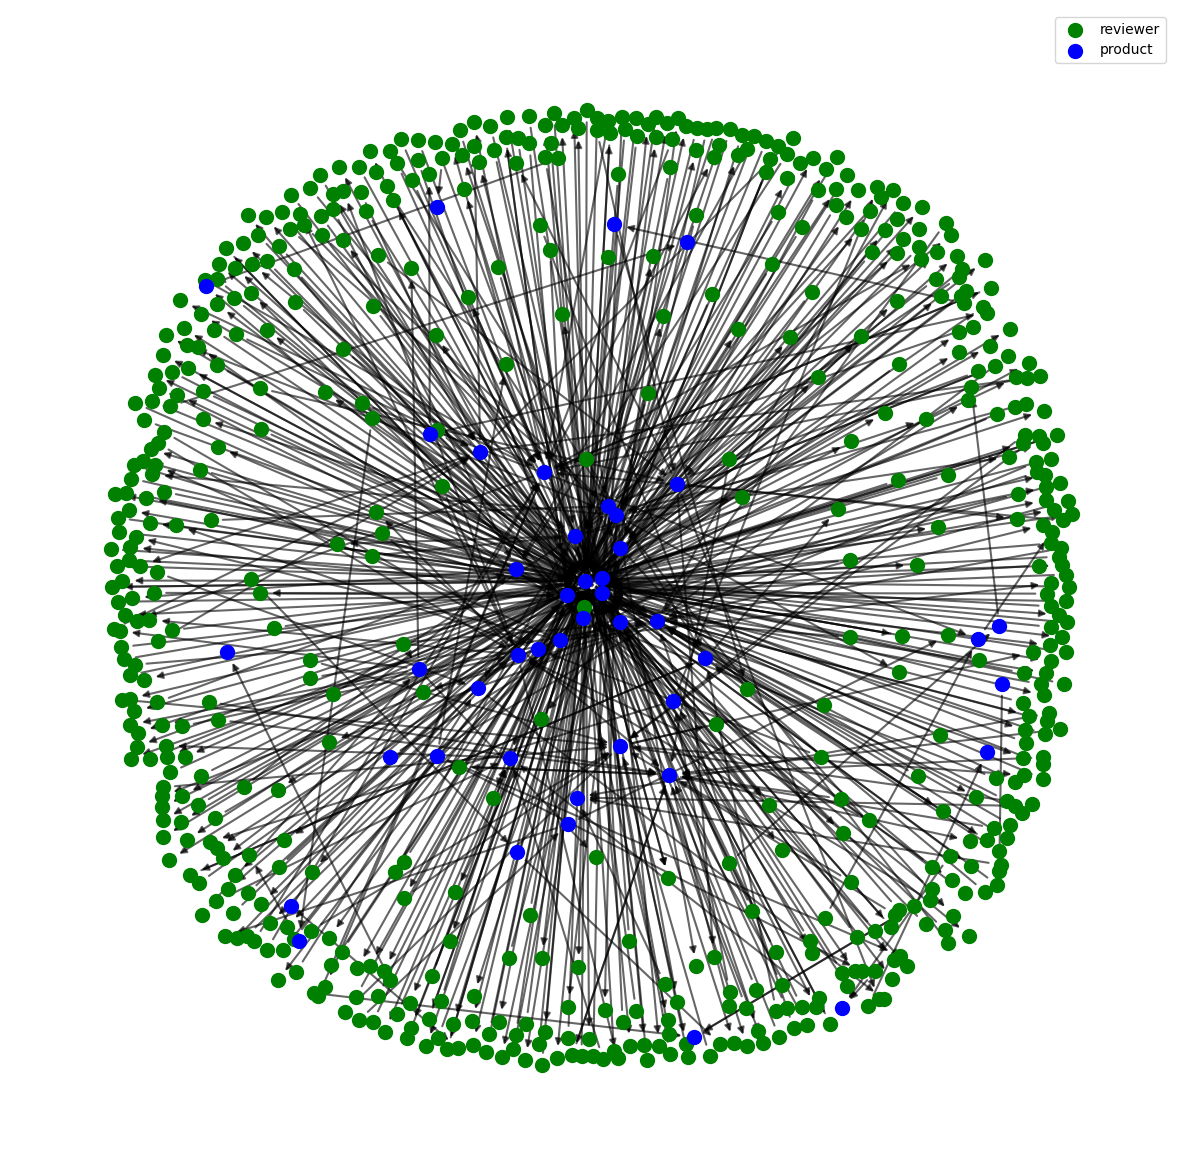

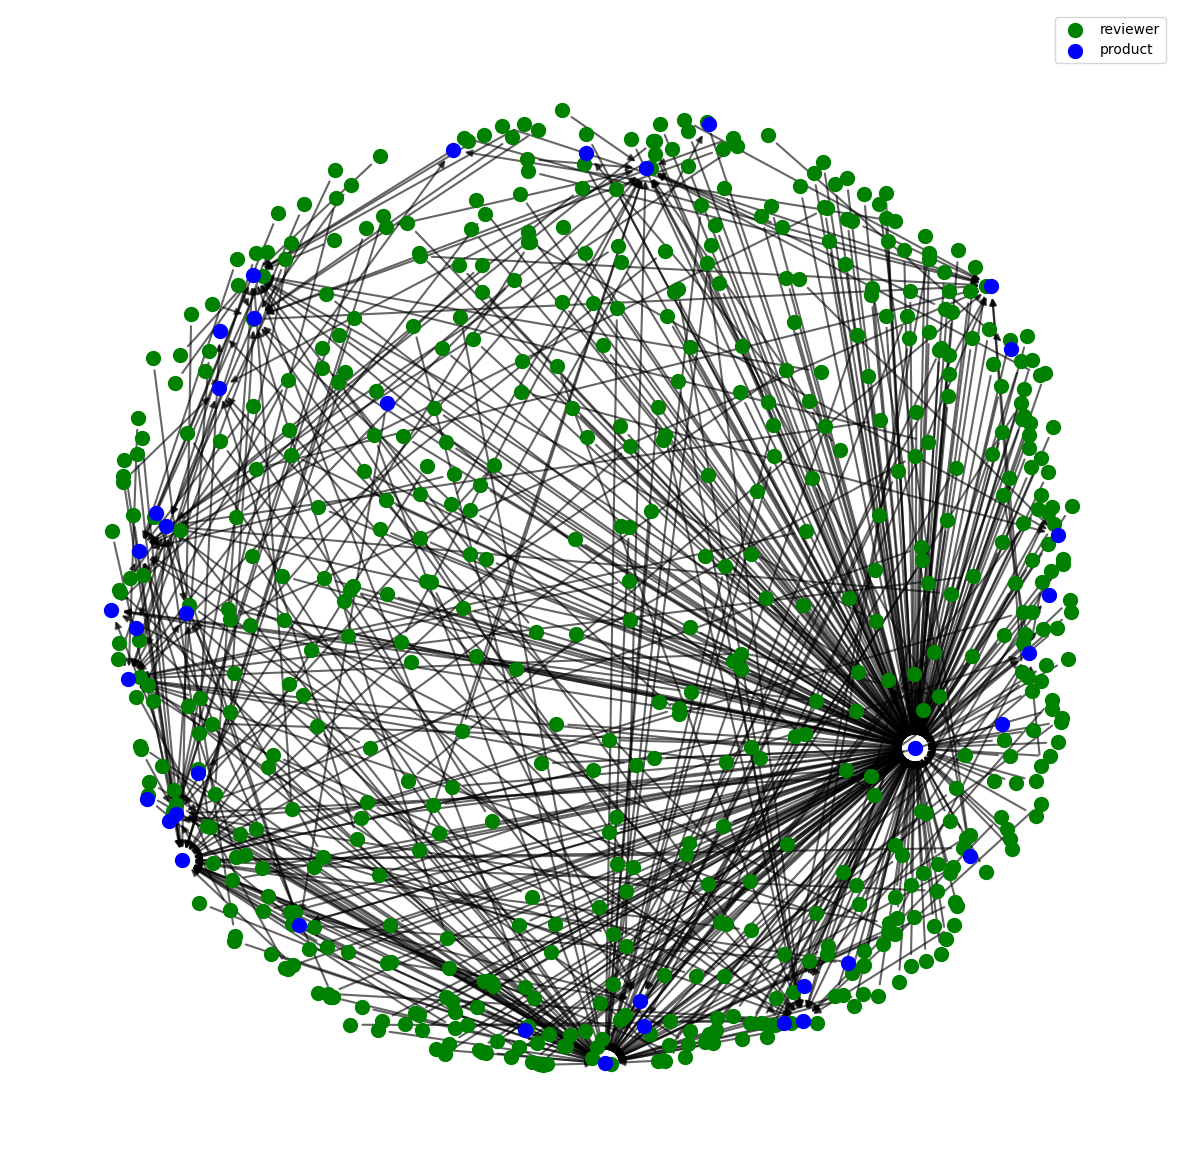

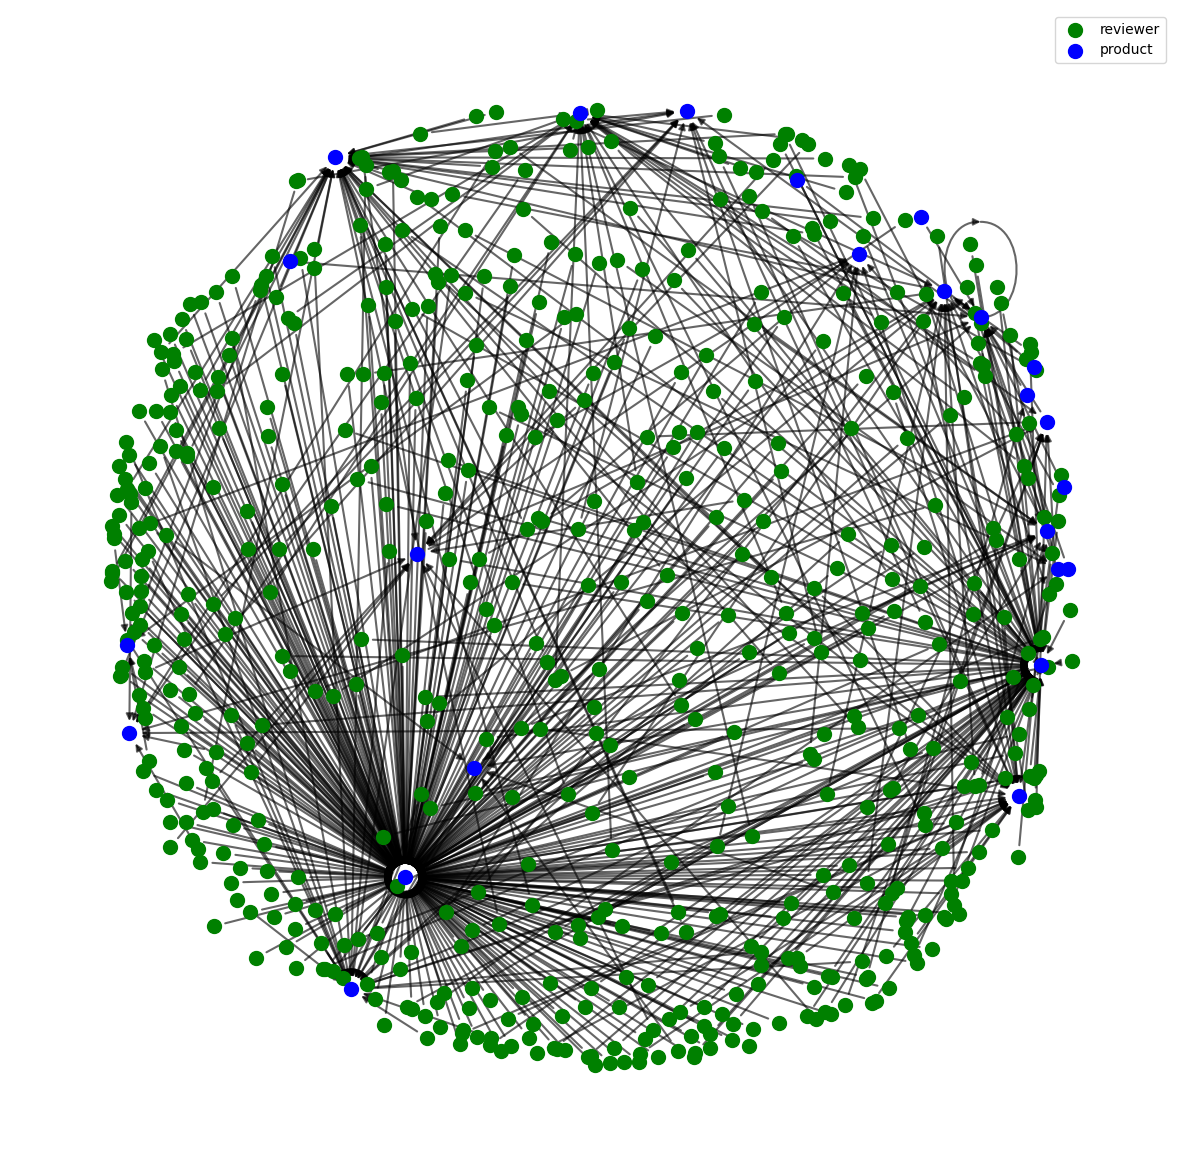

In [19]:
def generate_predicted_graph(model, sampled_data, device):
    model = model.to(device)
    model.eval()

    _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)

    positive_edge_indices, _ = get_positive_negative_indices(ground_truth_labels)
    positive_preds = binary_predictions[positive_edge_indices]
    positive_true = ground_truth_labels[positive_edge_indices]

    true_positive_mask = (positive_preds == positive_true) & (positive_true == 1)
    true_positive_indices = positive_edge_indices[true_positive_mask]
    true_positive_edge_pairs = sampled_data["reviewer", "reviews", "product"].edge_label_index[:, true_positive_indices].cpu().numpy()

    G = nx.DiGraph()

    for reviewer_id in sampled_data["reviewer"]["node_id"].cpu().numpy():
        G.add_node(reviewer_id, type="reviewer")

    for product_id in sampled_data["product"]["node_id"].cpu().numpy():
        G.add_node(product_id, type="product")

    for source, target in true_positive_edge_pairs.T:
        G.add_edge(source, target)

    return G

def plot_all_models(models, sampled_data, device):
    # Plot real validation data first
    G_val = hetero_to_networkx(sampled_data)  # Assuming you want to visualize the sampled_data as validation data
    print("Real Validation Data:")
    plot_reduced_graph(G_val, save_path="Val_Graph.png")

    # Plot for each model
    for model_name, model in models.items():
        G = generate_predicted_graph(model, sampled_data, device)
        plot_reduced_graph(G, save_path=f"PredictedGraph_{model_name}.png")

# Sample usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "SAGEConv": model_sage,
    "GATConv": model_gat
}
plot_all_models(models, sampled_data, device)


Preparing results for validation and evaluation in tkinter window

In [90]:
def real_product_appearances(sampled_data):
    edge_indices = sampled_data["reviewer", "reviews", "product"].edge_label_index
    destination_nodes = edge_indices[1].cpu().numpy()

    product_counts = Counter(destination_nodes)
    return product_counts

def predicted_product_appearances_for_model(model, sampled_data, device):
    _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)

    edge_indices = sampled_data["reviewer", "reviews", "product"].edge_label_index
    destination_nodes = edge_indices[1].cpu().numpy()
    binary_predictions = binary_predictions.cpu().numpy()

    predicted_product_counts = Counter(dest for dest, prediction in zip(destination_nodes, binary_predictions) if prediction == 1)
    return predicted_product_counts

def generate_comparison_table(models, sampled_data, device):
    real_counts = real_product_appearances(sampled_data)

    data = {
        "Real Appearances": [real_counts.get(product, 0) for product in real_counts]
    }

    for model_name, model_instance in models.items():
        predicted_counts = predicted_product_appearances_for_model(model_instance, sampled_data, device)
        data[model_name] = [predicted_counts.get(product, 0) for product in real_counts]

    df = pd.DataFrame(data, index=real_counts.keys())
    df.index.name = "Product"
    
    # Sort by real appearances in descending order
    df = df.sort_values(by="Real Appearances", ascending=False)
    return df

models = {
    "SAGEConv": model_sage,
    "GATConv": model_gat
}

comparison_table = generate_comparison_table(models, sampled_data, device)
print(comparison_table)



         Real Appearances  SAGEConv  GATConv
Product                                     
8                     392       388      377
33                    128       117      117
20                     87        71       73
62                     53        41       15
39                     52        22       35
12                     45        31       36
55                     44        22       15
1                      40        27       32
60                     40        27       14
45                     37         6       22
31                     36        19       22
61                     36        31       16
9                      34        25       24
36                     34        19       21
24                     32         6       15
47                     31         1        0
22                     30         6        0
42                     27         6       20
25                     27         1        0
46                     26         1        0
19        

In [91]:
def real_reviewer_appearances(sampled_data):
    edge_indices = sampled_data["reviewer", "reviews", "product"].edge_label_index
    source_nodes = edge_indices[0].cpu().numpy()  # Focusing on source nodes (reviewers)

    reviewer_counts = Counter(source_nodes)
    return reviewer_counts

def predicted_reviewer_appearances_for_model(model, sampled_data, device):
    _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)

    edge_indices = sampled_data["reviewer", "reviews", "product"].edge_label_index
    source_nodes = edge_indices[0].cpu().numpy()  # Focusing on source nodes (reviewers)
    binary_predictions = binary_predictions.cpu().numpy()

    predicted_reviewer_counts = Counter(src for src, prediction in zip(source_nodes, binary_predictions) if prediction == 1)
    return predicted_reviewer_counts


def custom_sort(row, sage_threshold=1, gat_threshold=1):
    # Funkcija koja proverava da li je predviđanje blizu stvarnog rezultata
    sage_diff = abs(row['Real Appearances'] - row.get('SAGEConv', 0))
    gat_diff = abs(row['Real Appearances'] - row.get('GATConv', 0))
    
    # Povratak vrednosti sortiranja na osnovu blizine predviđanja
    if sage_diff <= sage_threshold and gat_diff <= gat_threshold:
        return 0
    else:
        return max(sage_diff, gat_diff)

def generate_comparison_table(models, sampled_data, device):
    real_counts = real_reviewer_appearances(sampled_data)

    data = {
        "Real Appearances": [real_counts.get(reviewer, 0) for reviewer in real_counts]
    }

    for model_name, model_instance in models.items():
        predicted_counts = predicted_reviewer_appearances_for_model(model_instance, sampled_data, device)
        data[model_name] = [predicted_counts.get(reviewer, 0) for reviewer in real_counts]

    df = pd.DataFrame(data, index=real_counts.keys())
    df.index.name = "Reviewer"
    
    # Primena prilagođenog sortiranja
    df['CustomSortKey'] = df.apply(custom_sort, axis=1)
    
    # Sortiranje na osnovu ključa prilagođenog sortiranja, a zatim na osnovu stvarnih pojava
    df = df.sort_values(by=['CustomSortKey', 'Real Appearances'], ascending=[True, False])
    
    # Uklanjanje pomoćne kolone za sortiranje
    df.drop(columns=['CustomSortKey'], inplace=True)
    
    return df

# Usage with your models
models = {
    "SAGEConv": model_sage,
    "GATConv": model_gat
}

comparison_table = generate_comparison_table(models, sampled_data, device)
print(comparison_table)


          Real Appearances  SAGEConv  GATConv
Reviewer                                     
1594                     3         3        2
533                      3         2        2
621                      2         2        2
1656                     2         2        2
582                      2         1        1
686                      2         2        2
1721                     2         2        2
350                      2         1        1
299                      2         2        2
396                      2         2        1
881                      2         2        2
409                      2         1        1
427                      2         2        2
308                      2         1        1
197                      2         2        2
845                      2         2        2
379                      2         2        2
1212                     2         1        1
1185                     2         1        1
508                      2        

In [92]:
def real_reviewer_product_connections(val_loader):
    # Extract real connections from val_loader
    # Adjust this part to match the actual structure of your val_loader
    real_connections = set()
    for batch in val_loader:
        edge_indices = batch["reviewer", "reviews", "product"].edge_label_index
        source_nodes = edge_indices[0].cpu().numpy()
        destination_nodes = edge_indices[1].cpu().numpy()
        for src, dest in zip(source_nodes, destination_nodes):
            real_connections.add((src, dest))
    return real_connections

def predicted_reviewer_product_connections(model, sampled_data, device):
    # Extract predicted connections from sampled_data using the model
    _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
    edge_indices = sampled_data["reviewer", "reviews", "product"].edge_label_index
    source_nodes = edge_indices[0].cpu().numpy()
    destination_nodes = edge_indices[1].cpu().numpy()
    binary_predictions = binary_predictions.cpu().numpy()

    predicted_connections = set((src, dest) for src, dest, prediction in zip(source_nodes, destination_nodes, binary_predictions) if prediction == 1)
    return predicted_connections

def compare_with_val_loader(models, sampled_data, val_loader, device):
    real_connections = real_reviewer_product_connections(val_loader)

    data = {}
    for model_name, model_instance in models.items():
        predicted_connections = predicted_reviewer_product_connections(model_instance, sampled_data, device)
        correct_predictions = real_connections.intersection(predicted_connections)
        data[model_name] = len(correct_predictions)

    return pd.Series(data, name="Correct Predictions")

# Usage with your models
models = {
    "SAGEConv": model_sage,
    "GATConv": model_gat
}

comparison_results = compare_with_val_loader(models, sampled_data, val_loader, device)
print(comparison_results)


SAGEConv    925
GATConv     914
Name: Correct Predictions, dtype: int64


Function for calculating probability of interaction between specific user and all products

In [93]:
def get_user_recommendation_probabilities(model, user_id, sampled_data, device):
    model.eval()
    model.to(device)
    user_recommendations = []

    with torch.no_grad():
        item_ids = sampled_data['product'].node_id.to(device)

        # Generate user-item pairs for the specified user
        user_item_pairs = [(user_id, item_id.item()) for item_id in item_ids]

        for _, item_id in user_item_pairs:
            edge_label_index = torch.tensor([[user_id], [item_id]], device=device)

            # Create pseudo sampled_data with edge_label_index
            pseudo_sampled_data = sampled_data.clone()
            pseudo_sampled_data['reviewer', 'reviews', 'product'].edge_label_index = edge_label_index

            pred = model(pseudo_sampled_data)
            prob = torch.sigmoid(pred).item()
            user_recommendations.append((item_id, prob))

    user_recommendations.sort(key=lambda x: x[1], reverse=True)
    return user_recommendations

# Example usage
user_id = 10  # Replace with the ID of the user you're interested in
recommendations = get_user_recommendation_probabilities(model_sage, user_id, sampled_data, device)
import pandas as pd

def filter_and_display_recommendations(recommendations, probability_threshold=0.5, top_n=None):
    # Filter recommendations with probability greater than the threshold
    filtered_recommendations = [(item_id, prob) for item_id, prob in recommendations if prob > probability_threshold]

    # Convert to DataFrame for better display
    df = pd.DataFrame(filtered_recommendations, columns=['Item ID', 'Probability'])

    # If top_n is specified, select only the top_n rows
    if top_n is not None:
        df = df.head(top_n)

    return df

# Example usage
probability_threshold = 0.5
top_n = 10  # Set to None if you don't want to limit the number of recommendations
filtered_df = filter_and_display_recommendations(recommendations, probability_threshold)
print(filtered_df)


    Item ID  Probability
0         8     0.975664
1        33     0.892595
2        20     0.861210
3         1     0.847451
4        12     0.840845
5        62     0.799110
6        36     0.797285
7        61     0.765123
8        60     0.738137
9         9     0.715628
10       31     0.678400
11       39     0.676588
12       35     0.673393
13       30     0.658425
14       42     0.621106
15       57     0.612464
16       23     0.581584
17       24     0.547963
18       55     0.539301
19       54     0.533182
20       27     0.527937
21       17     0.526530


In [173]:
cf_recommendations_df = pd.read_csv("recommendations_CF.csv")


## GUI

Validation AUC for SAGEConv: 0.8660
-----------------------------
Validation AUC for GATConv: 0.8480
-----------------------------
Validation AUC for SAGEConv: 0.8660
-----------------------------
Validation AUC for GATConv: 0.8480
-----------------------------


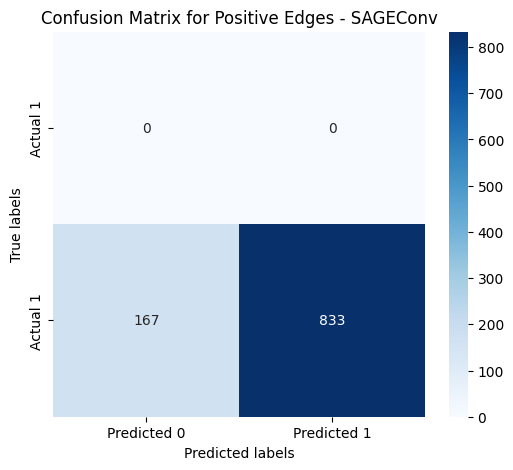

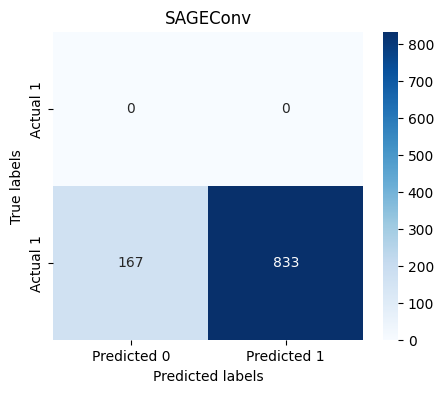

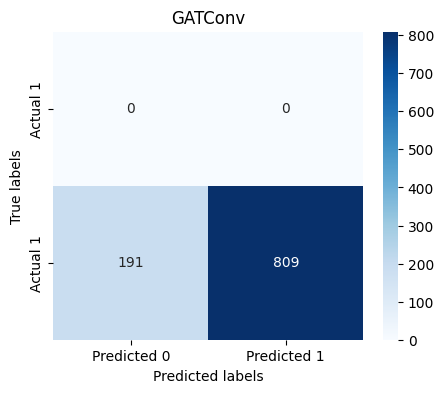

In [99]:
def show_results():
    selected_model = model_combobox.get()
    
    if selected_model not in models:
        messagebox.showerror("Error", f"{selected_model} model not available!")
        return
    
    # Clear existing text in the results_text widget
    results_text.delete(1.0, tk.END)

    # AUC Results
    auc_result = evaluate_models_auc({selected_model: models[selected_model]}, [sampled_data], device)
    results_text.insert(tk.END, f"Validation AUC for {selected_model}: {auc_result[selected_model]:.4f}\n")
    results_text.insert(tk.END, "-"*30 + "\n")

    # Accuracy Results
    acc_results = evaluate_accuracy({selected_model: models[selected_model]}, sampled_data, device)
    for key, value in acc_results[selected_model].items():
        results_text.insert(tk.END, f"{key}: {value:.4f}\n")
    results_text.insert(tk.END, "-"*30 + "\n")

    # Count Predictions Results
    pred_counts = count_predictions({selected_model: models[selected_model]}, sampled_data, device)
    for key, value in pred_counts[selected_model].items():
        results_text.insert(tk.END, f"{key}: {value}\n")

def display_confusion_matrix():
    selected_model = model_combobox.get()
    
    if selected_model not in models:
        messagebox.showerror("Error", f"{selected_model} model not available!")
        return

    _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, models[selected_model], device)
    positive_edge_indices, _ = get_positive_negative_indices(ground_truth_labels)
    
    positive_preds = binary_predictions[positive_edge_indices]
    true_positive_labels = torch.ones_like(positive_preds)
    
    cm = confusion_matrix(true_positive_labels.cpu().numpy(), positive_preds.cpu().numpy())

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax,
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 1', 'Actual 1'])
    ax.set_ylabel('True labels')
    ax.set_xlabel('Predicted labels')
    ax.set_title(f'Confusion Matrix for Positive Edges - {selected_model}')

    # Creating new window for confusion matrix
    cm_window = tk.Toplevel(root)
    cm_window.title(f"Confusion Matrix - {selected_model}")
    canvas = FigureCanvasTkAgg(fig, master=cm_window)
    canvas.draw()
    canvas.get_tk_widget().pack()
def display_model_graphs():
    selected_model = model_combobox.get()
    
    if selected_model not in models:
        messagebox.showerror("Error", f"{selected_model} model not available!")
        return
    
    # Assuming plot_all_models has been called earlier and images are already saved
    val_image = Image.open("Val_Graph.png")
    model_image = Image.open(f"PredictedGraph_{selected_model}.png")

    # Resize the images to make them smaller while keeping the aspect ratio
    base_width = 600
    val_image = val_image.resize((base_width, int((base_width / val_image.width) * val_image.height)))
    model_image = model_image.resize((base_width, int((base_width / model_image.width) * model_image.height)))
    
    val_photo = ImageTk.PhotoImage(val_image)
    model_photo = ImageTk.PhotoImage(model_image)
    
    # Creating new window for model's graph comparison with real data graph
    graph_window = tk.Toplevel(root)
    graph_window.title(f"Graph Comparison - {selected_model}")
    
    # Adding descriptive text for the graphs
    tk.Label(graph_window, text="Real Connections", font=("Arial", 16)).grid(row=0, column=0, padx=10, pady=10)
    tk.Label(graph_window, text="Predicted Connections", font=("Arial", 16)).grid(row=0, column=1, padx=10, pady=10)
    
    # Displaying Validation Graph (Real Connections)
    val_label = tk.Label(graph_window, image=val_photo)
    val_label.image = val_photo  # Keep a reference to prevent garbage collection
    val_label.grid(row=1, column=0, padx=10, pady=10)
    
    # Displaying Model's Graph (Predicted Connections)
    model_label = tk.Label(graph_window, image=model_photo)
    model_label.image = model_photo
    model_label.grid(row=1, column=1, padx=10, pady=10)

def display_comparison_table():
    selected_model = model_combobox.get()

    if selected_model not in models:
        messagebox.showerror("Error", f"{selected_model} model not available!")
        return
    
    df = generate_comparison_table({selected_model: models[selected_model]}, sampled_data, device)

    # Creating a new window for the comparison table
    table_window = tk.Toplevel(root)
    table_window.title(f"Real vs. Predicted Data - {selected_model}")

    # Create and pack the treeview
    tree = ttk.Treeview(table_window, columns=('User', 'Real Appearances', selected_model), show='headings')
    tree.heading('User', text='User')
    tree.heading('Real Appearances', text='Real Appearances')
    tree.heading(selected_model, text=selected_model)

    for index, row in df.iterrows():
        tree.insert("", tk.END, values=(index, row["Real Appearances"], row[selected_model]))

    tree.pack(pady=20)



#-------------------------------------------------------NEW WINDOW--------------------------------------------------------------------------------
def show_comparison_window():
    comp_window = tk.Toplevel(root)
    comp_window.title("Model Comparisons")

    ttk.Label(comp_window, text="Model Comparisons:", font=("Arial", 16)).pack(pady=20)
    
    # Button to compare models using the AUC
    ttk.Button(comp_window, text="Compare AUC", command=compare_auc).pack(pady=10)

    # Button to compare models using Accuracy
    ttk.Button(comp_window, text="Compare Accuracy", command=compare_accuracy).pack(pady=10)

    # Button to compare models using Count Predictions
    ttk.Button(comp_window, text="Compare Count Predictions", command=compare_pred_counts).pack(pady=10)
     # Button to compare models' confusion matrices
    ttk.Button(comp_window, text="Compare Confusion Matrices", command=compare_confusion_matrices).pack(pady=10)

    # Button to compare models' graphs
    ttk.Button(comp_window, text="Compare Graphs", command=compare_graphs).pack(pady=10)

    # Button to compare models' Real vs Predicted data
    ttk.Button(comp_window, text="Compare Real vs Predicted", command=lambda: compare_real_vs_predicted(models, sampled_data, device)).pack(pady=10)
    
def compare_auc():
    all_aucs = evaluate_models_auc(models, [sampled_data], device)
    message = "AUC Comparison:\n\n" + "\n".join(f"{model}: {auc:.4f}" for model, auc in all_aucs.items())
    update_comparison_results(message)

def compare_accuracy():
    all_accuracies = evaluate_accuracy(models, sampled_data, device)
    message = "Accuracy Comparison:\n\n" + "\n".join(f"{model}:\n" + "\n".join(f"{key}: {value:.4f}" for key, value in acc.items()) for model, acc in all_accuracies.items())
    update_comparison_results(message)

def compare_pred_counts():
    all_pred_counts = count_predictions(models, sampled_data, device)
    message = "Predictions Count Comparison:\n\n"
    for model_name, pred_values in all_pred_counts.items():
        message += f"{model_name}:\n" + "\n".join(f"{key}: {value}" for key, value in pred_values.items()) + "\n" + "-"*30 + "\n"
    update_comparison_results(message)

def compare_confusion_matrices():
    cm_window = tk.Toplevel(root)
    cm_window.title("Confusion Matrices Comparison")

    for index, (model_name, model) in enumerate(models.items()):
        _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
        positive_edge_indices, _ = get_positive_negative_indices(ground_truth_labels)
        positive_preds = binary_predictions[positive_edge_indices]
        true_positive_labels = torch.ones_like(positive_preds)
        cm = confusion_matrix(true_positive_labels.cpu().numpy(), positive_preds.cpu().numpy())
        
        # Plotting
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax,
                    xticklabels=['Predicted 0', 'Predicted 1'], 
                    yticklabels=['Actual 1', 'Actual 1'])
        ax.set_ylabel('True labels')
        ax.set_xlabel('Predicted labels')
        ax.set_title(f'{model_name}')
        
        # Embed the plot in the tkinter window
        canvas = FigureCanvasTkAgg(fig, master=cm_window)
        canvas.draw()
        canvas.get_tk_widget().grid(row=0, column=index)
        ttk.Label(cm_window, text=model_name, font=("Arial", 14)).grid(row=1, column=index)

def compare_graphs():
    graph_window = tk.Toplevel(root)
    graph_window.title("Graphs Comparison")

    for index, (model_name, _) in enumerate(models.items()):
        # Assuming you've called plot_all_models before and images are already saved
        model_image = Image.open(f"PredictedGraph_{model_name}.png")
        
        base_width = 500
        model_image = model_image.resize((base_width, int((base_width / model_image.width) * model_image.height)))
        model_photo = ImageTk.PhotoImage(model_image)
        
        # Displaying Model's Graph
        model_label = tk.Label(graph_window, image=model_photo)
        model_label.image = model_photo
        model_label.grid(row=0, column=index, padx=10, pady=10)
        ttk.Label(graph_window, text=model_name, font=("Arial", 14)).grid(row=1, column=index)

def compare_real_vs_predicted(models, sampled_data, device):
    # Generišemo DataFrame za upoređivanje
    df = generate_comparison_table(models, sampled_data, device)

    # Kreiranje novog prozora za tabelu upoređivanja
    table_window = tk.Toplevel(root)
    table_window.title("Real vs. Predicted Data - All Models")

    # Kreiranje i postavljanje treeview
    tree = ttk.Treeview(table_window, columns=['User', 'Real Appearances'] + list(models.keys()), show='headings')
    tree.heading('User', text='User')
    tree.heading('Real Appearances', text='Real Appearances')
    
    for model_name in models:
        tree.heading(model_name, text=model_name)
    
    for index, row in df.iterrows():
        tree.insert("", tk.END, values=[index] + row.tolist())

    tree.pack(pady=20)


def update_comparison_results(message):
    for widget in comparison_results_frame.winfo_children():
        widget.destroy()
    results_text = tk.Text(comparison_results_frame,  wrap=tk.WORD, width=50, height=15)
    results_text.pack(fill='both', expand=True)
    results_text.insert(tk.END, message)

#----------------------------------------------Recommendations-------------------------------------------------------------------------

# Function for getting and showing recommendations
def get_and_show_recommendations():
    # Clear previous recommendations
    for i in rec_tree.get_children():
        rec_tree.delete(i)

    try:
        # Get the user ID from the ComboBox
        user_id = int(user_id_combobox.get())

        if user_id >= total_unique_users:
            raise ValueError("User ID exceeds the total number of unique users")

        selected_model_name = rec_model_combobox.get()

        # Map combobox selection to actual model object
        model_dict = {"SAGEConv": model_sage, "GATConv": model_gat}
        if selected_model_name in model_dict:
            selected_model = model_dict[selected_model_name]

            # Show processing message
            status_label.config(text="Evaluating recommendations...")
            recommendation_tab.update_idletasks()

            recommendations = get_user_recommendation_probabilities(selected_model, user_id, sampled_data, device)
            for item_id, prob in recommendations:
                # Determine the tag based on probability
                tag = 'green' if prob > 0.5 else 'red'
                rec_tree.insert("", tk.END, values=(item_id, prob, ""), tags=(tag,))

            # Clear processing message
            status_label.config(text="")
        else:
            messagebox.showerror("Error", f"{selected_model_name} model not available!")
    except ValueError as ve:
        messagebox.showerror("Error", str(ve))



#-------------------------------------------------------GUI Setup-------------------------------------------------------------------------

# Initialize the main GUI window
root = tk.Tk()
root.title("Model validation and recommendation")

# Create a Notebook for tabs
notebook = ttk.Notebook(root)
notebook.pack(pady=10, expand=True)

# Tabs
evaluation_tab = ttk.Frame(notebook)
comparison_tab = ttk.Frame(notebook)
recommendation_tab = ttk.Frame(notebook)
notebook.add(evaluation_tab, text='Model Evaluation')
notebook.add(comparison_tab, text='Model Comparison')
notebook.add(recommendation_tab, text='Recommendation System')

#-------------------------------------------------------Model Evaluation Tab---------------------------------------------------------------

# Dropdown for model selection
ttk.Label(evaluation_tab, text="Select Model:").pack(pady=10)
model_combobox = ttk.Combobox(evaluation_tab, values=list(models.keys()))
model_combobox.pack(pady=10)
model_combobox.set("SAGEConv")  # Default selected value

# Button to trigger the evaluation
btn_evaluate = ttk.Button(evaluation_tab, text="Evaluate", command=show_results)
btn_evaluate.pack(pady=10)

# Button to display the confusion matrix
btn_cm = ttk.Button(evaluation_tab, text="Show Confusion Matrix", command=display_confusion_matrix)
btn_cm.pack(pady=10)

# Button to display the model's graph in comparison with real data graph
btn_graphs = ttk.Button(evaluation_tab, text="Show Graphs", command=display_model_graphs)
btn_graphs.pack(pady=10)

# Button to show Real vs. Predicted Data
btn_comparison = ttk.Button(evaluation_tab, text="Show Real vs. Predicted Data", command=display_comparison_table)
btn_comparison.pack(pady=10)

# Text widget for displaying results
results_text = tk.Text(evaluation_tab, wrap=tk.WORD, width=50, height=15)
results_text.pack(pady=10)


#-------------------------------------------------------Model Comparison Tab Setup-------------------------------------------------------

# Label and buttons for model comparisons
ttk.Label(comparison_tab, text="Model Comparisons:", font=("Arial", 16)).pack(pady=10)
ttk.Button(comparison_tab, text="Compare AUC", command=compare_auc).pack(pady=10)
ttk.Button(comparison_tab, text="Compare Accuracy", command=compare_accuracy).pack(pady=10)
ttk.Button(comparison_tab, text="Compare Count Predictions", command=compare_pred_counts).pack(pady=10)
ttk.Button(comparison_tab, text="Compare Confusion Matrices", command=compare_confusion_matrices).pack(pady=10)
ttk.Button(comparison_tab, text="Compare Graphs", command=compare_graphs).pack(pady=10)
ttk.Button(comparison_tab, text="Compare Real vs Predicted", command=lambda: compare_real_vs_predicted(models, sampled_data, device)).pack(pady=10)

# Results frame in comparison tab
comparison_results_frame = ttk.Frame(comparison_tab)
comparison_results_frame.pack(pady=10, fill='both', expand=True)

#-------------------------------------------------------Recommendation System Tab Setup----------------------------------------------------

total_unique_users = data['reviewer'].node_id.size(0)

# Extract unique real user IDs from df_predictions
unique_real_user_ids = df_predictions['Node From'].unique().tolist()

# Exclude user IDs greater than the total number of unique users
unique_real_user_ids = [uid for uid in unique_real_user_ids if uid < total_unique_users]

unique_real_user_ids = df_predictions['Node From'].unique().tolist()

# Recommendation System Tab Setup
ttk.Label(recommendation_tab, text="Select Model:").pack(pady=10)
rec_model_combobox = ttk.Combobox(recommendation_tab, values=["SAGEConv", "GATConv"])
rec_model_combobox.pack(pady=10)
rec_model_combobox.set("SAGEConv")  # Default selected value

# Dropdown for user ID selection
ttk.Label(recommendation_tab, text="Select User ID:").pack(pady=10)
user_id_combobox = ttk.Combobox(recommendation_tab, values=unique_real_user_ids)
user_id_combobox.pack(pady=10)

rec_tree = ttk.Treeview(recommendation_tab, columns=('Item ID', 'Probability'), show='headings')
rec_tree.heading('Item ID', text='Item ID')
rec_tree.heading('Probability', text='Probability')
rec_tree.pack(pady=20)

status_label = ttk.Label(recommendation_tab, text="")
status_label.pack(pady=10)

get_recs_button = ttk.Button(recommendation_tab, text="Get Recommendations", command=get_and_show_recommendations)
get_recs_button.pack(pady=10)

rec_tree.tag_configure('green', background='#90EE90')
rec_tree.tag_configure('red', background='#FFCCCB')



#-------------------------------------------------------Main Loop-------------------------------------------------------------------------

root.mainloop()